
# BREXIT NEWS ANALYSIS

## Import and utility

In [ ]:
#install library
!pip3 install newspaper3k
!pip install afinn
!pip install maxminddb-geolite2
!pip install wordcloud

In [ ]:
from newspaper import Article
from newspaper import Config
from newspaper import ArticleException


import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download("wordnet")


import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('maxent_ne_chunker')
nltk.download('words')

import string
punctuation = string.punctuation
punctuation = punctuation +'``'+ "''"+'‘'+ '’' +'”'+'“'

from urllib.parse import urlparse
import socket
from geolite2 import geolite2


from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /home/jimmy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jimmy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jimmy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jimmy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
%matplotlib inline


import warnings
import requests
import zipfile
import io
import json
import unicodedata
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import locale

import xml.etree.ElementTree as ET

from locale import atof
from dateutil import parser
from datetime import datetime

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

import re
import os
from collections import Counter
import statistics

from afinn import Afinn
afinn = Afinn(emoticons=False)

In [ ]:
import json
def store_json(data, name):
    with open(name, 'w') as f:
        json.dump(data, f)

In [ ]:
def open_json(name):
    with open(name) as json_file:
        data = json.load(json_file)
    return data

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# % matplotlib inline


def plot_wordcloud(cnt):
  wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black")
  # wordcloud.generate(raw_text)
  wordcloud.generate_from_frequencies(dict(cnt))
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Scraping

Let's make use of the newspaper3k library to extract textual contents from a web page and process it with Spacy.

In [ ]:
root_dir = "/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/"
train = pd.read_csv(root_dir+"news_train.tsv", sep="\t")
indexs_ex = pd.read_csv(root_dir+"indexEx.csv")

In [ ]:
topic = [["voted","leave","eu"],
          ["voted","leave","europe"],
          ["voted","leave","european union"],
          ["eu","uk","leave"],
          ["european","uk","leave"],
          ["labour party", "europe"],
          ["vote","referendum","eu"],
          ["european union", "vote"],
          ["uk","government","political"],
          ["exit","eu","voted"],
          ["exit","uk","voted"]]
def control_text(article, data):
  check = False
  if (data.empty == False):
    articles = data['text']
    if (article in articles.values.tolist()):#controllo che il text non ci sia già
      return False
  for t in topic:
    valid = [True if (word in article.lower()) else False for word in t]
    if (not False in valid):
      return True
      break
  return check

In [ ]:
df= pd.DataFrame.copy(train)
df = df.drop_duplicates(subset="url", keep='first')#tolgo i duplicati
df['date'] =pd.to_datetime(df.date)

In [ ]:
#qui ho raggruppato per data e ogni data ha il numero di url pubblicati quel giorno, ho dovuto aggiungere un count
df["count"] = [1]*df.shape[0]
df_dategroup = df.groupby(pd.Grouper(key='date',freq='D')).sum()

In [ ]:
#aggiungo una colonna date_f per confrontare gli index senza problemi di orario
df['date_f'] = [d.date() for d in df['date']]

In [ ]:
df_dategroup_notzero = df_dategroup.drop(df_dategroup[df_dategroup["count"] == 0].index)
df_dategroup_notzero

In [ ]:
def check_ex(all, num,new_train):
  count = 1
  err = 0 #da togliere
  print("quante row arrivano: ",len(all_i))
  new_id = pd.DataFrame()
  for index,single in all.iterrows():
    #print("index: ",index)
    if count <= num:
      if not (index in i_ex):#non è negli indici che creano eccezioni
        check, article = url_to_object2(single["url"])
        if check == True and article.text != "":
          if ( type(article.title) != float):
            if (control_text(article.text, new_train) == True):
              print("siamo arrivati a: ",count)
              single["article"] = article
              single["text"] = article.text
              single["authors"] = article.authors
              single["title"] = article.title
              article.nlp()
              if (type(article.keywords) != float and article.keywords !=[]):
                single["keywords"] = article.keywords
                count = count +1
                new_id = new_id.append(single)
              else:
                #print("nuovo index con errore")
                i_ex.append(index)
                err = err+1
                if err%10 == 0:
                  print("hai già: ", err, " errori")
            else:
              #print("nuovo index con errore")
              i_ex.append(index)
              err = err+1
              if err%10 == 0:
                print("hai già: ", err, " errori")
          else:
            #print("nuovo index con errore")
            i_ex.append(index)
            err = err+1
            if err%10 == 0:
              print("hai già: ", err, " errori")
        else:
          #print("nuovo index con errore")
          i_ex.append(index)
          err = err+1
          if err%10 == 0:
            print("hai già: ", err, " errori")           
    else:
      #print("index con errore")
      break
  return new_id

In [ ]:
def url_to_object2(url):
    HEADERS = {'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'}
    #user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36'
    try:
      config = Config()
      config.request_timeout= 10;
      #config.headers= HEADERS;
    #config.browser_user_agent = user_agent
      article = Article(url, keep_article_html=False, config=config)
      article.download()
      article.parse()    
      return True, article
    except ArticleException as ae:
      return False, ""

In [ ]:
#qui creo il nuovo dataFrame

indexs_ex = indexs_ex["indexs"]
i_ex = indexs_ex.tolist()
news_train180 = pd.DataFrame()
#news_train180 = pd.read_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/news_train_less.csv")
#news_train180 = news_train180.drop(columns='Unnamed: 0')
for i in range(len(df_dategroup_notzero)):
  print(i)
  if (i in [5,10,15,20,25,30,35,40,45,50,55,60,65,70,80,90,100,110,120,125,130,133]):#ogni 5 salvo il file
    i_ex_s = pd.DataFrame(i_ex, columns=["indexs"])
    i_ex_s.to_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/indexEx.csv")
    news_train180.to_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/news_train_less.csv")
    print("salvato")
  print(df_dategroup_notzero.index[i].date())
  all_i = df.loc[df['date_f'] == df_dategroup_notzero.index[i].date()]
  num_mancano = 180
  print("ne mancano: ",num_mancano)
  new_i = check_ex(all_i,num_mancano,news_train180)
  news_train180 = news_train180.append(new_i,ignore_index=True)
i_ex_s = pd.DataFrame(i_ex, columns=["indexs"])
i_ex_s.to_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/indexEx.csv")
news_train180.to_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/news_train_less.csv")
print("salvato_fine")

In [ ]:
news_train_less = pd.read_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/news_train_less.csv")
news_train_less = news_train_less.drop(columns='Unnamed: 0')
news_train_less

article  ...                                                url
0      <newspaper.article.Article object at 0x7fd49d7...  ...  https://talesfromtheloublog.wordpress.com/2017...
1      <newspaper.article.Article object at 0x7fd4ab8...  ...  http://www.dailymail.co.uk/wires/ap/article-40...
2      <newspaper.article.Article object at 0x7fd49d7...  ...  http://rettarez.blogspot.it/2017/01/britain-am...
3      <newspaper.article.Article object at 0x7fd49d8...  ...  http://www.thepigsite.com/articles/5326/what-b...
4      <newspaper.article.Article object at 0x7fd49d8...  ...  http://www.scotsman.com/business/markets-econo...
...                                                  ...  ...                                                ...
27017  <newspaper.article.Article object at 0x7f55430...  ...  http://www.investegate.co.uk/article.aspx?id=2...
27018  <newspaper.article.Article object at 0x7f5542e...  ...  http://www.independent.co.uk/news/uk/politics/...
27019  <newspaper.article.Article object at 0x7f5542e...  ...  http://www.esmmagazine.com/retailer-asos-boost...
27020  <newspaper.article.Article object at 0x7f5542f...  ...  http://www.heraldscotland.com/politics/politic...
27021  <newspaper.article.Article object at 0x7f5542f...  ...  https://asianlite.com/news/uk-news/report-seek...

[27022 rows x 9 columns]

In [ ]:
news_train_less.dropna(subset = ["keywords"], inplace=True)
news_train_less.reset_index(drop=True, inplace=True)#rimette gli index con un ordine corretto
news_train_less.dropna(subset = ["title"], inplace=True)
news_train_less.reset_index(drop=True, inplace=True)#rimette gli index con un ordine corretto
news_train_less

article  ...                                                url
0      <newspaper.article.Article object at 0x7fd49d7...  ...  https://talesfromtheloublog.wordpress.com/2017...
1      <newspaper.article.Article object at 0x7fd4ab8...  ...  http://www.dailymail.co.uk/wires/ap/article-40...
2      <newspaper.article.Article object at 0x7fd49d7...  ...  http://rettarez.blogspot.it/2017/01/britain-am...
3      <newspaper.article.Article object at 0x7fd49d8...  ...  http://www.thepigsite.com/articles/5326/what-b...
4      <newspaper.article.Article object at 0x7fd49d8...  ...  http://www.scotsman.com/business/markets-econo...
...                                                  ...  ...                                                ...
27003  <newspaper.article.Article object at 0x7f55430...  ...  http://www.investegate.co.uk/article.aspx?id=2...
27004  <newspaper.article.Article object at 0x7f5542e...  ...  http://www.independent.co.uk/news/uk/politics/...
27005  <newspaper.article.Article object at 0x7f5542e...  ...  http://www.esmmagazine.com/retailer-asos-boost...
27006  <newspaper.article.Article object at 0x7f5542f...  ...  http://www.heraldscotland.com/politics/politic...
27007  <newspaper.article.Article object at 0x7f5542f...  ...  https://asianlite.com/news/uk-news/report-seek...

[27008 rows x 9 columns]

In [ ]:
news_train_less.to_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/news_train_less.csv")

## Preprocessing


In [ ]:
train_news_link = pd.read_csv("news_train_less.csv")

In [ ]:
train_news_link = train_news_link[train_news_link.text != 'Nan']

In [ ]:
train_news_link

Unnamed: 0                                            article  \
0               0  <newspaper.article.Article object at 0x7fd49d7...   
1               1  <newspaper.article.Article object at 0x7fd4ab8...   
2               2  <newspaper.article.Article object at 0x7fd49d7...   
3               3  <newspaper.article.Article object at 0x7fd49d8...   
4               4  <newspaper.article.Article object at 0x7fd49d8...   
...           ...                                                ...   
27003       27003  <newspaper.article.Article object at 0x7f55430...   
27004       27004  <newspaper.article.Article object at 0x7f5542e...   
27005       27005  <newspaper.article.Article object at 0x7f5542e...   
27006       27006  <newspaper.article.Article object at 0x7f5542f...   
27007       27007  <newspaper.article.Article object at 0x7f5542f...   

                                                 authors  count  \
0                                                     []    1.0   
1                                   ['Associated Press']    1.0   
2                                                     []    1.0   
3                                        ['Lucy Towers']    1.0   
4                                                     []    1.0   
...                                                  ...    ...   
27003                                                 []    1.0   
27004                                                 []    1.0   
27005                                   ['Esm Magazine']    1.0   
27006  ['Diane Abbott', 'Labour Will Close Gap In Pol...    1.0   
27007                                                 []    1.0   

                            date      date_f  \
0      2017-01-04 13:57:11+00:00  2017-01-04   
1      2017-01-04 09:36:24+00:00  2017-01-04   
2      2017-01-04 10:47:17+00:00  2017-01-04   
3      2017-01-04 07:36:35+00:00  2017-01-04   
4      2017-01-04 06:53:28+00:00  2017-01-04   
...                          ...         ...   
27003  2016-12-12 07:48:09+00:00  2016-12-12   
27004  2016-12-12 12:45:00+00:00  2016-12-12   
27005  2016-12-12 14:30:25+00:00  2016-12-12   
27006  2016-12-12 10:18:01+00:00  2016-12-12   
27007  2016-12-12 12:23:38+00:00  2016-12-12   

                                                keywords  \
0      ['referendum', 'putin', 'vote', 'meddling', 'r...   
1      ['prime', 'eu', 'theresa', 'mays', 'departing'...   
2      ['eu', 'resigns', 'expected', 'talks', 'ambass...   
3      ['eu', 'market', 'exports', 'mean', 'meat', 'u...   
4      ['hit', 'weakness', 'manufacturing', 'shrugs',...   
...                                                  ...   
27003  ['report', 'health', 'period', 'animal', '000'...   
27004  ['farage', 'stupid', 'nobel', 'version', 'pale...   
27005  ['brexit', 'beighton', 'company', 'boosts', 'u...   
27006  ['brexit', 'polls', 'party', 'voted', 'freedom...   
27007  ['report', 'future', 'brexit', 'seeks', 'clari...   

                                                    text  \
0      Source: Obama Interfered in the Brexit Vote, N...   
1      Departing UK envoy to EU attacks Theresa May's...   
2      Britain's ambassador to the European Union has...   
3      Current situation – exports\n\nPork exports ha...   
4      Manufacturing output has been expanding for th...   
...                                                  ...   
27003  Keyword\n\nCompany\n\nEPIC/TIDM\n\nSEDOL/ISIN\...   
27004  Labour politician Andy Burnham is becoming “a ...   
27005  Published on Dec 12 2016 2:30 PM in Retail tag...   
27006  Shadow home secretary Diane Abbott says Labour...   
27007  EU nationals already living in the UK at the p...   

                                                   title  \
0         Obama Interfered in the Brexit Vote, Not Putin   
1      Departing UK envoy to EU attacks Theresa May's...   
2      Britain's ambassador to EU resigns ahead of Br...   
3      What Brexit Might Mean for the UK Pig Industry...   
4      Manufacturi

In [ ]:
train_news_link.drop_duplicates(keep='first', subset="text", inplace=True)

In [ ]:
train_news_link.drop(columns=["Unnamed: 0"])

article  \
0      <newspaper.article.Article object at 0x7fd49d7...   
1      <newspaper.article.Article object at 0x7fd4ab8...   
2      <newspaper.article.Article object at 0x7fd49d7...   
3      <newspaper.article.Article object at 0x7fd49d8...   
4      <newspaper.article.Article object at 0x7fd49d8...   
...                                                  ...   
27003  <newspaper.article.Article object at 0x7f55430...   
27004  <newspaper.article.Article object at 0x7f5542e...   
27005  <newspaper.article.Article object at 0x7f5542e...   
27006  <newspaper.article.Article object at 0x7f5542f...   
27007  <newspaper.article.Article object at 0x7f5542f...   

                                                 authors  count  \
0                                                     []    1.0   
1                                   ['Associated Press']    1.0   
2                                                     []    1.0   
3                                        ['Lucy Towers']    1.0   
4                                                     []    1.0   
...                                                  ...    ...   
27003                                                 []    1.0   
27004                                                 []    1.0   
27005                                   ['Esm Magazine']    1.0   
27006  ['Diane Abbott', 'Labour Will Close Gap In Pol...    1.0   
27007                                                 []    1.0   

                            date      date_f  \
0      2017-01-04 13:57:11+00:00  2017-01-04   
1      2017-01-04 09:36:24+00:00  2017-01-04   
2      2017-01-04 10:47:17+00:00  2017-01-04   
3      2017-01-04 07:36:35+00:00  2017-01-04   
4      2017-01-04 06:53:28+00:00  2017-01-04   
...                          ...         ...   
27003  2016-12-12 07:48:09+00:00  2016-12-12   
27004  2016-12-12 12:45:00+00:00  2016-12-12   
27005  2016-12-12 14:30:25+00:00  2016-12-12   
27006  2016-12-12 10:18:01+00:00  2016-12-12   
27007  2016-12-12 12:23:38+00:00  2016-12-12   

                                                keywords  \
0      ['referendum', 'putin', 'vote', 'meddling', 'r...   
1      ['prime', 'eu', 'theresa', 'mays', 'departing'...   
2      ['eu', 'resigns', 'expected', 'talks', 'ambass...   
3      ['eu', 'market', 'exports', 'mean', 'meat', 'u...   
4      ['hit', 'weakness', 'manufacturing', 'shrugs',...   
...                                                  ...   
27003  ['report', 'health', 'period', 'animal', '000'...   
27004  ['farage', 'stupid', 'nobel', 'version', 'pale...   
27005  ['brexit', 'beighton', 'company', 'boosts', 'u...   
27006  ['brexit', 'polls', 'party', 'voted', 'freedom...   
27007  ['report', 'future', 'brexit', 'seeks', 'clari...   

                                                    text  \
0      Source: Obama Interfered in the Brexit Vote, N...   
1      Departing UK envoy to EU attacks Theresa May's...   
2      Britain's ambassador to the European Union has...   
3      Current situation – exports\n\nPork exports ha...   
4      Manufacturing output has been expanding for th...   
...                                                  ...   
27003  Keyword\n\nCompany\n\nEPIC/TIDM\n\nSEDOL/ISIN\...   
27004  Labour politician Andy Burnham is becoming “a ...   
27005  Published on Dec 12 2016 2:30 PM in Retail tag...   
27006  Shadow home secretary Diane Abbott says Labour...   
27007  EU nationals already living in the UK at the p...   

                                                   title  \
0         Obama Interfered in the Brexit Vote, Not Putin   
1      Departing UK envoy to EU attacks Theresa May's...   
2      Britain's ambassador to EU resigns ahead of Br...   
3      What Brexit Might Mean for the UK Pig Industry...   
4      Manufacturing shrugs off Brexit to hit 30-mont...   
...                                                  ...   
27003                Eco Animal Health: Half-year Report   
27004  Ken Clarke: Andy 

In [ ]:
from urllib.parse import urlparse
domain = []
for url in train_news_link["url"]:
    domain.append(urlparse(url).netloc)
print(domain) 

In [ ]:
train_news_link["domain"] = domain

In [ ]:
train_news_link

In [ ]:
train_news_link.columns

In [ ]:
train_news_link.drop(columns=['Unnamed: 0'])

In [ ]:
cnt_url = Counter()
for url in domain:
    cnt_url[url] += 1
cnt_url.most_common()

In [ ]:
df_domain = pd.DataFrame.from_records(list(dict(cnt_url).items()), columns=['domain','count'])

In [ ]:
df_domain = df_domain.sort_values("count", ascending=False)

In [ ]:
df_domain.to_csv("dataset/domains.csv")

In [ ]:
df_domain

domain  count
1        www.dailymail.co.uk    875
38       www.theguardian.com    758
111       www.thetimes.co.uk    724
9     www.heraldscotland.com    558
118         www.thesun.co.uk    516
...                      ...    ...
2282       joannenova.com.au      1
2288       www.gamasutra.com      1
2289      www.kingston.ac.uk      1
2290    blog.iscompliant.com      1
4490    www.visionmonday.com      1

[4491 rows x 2 columns]

In [ ]:
import re
import html
import os

import nltk
import regex
import string
import json
import pickle
import pandas
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize.casual import TweetTokenizer
from nltk.stem.lancaster import LancasterStemmer

START_OF_LINE = r"^"
OPTIONAL = "?"
ANYTHING = "."
ZERO_OR_MORE = "*"
ONE_OR_MORE = "+"

SPACE = "\s"
SPACES = SPACE + ONE_OR_MORE
NOT_SPACE = "[^\s]" + ONE_OR_MORE
EVERYTHING_OR_NOTHING = ANYTHING + ZERO_OR_MORE

ERASE = ""
FORWARD_SLASH = "\/"
NEWLINES = r"[\r\n]"

RE_TWEET = START_OF_LINE + "RT" + SPACES

HYPERLINKS = ("http" + "s" + OPTIONAL + ":" + FORWARD_SLASH + FORWARD_SLASH
              + NOT_SPACE + NEWLINES + ZERO_OR_MORE)
lancaster_stemmer = LancasterStemmer()

def get_wordnet_pos(tag):
    if tag[1].startswith('J'):
        return wordnet.ADJ
    elif tag[1].startswith('S'):
        return wordnet.ADJ_SAT
    elif tag[1].startswith('V'):
        return wordnet.VERB
    elif tag[1].startswith('N'):
        return wordnet.NOUN
    elif tag[1].startswith('R'):
        return wordnet.ADV
    else:
        return ''

def remove_stopwords(text):
  stop_words = stopwords.words('english')
  text = [word.lower() for word in text.split() if word.lower() not in stop_words]
  return " ".join(text)

def remove_emoji(string):
  emoji_pattern = re.compile(r"&#x.*?;")
  return emoji_pattern.sub(r"", string)


def cleaning_up(articles):
    stop_words = stopwords.words('english')
    stop = set(stop_words)
    stop.add("...")
    stop.add("..")
    stop.add("�")
    stop.add("'️'")
    stop.add("``")
    stop.add("''")
    stop.add('''''"''')
    stop.add(".%")
    stop.add("%")
    stop.add("s.")
    stop.add("“")
    stop.add("’")
    stop.add("”")
    stop.add("-")
    
    print(articles)
    print("CLEANING...")
    clean =[]
    tokenizer = word_tokenize
    # punctuation = string.punctuation
    punctuation = string.punctuation.replace(".", "").replace(",", "")
    for article in articles:
        #article = remove_stopwords(article)
        article =re.sub(r"&#x.*?;", ERASE, article)
        article = re.sub('\n+', ' ', article)
        article = re.sub('(\n )+', ' ', article)#If the content to be replaced is greater than one character, such as replacing a newline + a space here, use parentheses
        article = re.sub('\s+', ' ', article) #remove double spacing
        article = html.unescape(html.unescape(article))
        article = re.sub(HYPERLINKS, ERASE, article) #url
        article = re.sub('<.*?>', ERASE, article) #tag html
        article = re.sub(r'\d+', '', article) #number
        negations = ["don't", "not", "doesn't", "didn't", "wasn't", "hadn't"]
        article_token_list = tokenizer(article)
        # article_token_list = [item for item in article_token_list if item not in punctuation] # remove punctuation
        token_list = []
        for j in range(len(article_token_list) - 1):
            if article_token_list[j] in negations:
                article_token_list[j+1] = "not " + article_token_list[j+1]
        article_token_list = [item.lower() for item in article_token_list if item not in punctuation] # remove punctuation except , and . 
        article_token_list = [item for item in article_token_list if item not in stop] # remove stopwords
        article = ' '.join(article_token_list)
        clean.append(article)
      
    print("---CLEANED---")

    return clean

def stemmatization(articles):
    art = []
    for article in articles:
        article_tokens = article.split(' ')
        article_stemmed = [lancaster_stemmer.stem(item) for item in article_tokens]
        article = ' '.join(article_stemmed)
        art.append(article)
    return art

def lemmatization(articles):
    lemmatizer = WordNetLemmatizer()
    art = []
    for article in articles:
        temp = []
        article_tokens = article.split(' ')
        #article_stemmed = [lancaster_stemmer.stem(item) for item in article_tokens]
        for token in article_tokens:
            tagged = nltk.pos_tag([token])
            parsed = get_wordnet_pos(tagged[0])
            if parsed != '':
                token = lemmatizer.lemmatize(token, parsed)
            temp.append(token)
        article = ' '.join(temp)
        art.append(article)
    return art

def cleaning_up_no_token(articles):
    stop_words = stopwords.words('english')
    stop = set(stop_words)
    stop.add("...")
    stop.add("..")
    stop.add("�")
    stop.add("'️'")
    stop.add("``")
    stop.add("''")
    stop.add('''''"''')
    stop.add(".%")
    stop.add("%")
    stop.add("s.")
    stop.add("“")
    stop.add("’")
    stop.add("”")
    stop.add("-")
    
    print(articles)
    print("CLEANING...")
    clean =[]
    tokenizer = word_tokenize
    # punctuation = string.punctuation
    punctuation = string.punctuation.replace(".", "").replace(",", "")
    for article in articles:
        #article = remove_stopwords(article)
        article =re.sub(r"&#x.*?;", ERASE, article)
        article = re.sub('\n+', ' ', article)
        article = re.sub('(\n )+', ' ', article)#If the content to be replaced is greater than one character, such as replacing a newline + a space here, use parentheses
        article = re.sub('\s+', ' ', article) #remove double spacing
        article = html.unescape(html.unescape(article))
        article = re.sub(HYPERLINKS, ERASE, article) #url
        article = re.sub('<.*?>', ERASE, article) #tag html
        article = re.sub(r'\d+', '', article) #number

        '''
        negations = ["don't", "not", "doesn't", "didn't", "wasn't", "hadn't"]
        article_token_list = tokenizer(article)
        # article_token_list = [item for item in article_token_list if item not in punctuation] # remove punctuation
        token_list = []
        for j in range(len(article_token_list) - 1):
            if article_token_list[j] in negations:
                article_token_list[j+1] = "not " + article_token_list[j+1]
        article_token_list = [item.lower() for item in article_token_list if item not in punctuation] # remove punctuation except , and . 
        article_token_list = [item for item in article_token_list if item not in stop] # remove stopwords
        article = ' '.join(article_token_list)
        '''
        clean.append(article)
      
    print("---CLEANED---")

    return clean

def tweet_tokenize(tweets):
    print("TOKENIZATION...")
    stop_words = stopwords.words('english')
    stop = set(stop_words)
    stop.add("...")
    stop.add("..")
    stop.add("�")
    stop.add("'️'")
    stop.add("``")
    stop.add("''")
    stop.add('''''"''')
    stop.add(".%")
    stop.add("%")
    stop.add("s.")
    stop.add("“")
    stop.add("’")
    stop.add("”")
    stop.add("-")
    all_tokens=[]
    tokens =[] 
    tokenizer = word_tokenize
    i = 0
    for article in tweets:
        print(i)
        article =re.sub(r"&#x.*?;", ERASE, article)
        article = re.sub('\n+', ' ', article)
        article = re.sub('(\n )+', ' ', article)#If the content to be replaced is greater than one character, such as replacing a newline + a space here, use parentheses
        article = re.sub('\s+', ' ', article) #remove double spacing
        article = html.unescape(html.unescape(article))
        article = re.sub(HYPERLINKS, ERASE, article) #url
        article = re.sub('<.*?>', ERASE, article) #tag html
        article = re.sub(r'\d+', '', article) #number
        temp=[]
        all_tokens = tokenizer(article)
        lemmatizer = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        for token in all_tokens:
                token = token.lower()
                if not (
                    not token.isalpha()
                    or token in stop
                    or token in string.punctuation
                    or (token.isalpha() and len(token) < 2)):
                        tagged = nltk.pos_tag([token])
                        parsed = get_wordnet_pos(tagged[0])
                        if parsed != '':
                            token = lemmatizer.lemmatize(token, parsed)
                        temp.append(token)
        tokens.append(temp) 
        i = i+1
    print("---TOKENIZED---")

    return tokens


In [ ]:
titles = train_news_link["title"]
titles

0           Obama Interfered in the Brexit Vote, Not Putin
1        Departing UK envoy to EU attacks Theresa May's...
2        Britain's ambassador to EU resigns ahead of Br...
3        What Brexit Might Mean for the UK Pig Industry...
4        Manufacturing shrugs off Brexit to hit 30-mont...
                               ...                        
23048                  Eco Animal Health: Half-year Report
23049    Ken Clarke: Andy Burnham is 'a paler version o...
23050    Retailer Asos Boosts UK Sourcing After Pound’s...
23051    Diane Abbott: Labour will close gap in polls w...
23052        Report Seeks Clarity on EU citizens in the UK
Name: title, Length: 23053, dtype: object

In [ ]:
titles_tokens = tweet_tokenize(titles)

In [ ]:
articles = train_news_link["text"]
articles

0        Source: Obama Interfered in the Brexit Vote, N...
1        Departing UK envoy to EU attacks Theresa May's...
2        Britain's ambassador to the European Union has...
3        Current situation – exports\n\nPork exports ha...
4        Manufacturing output has been expanding for th...
                               ...                        
27003    Keyword\n\nCompany\n\nEPIC/TIDM\n\nSEDOL/ISIN\...
27004    Labour politician Andy Burnham is becoming “a ...
27005    Published on Dec 12 2016 2:30 PM in Retail tag...
27006    Shadow home secretary Diane Abbott says Labour...
27007    EU nationals already living in the UK at the p...
Name: text, Length: 23053, dtype: object

In [ ]:
article_tokens= tweet_tokenize(articles)

TOKENIZATION...
---TOKENIZED---


In [ ]:
import pickle
with open("tokens.pkl", "wb") as writer:
    pickle.dump(article_tokens, writer)

In [ ]:
with open("tokens.pkl", 'rb') as handle:
    tokens = pickle.load(handle)


In [ ]:
import gensim
from gensim.models.word2vec import Word2Vec
import os
import json
import pickle
from gensim.models.phrases import Phrases, Phraser

/home/jimmy/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
news_model = Word2Vec(tokens, sg=0,
                            seed = 1,
                            sample=0,
                            window=5,
                            min_count= 2)

In [ ]:
cnt_tok_title = Counter()
for list_token in titles_tokens:
    for token in list_token:
         cnt_tok_title[token] += 1
cnt_tok_title.most_common(30)

[('brexit', 9113),
 ('uk', 2617),
 ('eu', 2290),
 ('may', 1926),
 ('trump', 1353),
 ('say', 1247),
 ('britain', 1169),
 ('theresa', 903),
 ('vote', 853),
 ('new', 830),
 ('deal', 731),
 ('could', 690),
 ('british', 688),
 ('year', 663),
 ('news', 608),
 ('market', 580),
 ('plan', 556),
 ('trade', 553),
 ('london', 526),
 ('mp', 523),
 ('talk', 500),
 ('europe', 499),
 ('us', 485),
 ('european', 473),
 ('government', 465),
 ('business', 464),
 ('election', 464),
 ('labour', 461),
 ('pm', 456),
 ('bill', 451)]

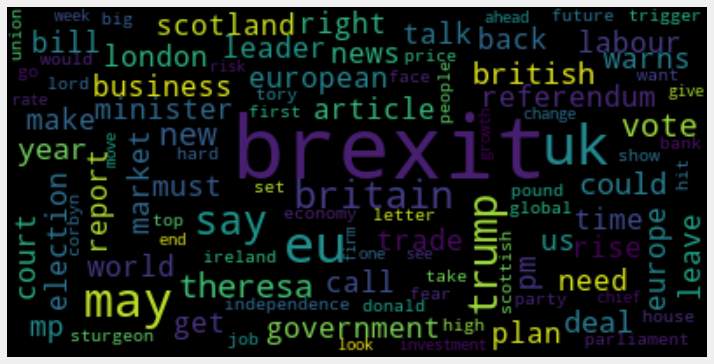

In [ ]:
plot_wordcloud(cnt_tok_title)

In [ ]:
news_model.save("dataset/news.model")

In [ ]:
news_model = Word2Vec.load("dataset/news.model")

In [ ]:
print(news_model.wv.most_similar(positive=['brexit', 'leave'], negative=['exit'], topn=6))

[('remain', 0.5384315252304077), ('yes', 0.5150514841079712), ('stay', 0.49710285663604736), ('ignore', 0.4573605954647064), ('alienate', 0.45497703552246094), ('referendum', 0.4485694169998169)]


In [ ]:
sim_words

[('coalition', 0.6080808043479919),
 ('faction', 0.580950140953064),
 ('candidate', 0.5629749894142151),
 ('ukip', 0.5583848357200623),
 ('opposition', 0.5567227602005005),
 ('opponent', 0.5446369647979736),
 ('snp', 0.5276675820350647),
 ('moderate', 0.5045008659362793),
 ('pvv', 0.5034576654434204),
 ('spd', 0.48373866081237793)]

In [ ]:
cnt_tok = Counter()
for list_token in article_tokens:
    for token in list_token:
         cnt_tok[token] += 1
cnt_tok.most_common(20)

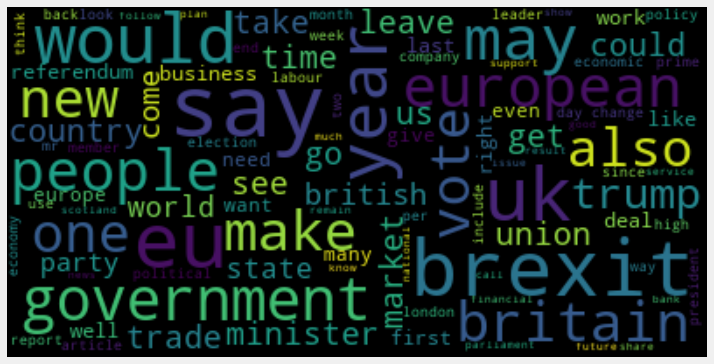

In [ ]:
plot_wordcloud(cnt_tok)

## NER

In [ ]:
cleaned_art_ner = cleaning_up_no_token(articles)

0        Source: Obama Interfered in the Brexit Vote, N...
1        Departing UK envoy to EU attacks Theresa May's...
2        Britain's ambassador to the European Union has...
3        Current situation – exports\n\nPork exports ha...
4        Manufacturing output has been expanding for th...
                               ...                        
27003    Keyword\n\nCompany\n\nEPIC/TIDM\n\nSEDOL/ISIN\...
27004    Labour politician Andy Burnham is becoming “a ...
27005    Published on Dec 12 2016 2:30 PM in Retail tag...
27006    Shadow home secretary Diane Abbott says Labour...
27007    EU nationals already living in the UK at the p...
Name: text, Length: 23053, dtype: object
CLEANING...
---CLEANED---


In [ ]:
tot_entities=[]


temp= []
i = 0
for text in cleaned_art_ner:
  print(i)
  article = nlp(text)
  tot_entities.append(article.ents)
  i = i+1
  '''
  ent_obj = []
  for ent in article.ents:
      ent_obj.append({"ent_text": ent.text, "ent_label":ent.label_})
  temp.append(ent_obj)
  i = i+1
train_news_link["entita"] = temp
'''
'''
tot_entities=[]
temp= []
for i in range(0, len(train_news_link.testo)):
  text = train_news_link.testo[i]
  article = nlp(str(text))
  tot_entities.append(article.ents)
  ent_obj = []
  for ent in article.ents:
      ent_obj.append({"ent_text": ent.text, "ent_label":ent.label_})
  temp.append(ent_obj)
train_news_link["entita"] = temp
'''
#train_news_link["entita"] = [{"ent_text": ent.text, "ent_label":ent.label_} for ent in train_news_link.testo]

In [ ]:
len(tot_entities)

23053

In [ ]:
train_news_link["entita"] = tot_entities

In [ ]:
train_news_link.to_csv("train_with_entities.csv")

In [ ]:
cnt_name = Counter()
for ent in tot_entities:
    for e in ent:
        cnt_name[e.text] += 1
cnt_name.most_common(10)

[('EU', 69916),
 ('Brexit', 67056),
 ('UK', 58407),
 ('Britain', 34460),
 ('British', 20529),
 ('Europe', 17976),
 ('May', 16243),
 ('US', 14359),
 ('London', 13797),
 ('first', 13771)]

In [ ]:
cnt_labels = Counter()
for ent in tot_entities:
    cnt_labels[ent["ent_label"]] += 1
cnt_labels.most_common()

In [ ]:
##PERSON
cnt_person = Counter()
for ent in tot_entities:
    for e in ent:
        if e.label_ == "PERSON":
            cnt_person[e.text] += 1
cnt_person.most_common()

In [ ]:
df_person =pd.DataFrame.from_records(list(dict(cnt_person).items()), columns=['name','count'])
df_person =  df_person.sort_values("count", ascending=False)
df_person.to_csv("dataset/df_person.csv")

In [ ]:
df_person.head()

name  count
8          Brexit  66695
126         Trump   8081
3    Donald Trump   5702
15        Theresa   2628
70        Mrs May   2187

In [ ]:
##GPE
cnt_gpe = Counter()
for ent in tot_entities:
    for e in ent:
        if e.label_ == "GPE":
            cnt_gpe[e.text] += 1
cnt_gpe.most_common(10)

[('UK', 58407),
 ('Britain', 34460),
 ('US', 14359),
 ('London', 13789),
 ('Scotland', 13020),
 ('Theresa', 7006),
 ('U.S.', 6946),
 ('Germany', 6194),
 ('France', 5990),
 ('China', 5943)]

In [ ]:
df_gpe =pd.DataFrame.from_records(list(dict(cnt_gpe).items()), columns=['name','count'])
df_gpe =  df_gpe.sort_values("count", ascending=False)
df_gpe.to_csv("dataset/df_gpe.csv")

In [ ]:
##ORG
cnt_org = Counter()
for ent in tot_entities:
    for e in ent:
        if e.label_ == "ORG":
            cnt_org[e.text] += 1
cnt_org.most_common(10)

[('EU', 68559),
 ('the European Union', 12226),
 ('Trump', 5359),
 ('Parliament', 5073),
 ('Trump’s', 3101),
 ('BBC', 2945),
 ('SNP', 2779),
 ('Reuters', 2687),
 ('Remain', 1847),
 ('NATO', 1813)]

In [ ]:
df_org =pd.DataFrame.from_records(list(dict(cnt_org).items()), columns=['name','count'])
df_org =  df_org.sort_values("count", ascending=False)
df_org.to_csv("dataset/df_org.csv")

In [ ]:
##LOC
cnt_loc = Counter()
for ent in tot_entities:
    for e in ent:
        if e.label_ == "LOC":
            cnt_loc[e.text] += 1
cnt_loc.most_common(10)

[('Europe', 17975),
 ('Asia', 1082),
 ('Africa', 818),
 ('the Middle East', 813),
 ('West', 615),
 ('North', 465),
 ('Atlantic', 407),
 ('North America', 359),
 ('Earth', 322),
 ('Gulf', 259)]

In [ ]:
df_loc =pd.DataFrame.from_records(list(dict(cnt_loc).items()), columns=['name','count'])
df_loc =  df_loc.sort_values("count", ascending=False)
df_loc.to_csv("dataset/df_loc.csv")

### with newspaper3k

In [ ]:
train_news_link = pd.read_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/news_train_less.csv")
train_news_link = train_news_link.drop(columns='Unnamed: 0')

In [ ]:
train_news_link['keywords']

0        ['referendum', 'putin', 'vote', 'meddling', 'r...
1        ['prime', 'eu', 'theresa', 'mays', 'departing'...
2        ['eu', 'resigns', 'expected', 'talks', 'ambass...
3        ['eu', 'market', 'exports', 'mean', 'meat', 'u...
4        ['hit', 'weakness', 'manufacturing', 'shrugs',...
                               ...                        
27003    ['report', 'health', 'period', 'animal', '000'...
27004    ['farage', 'stupid', 'nobel', 'version', 'pale...
27005    ['brexit', 'beighton', 'company', 'boosts', 'u...
27006    ['brexit', 'polls', 'party', 'voted', 'freedom...
27007    ['report', 'future', 'brexit', 'seeks', 'clari...
Name: keywords, Length: 27008, dtype: object

In [ ]:
def convert_string_list(key):
  finaltxt = []
  for p in key:
    wordsList_punt = [w for w in p if not w in punctuation]
    final = ''.join(word for word in wordsList_punt)
    final = final.replace(" ", "")
    #print(final)
    finaltxt.append(final)
  return finaltxt

In [ ]:
for i in range(len(train_news_link)):
  #print(i)
  prova = train_news_link['keywords'][i]
  prova = prova[2:-2]
  prova = list(prova.split(','))
  train_news_link['keywords'][i] = convert_string_list(prova)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
keywords = train_news_link['keywords'].values.tolist()

In [ ]:
keywords_list = [eval(str_k) for str_k in keywords]
keywords_list

In [ ]:
def get_counter(series):
  flat_list = [item for sublist in series for item in sublist]
  c = Counter(flat_list)
  return c

In [ ]:
key_words = get_counter(keywords_list).most_common()
key_words[:20]

[('brexit', 12414),
 ('uk', 8660),
 ('eu', 7619),
 ('european', 3811),
 ('vote', 3414),
 ('trump', 2955),
 ('britain', 2886),
 ('trade', 2539),
 ('union', 2280),
 ('british', 2239),
 ('world', 2197),
 ('minister', 2017),
 ('market', 1972),
 ('referendum', 1930),
 ('deal', 1657),
 ('theresa', 1588),
 ('party', 1517),
 ('2016', 1505),
 ('political', 1491),
 ('scotland', 1458)]

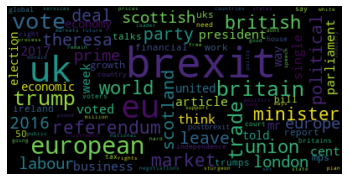

In [ ]:
plot_wordcloud(key_words)

 ## URL 

trovo la radice degli URL e la loro "sede"

In [ ]:
new_train = pd.read_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/news_train_less.csv")
new_train = new_train.drop(columns='Unnamed: 0')

In [ ]:
#urls = train_news_link["url"]
urls = new_train["url"]
urls

In [ ]:
urls_parse = [urlparse(u).netloc for u in urls]

In [ ]:
urls_parse_groupby = Counter(urls_parse)
#urls_parse_groupby.most_common(10)
#len(urls_parse_groupby)
urls_parse_groupby_DF = pd.DataFrame(np.array(urls_parse_groupby.most_common()),columns=['url','occorrences'])

In [ ]:
urls_unique = urls_parse_groupby_DF['url'].values.tolist()
urls_unique

['www.dailymail.co.uk',
 'www.theguardian.com',
 'www.heraldscotland.com',
 'www.thetimes.co.uk',
 'www.thesun.co.uk',
 'www.independent.co.uk',
 'www.express.co.uk',
 'www.thenational.scot',
 'www.latestnigeriannews.com',
 'www.reuters.com',
 'www.telegraph.co.uk',
 'www.irishexaminer.com',
 'www.independent.ie',
 'www.cityam.com',
 'www.scotsman.com',
 'www.bbc.co.uk',
 'uk.businessinsider.com',
 'www.ibtimes.co.uk',
 'news.sky.com',
 'uk.reuters.com',
 'www.politico.eu',
 'www.yorkshirepost.co.uk',
 'www.belfasttelegraph.co.uk',
 'www.businessinsider.com',
 'www.mirror.co.uk',
 'www.themalaymailonline.com',
 'www.yahoo.com',
 'www.business-standard.com',
 'www.huffingtonpost.co.uk',
 'medium.com',
 'uk.news.yahoo.com',
 'www.newsoneplace.com',
 'www.intellasia.net',
 'blogs.lse.ac.uk',
 'www.reddit.com',
 'www.eurasiareview.com',
 'www.ft.com',
 'in.reuters.com',
 'uk.finance.yahoo.com',
 'www.thisismoney.co.uk',
 'inews.co.uk',
 'voxpoliticalonline.com',
 'www.breitbart.com',
 'www

#### geolite2

In [ ]:
def origin(ip, domain_str, result):
    urls_parse_groupby_DF['origin'][count] = result
    urls_parse_groupby_DF['ip'][count] = ip
    #print("{0} [{1}]: {2}".format(domain_str.strip(), ip, result))

def getip(domain_str):
    #print("domain_str: ",domain_str)
    if (domain_str.strip()[:3] != 'www'):
      domain_str = 'www.'+domain_str
    #print("domain_str: ",domain_str)
    try: 
      ip = socket.gethostbyname(domain_str.strip())
      reader = geolite2.reader()      
      output = reader.get(ip)
      if (domain_str.strip()[-2:] == 'uk'):
        result = 'GB'
      else:
        result = output['country']['iso_code']
      origin(ip, domain_str, result)
    except:
      error.append(count)    

error = []
count = -1
urls_parse_groupby_DF['origin'] = ""
urls_parse_groupby_DF['ip'] = ""
for domain_str in urls_unique:
    count = count +1
    try:
        getip(domain_str)
    except socket.error as msg:
        print("{0} [could not resolve]".format(domain_str.strip())) 
        if len(domain_str) > 2:
            subdomain = domain_str.split('.', 1)[1]
            try:
                getip(subdomain)
            except:
                error.append(count)
                continue

geolite2.close()

In [ ]:
urls_parse_groupby_DF.to_csv('/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/urls_parse_groupby_DF.csv')

In [ ]:
urls_parse_groupby_DF = pd.read_csv('/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/urls_parse_groupby_DF.csv')
urls_parse_groupby_DF = urls_parse_groupby_DF.drop(columns='Unnamed: 0')
urls_parse_groupby_DF

url  occorrences  ...   orientation               party
0        www.dailymail.co.uk          983  ...    Right-wing  Conservative Party
1        www.theguardian.com          874  ...   Centre-left        Labour Party
2     www.heraldscotland.com          772  ...      Centrist                 NaN
3         www.thetimes.co.uk          756  ...  Centre-right  Conservative Party
4           www.thesun.co.uk          567  ...    Right-wing  Conservative Party
...                      ...          ...  ...           ...                 ...
4592            carigold.com            1  ...           NaN                 NaN
4593        transienteye.com            1  ...           NaN                 NaN
4594         politickles.com            1  ...           NaN                 NaN
4595         www.rlb-law.com            1  ...           NaN                 NaN
4596    www.visionmonday.com            1  ...           NaN                 NaN

[4597 rows x 6 columns]

In [ ]:
urls_parse_groupby_origin = Counter(urls_parse_groupby_DF["origin"].values.tolist())

In [ ]:
urls_parse_groupby_origin.most_common()

### Partito politico

#### Distinguo gli allineamenti politici dei siti

In [ ]:
urls_parse_groupby_DF['orientation'] = ""
urls_parse_groupby_DF['party'] = ""

In [ ]:
urls_parse_groupby_DF['orientation'][0] = "Right-wing"
urls_parse_groupby_DF['party'][0] = "Conservative Party"
urls_parse_groupby_DF['orientation'][1] = "Right-wing"
urls_parse_groupby_DF['party'][1] = "Conservative Party"
urls_parse_groupby_DF['orientation'][2] = "Centre-right"
urls_parse_groupby_DF['party'][2] = "Conservative Party"
urls_parse_groupby_DF['orientation'][3] = "Centre-left"
urls_parse_groupby_DF['party'][3] = "Labour Party"
urls_parse_groupby_DF['orientation'][4] = "Right-wing"
urls_parse_groupby_DF['party'][4] = "Conservative Party"
urls_parse_groupby_DF['orientation'][5] = "Centrist"
urls_parse_groupby_DF['orientation'][8] = "Right-wing"
urls_parse_groupby_DF['party'][8] = "Conservative Party"
urls_parse_groupby_DF['orientation'][9] = "Center-left"
urls_parse_groupby_DF['party'][9] = "Scottish National Party"
urls_parse_groupby_DF['orientation'][11] = "Moderate"
urls_parse_groupby_DF['orientation'][13] = "Centrist"
urls_parse_groupby_DF['orientation'][16] = "Right-wing"
urls_parse_groupby_DF['orientation'][16] = "Centre-right"
urls_parse_groupby_DF['orientation'][21] = "Right wing"
urls_parse_groupby_DF['orientation'][27] = "Centrism"
urls_parse_groupby_DF['orientation'][30] = "Centre-left"	
urls_parse_groupby_DF['party'][30] = "Labour Party"
urls_parse_groupby_DF['orientation'][41] = "Centre-left"	
urls_parse_groupby_DF['party'][41] = "Labour Party"
urls_parse_groupby_DF['orientation'][63] = "Centrism"

In [ ]:
urls_parse_groupby_DF[12] = "liberal and progressive"

In [ ]:
news_with_orientation = urls_parse_groupby_DF[urls_parse_groupby_DF['orientation'] != ""]
news_with_orientation.dropna(subset=['orientation'], inplace=True)
news_with_orientation.reset_index(drop=True, inplace=True)#rimette gli index con un ordine corretto
news_with_orientation

url  ...                    party
0          www.dailymail.co.uk  ...       Conservative Party
1          www.theguardian.com  ...             Labour Party
2       www.heraldscotland.com  ...                      NaN
3           www.thetimes.co.uk  ...       Conservative Party
4             www.thesun.co.uk  ...       Conservative Party
5            www.express.co.uk  ...       Conservative Party
6         www.thenational.scot  ...  Scottish National Party
7          www.telegraph.co.uk  ...       Conservative Party
8        www.irishexaminer.com  ...                      NaN
9           www.independent.ie  ...                      NaN
10            www.scotsman.com  ...                      NaN
11  www.belfasttelegraph.co.uk  ...                      NaN
12            www.mirror.co.uk  ...             Labour Party
13  www.themalaymailonline.com  ...                      NaN
14                  www.ft.com  ...                      NaN
15        www.newstatesman.com  ...             Labour Party

[16 rows x 6 columns]

In [ ]:
# newspaper di destra
news_right = [news[1]['url'] for news in news_with_orientation.iterrows() if news[1]['orientation'] == "Right-wing"]
print("newspaper di destra",news_right)
#newspaper di centro destra
news_right_center = [news[1]['url'] for news in news_with_orientation.iterrows() if news[1]['orientation'] == "Centre-right"]
print("newspaper di centro-destra",news_right_center)
#newspaper di centro sinistra
news_left_center = [news[1]['url'] for news in news_with_orientation.iterrows() if news[1]['orientation'] == "Centre-left"]
print("newspaper di centro-sinistra",news_left_center)
#newspaper di centro 
news_center = [news[1]['url'] for news in news_with_orientation.iterrows() if news[1]['orientation'] == "Centrist"]
print("newspaper di centro",news_center)


newspaper di destra ['www.dailymail.co.uk', 'www.thesun.co.uk', 'www.express.co.uk', 'www.telegraph.co.uk']
newspaper di centro-destra ['www.thetimes.co.uk', 'www.independent.ie']
newspaper di centro-sinistra ['www.theguardian.com', 'www.mirror.co.uk', 'www.newstatesman.com']
newspaper di centro ['www.heraldscotland.com', 'www.irishexaminer.com']


#### Creo i dataframe per orientamento politico

con le colonne: article,authors,count,date,date_f,text,url,title,keywords,afinn

In [ ]:
new_train = pd.read_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/news_train_less.csv")
new_train = new_train.drop(columns='Unnamed: 0')

In [ ]:
articles_DF = pd.read_csv('/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/articles_DF.csv')
articles_DF = articles_DF.drop(columns='Unnamed: 0')
print(articles_DF)

                                                      txt  ... affin
0       source: obama interfered in the brexit vote, n...  ...  -4.0
1       for the last few months, we have been told tha...  ...  -3.0
2       in the us, after the success of donald trump i...  ...   0.0
3       hillary clinton, barack obama and certain elem...  ...   5.0
4       as is the case with numerous other allegations...  ...  -2.0
...                                                   ...  ...   ...
842707  it is also essential to avoid major disruption...  ...   0.0
842708  we call on theresa may to take this opportunit...  ...   2.0
842709        we are not bargaining chips, we are people.  ...   0.0
842710  “we are also positive regarding the suggestion...  ...   3.0
842711                                      FINE ARTICOLO  ...   NaN

[842712 rows x 3 columns]


In [ ]:
id = articles_DF[articles_DF['txt'] == "FINE ARTICOLO"].index

In [ ]:
def tot_afinn_article(all_i , row):  
  afinn_score = 0
  #print(new_train[new_train['url'] == row['url']])
  #print(new_train[new_train['url'] == row['url']].index[0])
  index = new_train[new_train['url'] == row['url']].index[0]
  if (index == 1):
    start = 0
    end = all_i[index-1]
    article = articles_DF[start:end]
  else:
    start = all_i[index-2]
    end = all_i[index-1]
    article = articles_DF[start+1:end]
  #print(article)
  afinn_score = article['affin'].sum()
  #if (afinn_score > 960):
  #  print(article['affin'])
  #  print(index)
  #  print(start, end)
  return afinn_score

In [ ]:
# ho trovato gli index dei giornali di destra
idxs_right = []
for news in news_right:
  idxs = []
  #print(news)
  idxs =  [i for i,e in enumerate(urls_parse) if e == news]
  idxs_right.append(idxs)

#flat della lista
idxs_right_flat = [item for sublist in idxs_right for item in sublist]
#creo il dataframe dei giornali di destra
Right_wing = new_train.iloc[idxs_right_flat,:]
#print(Right_wing.head())

# creo la somma delle sentence dello stesso articolo
tot_score = []
for row in Right_wing.iterrows():
  #print(row)
  sum = []
  sum = tot_afinn_article(id, row[1])
  tot_score.append(sum)
  #break
#print(tot_score)

#aggiungo la colonna di score
Right_wing['afinn'] = tot_score
Right_wing.head()
Right_wing.reset_index(drop=True, inplace=True)#rimette gli index con un ordine corretto

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
ulrs_parse_rv = Right_wing['url'].apply(lambda x: urlparse(x).netloc)
Right_wing['url_domain'] = ulrs_parse_rv
Right_wing.to_csv('/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/Right_wing.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
Right_wing.head()

article  ... compound
0  <newspaper.article.Article object at 0x7fd4ab8...  ...  -0.9476
1  <newspaper.article.Article object at 0x7fd49e8...  ...   0.9980
2  <newspaper.article.Article object at 0x7fd49d0...  ...   0.9953
3  <newspaper.article.Article object at 0x7fd49d1...  ...  -0.8781
4  <newspaper.article.Article object at 0x7fd49d1...  ...   0.9936

[5 rows x 13 columns]

In [ ]:
# ho trovato gli index dei giornali di centro destra
idxs_right_center = []
for news in news_right_center:
  idxs = []
  print(news)
  idxs =  [i for i,e in enumerate(urls_parse) if e == news]
  idxs_right_center.append(idxs)

#flat della lista
idxs_right_center_flat = [item for sublist in idxs_right_center for item in sublist]
#creo il dataframe dei giornali di destra
Right_center = new_train.iloc[idxs_right_center_flat,:]
print(Right_center.head())

# creo la somma delle sentence dello stesso articolo
tot_score = []
for row in Right_center.iterrows():
  sum = []
  sum = tot_afinn_article(id, row[1])
  tot_score.append(sum)
#print(tot_score)

#aggiungo la colonna di score
Right_center['afinn'] = tot_score
Right_center.head()
Right_center.reset_index(drop=True, inplace=True)#rimette gli index con un ordine corretto

www.thetimes.co.uk
www.independent.ie
                                                article  ...                                                url
140   <newspaper.article.Article object at 0x7fd49cf...  ...  http://www.thetimes.co.uk/article/companies-co...
464   <newspaper.article.Article object at 0x7fd49c7...  ...  http://www.thetimes.co.uk/article/we-cant-buy-...
1664  <newspaper.article.Article object at 0x7f80635...  ...  http://www.thetimes.co.uk/article/may-must-del...
1665  <newspaper.article.Article object at 0x7f80618...  ...  http://www.thetimes.co.uk/article/could-a-cros...
2333  <newspaper.article.Article object at 0x7f80605...  ...  http://www.thetimes.co.uk/article/ulster-exit-...

[5 rows x 9 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
ulrs_parse_rc = Right_center['url'].apply(lambda x: urlparse(x).netloc)
Right_center['url_domain'] = ulrs_parse_rc
Right_center.to_csv('/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/Right_center.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# ho trovato gli index dei giornali di centro sinistra
idxs_left_center = []
for news in news_left_center:
  idxs = []
  print(news)
  idxs =  [i for i,e in enumerate(urls_parse) if e == news]
  idxs_left_center.append(idxs)

#flat della lista
idxs_left_center_flat = [item for sublist in idxs_left_center for item in sublist]

#creo il dataframe dei giornali di destra
Left_center = new_train.iloc[idxs_left_center_flat,:]
print(Left_center.head())

# creo la somma delle sentence dello stesso articolo
tot_score = []
for row in Left_center.iterrows():
  sum = []
  sum = tot_afinn_article(id, row[1])
  tot_score.append(sum)
#print(tot_score)

#aggiungo la colonna di score
Left_center['afinn'] = tot_score
Left_center.head()
Left_center.reset_index(drop=True, inplace=True)#rimette gli index con un ordine corretto

www.theguardian.com
www.mirror.co.uk
www.newstatesman.com
                                               article  ...                                                url
39   <newspaper.article.Article object at 0x7fd49d7...  ...  https://www.theguardian.com/politics/2016/oct/...
42   <newspaper.article.Article object at 0x7fd49d2...  ...  https://www.theguardian.com/business/2016/jul/...
137  <newspaper.article.Article object at 0x7fd49d1...  ...  https://www.theguardian.com/environment/2016/j...
198  <newspaper.article.Article object at 0x7fd49e9...  ...  https://www.theguardian.com/environment/2016/j...
335  <newspaper.article.Article object at 0x7fd49ca...  ...  https://www.theguardian.com/business/2017/jan/...

[5 rows x 9 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
ulrs_parse_lc = Left_center['url'].apply(lambda x: urlparse(x).netloc)
Left_center['url_domain'] = ulrs_parse_lc
Left_center.to_csv('/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/Left_center.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# ho trovato gli index dei giornali di centro 
idxs_center = []
for news in news_center:
  idxs = []
  print(news)
  idxs =  [i for i,e in enumerate(urls_parse) if e == news]
  idxs_center.append(idxs)

#flat della lista
idxs_center_flat = [item for sublist in idxs_center for item in sublist]

#creo il dataframe dei giornali di destra
center_df = new_train.iloc[idxs_center_flat,:]
print(center_df.head())

# creo la somma delle sentence dello stesso articolo
tot_score = []
for row in center_df.iterrows():
  sum = []
  sum = tot_afinn_article(id, row[1])
  tot_score.append(sum)
#print(tot_score)

#aggiungo la colonna di score
center_df['afinn'] = tot_score
center_df.head()
center_df.reset_index(drop=True, inplace=True)#rimette gli index con un ordine corretto

www.heraldscotland.com
www.irishexaminer.com
                                               article  ...                                                url
9    <newspaper.article.Article object at 0x7fd49d9...  ...  http://www.heraldscotland.com/News/15000159.PM...
127  <newspaper.article.Article object at 0x7fd49d1...  ...  http://www.heraldscotland.com/news/15002378._T...
233  <newspaper.article.Article object at 0x7fd49e9...  ...  http://www.heraldscotland.com/news/15003988.PM...
243  <newspaper.article.Article object at 0x7fd49cd...  ...  http://www.heraldscotland.com/news/homenews/15...
304  <newspaper.article.Article object at 0x7fd49ce...  ...  http://www.heraldscotland.com/politics/1500398...

[5 rows x 9 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
ulrs_parse_c = center_df['url'].apply(lambda x: urlparse(x).netloc)
center_df['url_domain'] = ulrs_parse_c
center_df.to_csv('/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/center_df.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Apply Preprocessing for sentiment analysis

In [ ]:
cleaned_articles = cleaning_up(articles)
# cleaned_articles = clean_data(cleaned_article)
cleaned_articles

In [ ]:
cleaned_articles[1]

In [ ]:
art_lemmatized = lemmatization(cleaned_articles)

In [ ]:
art_lemmatized

In [ ]:
import spacy
import pandas as pd
import os
import sys


import en_core_web_lg


In [ ]:
nltk.download('vader_lexicon')
nlp = en_core_web_lg.load()
# nlp= spacy.load('en_core_web_lg')

In [ ]:
cleaned_articles[4]

## Sentiment Analysis

### Afinn 

In [ ]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [ ]:
############# QUI CREO IL DATAFRAME
articles_DF = pd.DataFrame(columns=['txt','entity','afinn'])
count = -1
for sentList in TotsentList:
  count = count +1
  for sent in sentList:
    #print(txt)
    prova = []
    prova.append(sent)
    sentiment = afinn.score(sent)
    sent = preprocess(sent)
    nomi = [elem[0] for elem in sent if 'NN' in elem[1]]
    #nomi = set(nomi)
    prova.append(nomi)
    #print(nomi)
    prova.append(sentiment)
    #print("prova", prova)
    prova = pd.DataFrame([prova],columns=articles_DF.columns)
    #print("prova", prova)
    articles_DF = articles_DF.append(prova,ignore_index=True)
  a_series = pd.Series(["FINE ARTICOLO", "",""], index = articles_DF.columns)
  articles_DF = articles_DF.append(a_series,ignore_index=True)
  if (count%100 == 0):
    print(count)
  if (count%1000 == 0):
    articles_DF.to_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/articles_DF.csv")
articles_DF.to_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/articles_DF.csv")

In [ ]:
articles_DF = pd.read_csv('/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/articles_DF.csv')
articles_DF = articles_DF.drop(columns='Unnamed: 0')
articles_DF

In [ ]:
articles_DF_withoutNan = pd.DataFrame.copy(articles_DF)
articles_DF_withoutNan.dropna(subset = ["entity"], inplace=True)
articles_DF_withoutNan.reset_index(drop=True, inplace=True)#rimette gli index con un ordine corretto

In [ ]:
for i in range(len(articles_DF_withoutNan)):
  #print(i)
  prova = articles_DF_withoutNan['entity'][i]
  prova = prova[2:-2]
  prova = list(prova.split(','))
  articles_DF_withoutNan['entity'][i] = convert_string_list(prova)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
entity = articles_DF_withoutNan['entity'].values.tolist()

In [ ]:
stop_words = set(stopwords.words('english'))
entities = []
for ent in entity:
  taggedList = []
  for e in ent:
    if not e in stop_words:
      if not e in punctuation:
        taggedList.append(e)
  entities.append(taggedList)

In [ ]:
get_counter(entities).most_common(10)

In [ ]:
for row in articles_DF_withoutNan.iterrows():
  ent = type(row[1]['entity'])
  if ent != list:
    print("error")

In [ ]:
print(articles_DF_withoutNan['entity'][0])
print(type(articles_DF_withoutNan['entity'][0]))

['source', 'obama', 'brexit', 'vote', 'outlook', 'journalneoorg', 'steven', 'macmillan', 'passing', 'day', 'hysteria', 'world']
<class 'list'>


In [ ]:
articles_DF_withoutNan.to_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/articles_DEF_list.csv")

### Vader

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
new_train = pd.read_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/news_train_less.csv")
new_train = new_train.drop(columns='Unnamed: 0')
new_train.head(2)

article  ...                                                url
0  <newspaper.article.Article object at 0x7fd49d7...  ...  https://talesfromtheloublog.wordpress.com/2017...
1  <newspaper.article.Article object at 0x7fd4ab8...  ...  http://www.dailymail.co.uk/wires/ap/article-40...

[2 rows x 9 columns]

In [ ]:
count = -1
vader_ss = []
for rows in new_train.iterrows():
  count = count+1
  row = rows[1]
  txt = row["text"]
  ss = sid.polarity_scores(txt)
  vader_ss.append(ss)
  if (count%2000 == 0):
    print(count)

In [ ]:
new_train['vader'] = vader_ss

In [ ]:
compounds =[row[1]['vader']['compound'] for row in new_train.iterrows()]

In [ ]:
new_train['compound'] = compounds

In [ ]:
new_train.to_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/news_train_less_vader.csv")

## Aspect Extraction 

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
sid = SentimentIntensityAnalyzer()



def find_sentiment8(doc):
    sentences = list(doc.sents)
  
    # find roots of all entities in the text
    ner_heads = {ent.root.idx: ent for ent in doc.ents}

    aspects = []
    rule1_pairs = []
    rule2_pairs = []
    rule4_pairs = []
    rule6_pairs = []
    rule5_pairs = []
    rule3_pairs = []
    rule7_pairs = []
    rule8_pairs = []

    for sentence in sentences:
        print(sentence)
        for token in sentence:
            children = token.children
            A = "999999"
            M = "999999"
            add_neg_pfx = False
            for child in children:
                if(child.dep_ == "nsubj" and not child.is_stop): # nsubj is nominal subject
                    if child.idx in ner_heads:
                        A = ner_heads[child.idx].text
                    else:
                        A = child.text
                if(child.dep_ == "acomp" and not child.is_stop): # acomp is adjectival complement
                    M = child.text
                # example - 'this could have been better' -> (this, not better)
                if(child.dep_ == "aux" and child.tag_ == "MD"): # MD is modal auxiliary
                    neg_prefix = "not"
                    add_neg_pfx = True
                if(child.dep_ == "neg"): # neg is negation
                    neg_prefix = child.text
                    add_neg_pfx = True
            if (add_neg_pfx and M != "999999"):
                M = neg_prefix + " " + M
            if(A != "999999" and M != "999999"):
                rule8_pairs.append((A, M, sid.polarity_scores(M)))
   
        
        for token in sentence:
            A = "999999"
            M = "999999"
            if token.dep_ == "amod" and not token.is_stop:
                M = token.text
                A = token.head.text

                # add adverbial modifier of adjective (e.g. 'most comfortable headphones')
                M_children = token.children
                for child_m in M_children:
                    if(child_m.dep_ == "advmod"):
                        M_hash = child_m.text
                        M = M_hash + " " + M
                        break

                # negation in adjective, the "no" keyword is a 'det' of the noun (e.g. no interesting characters)
                A_children = token.head.children
                for child_a in A_children:
                    if(child_a.dep_ == "det" and child_a.text == 'no'):
                        neg_prefix = 'not'
                        M = neg_prefix + " " + M
                        break

            if(A != "999999" and M != "999999"):
                rule1_pairs.append((A, M,sid.polarity_scores(token.text),1))

        ## SECOND RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        #Direct Object - A is a child of something with relationship of nsubj, while
        # M is a child of the same something with relationship of dobj
        #Assumption - A verb will have only one NSUBJ and DOBJ

        rule2_pairs = []
        for token in sentence:
            children = token.children
            A = "999999"
            M = "999999"
            add_neg_pfx = False
            for child in children :
                if(child.dep_ == "nsubj" and not child.is_stop):
                    A = child.text
                    # check_spelling(child.text)

                if((child.dep_ == "dobj" and child.pos_ == "ADJ") and not child.is_stop):
                    M = child.text
                    #check_spelling(child.text)

                if(child.dep_ == "neg"):
                    neg_prefix = child.text
                    add_neg_pfx = True

        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M

            if(A != "999999" and M != "999999"):
                rule2_pairs.append((A, M,sid.polarity_scores(M),2))


        ## THIRD RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## Adjectival Complement - A is a child of something with relationship of nsubj, while
        ## M is a child of the same something with relationship of acomp
        ## Assumption - A verb will have only one NSUBJ and DOBJ
        ## "The sound of the speakers would be better. The sound of the speakers could be better" - handled using AUX dependency



        rule3_pairs = []

        for token in sentence:

            children = token.children
            A = "999999"
            M = "999999"
            add_neg_pfx = False
            for child in children :
                if(child.dep_ == "nsubj" and not child.is_stop):
                    A = child.text
                    # check_spelling(child.text)

                if(child.dep_ == "acomp" and not child.is_stop):
                    M = child.text

                # example - 'this could have been better' -> (this, not better)
                if(child.dep_ == "aux" and child.tag_ == "MD"):
                    neg_prefix = "not"
                    add_neg_pfx = True

                if(child.dep_ == "neg"):
                    neg_prefix = child.text
                    add_neg_pfx = True

            if (add_neg_pfx and M != "999999"):
                M = neg_prefix + " " + M
                    #check_spelling(child.text)

            if(A != "999999" and M != "999999"):
                rule3_pairs.append((A, M, sid.polarity_scores(M),3))

        ## FOURTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect

        #Adverbial modifier to a passive verb - A is a child of something with relationship of nsubjpass, while
        # M is a child of the same something with relationship of advmod

        #Assumption - A verb will have only one NSUBJ and DOBJ

        rule4_pairs = []
        for token in sentence:


            children = token.children
            A = "999999"
            M = "999999"
            add_neg_pfx = False
            for child in children :
                if((child.dep_ == "nsubjpass" or child.dep_ == "nsubj") and not child.is_stop):
                    A = child.text
                    # check_spelling(child.text)

                if(child.dep_ == "advmod" and not child.is_stop):
                    M = child.text
                    M_children = child.children
                    for child_m in M_children:
                        if(child_m.dep_ == "advmod"):
                            M_hash = child_m.text
                            M = M_hash + " " + child.text
                            break
                    #check_spelling(child.text)

                if(child.dep_ == "neg"):
                    neg_prefix = child.text
                    add_neg_pfx = True

            if (add_neg_pfx and M != "999999"):
                M = neg_prefix + " " + M

            if(A != "999999" and M != "999999"):
                rule4_pairs.append((A, M,sid.polarity_scores(M),4)) # )


        ## FIFTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect

        #Complement of a copular verb - A is a child of M with relationship of nsubj, while
        # M has a child with relationship of cop

        #Assumption - A verb will have only one NSUBJ and DOBJ

        rule5_pairs = []
        for token in sentence:
            children = token.children
            A = "999999"
            buf_var = "999999"
            for child in children :
                if(child.dep_ == "nsubj" and not child.is_stop):
                    A = child.text
                    # check_spelling(child.text)

                if(child.dep_ == "cop" and not child.is_stop):
                    buf_var = child.text
                    #check_spelling(child.text)

            if(A != "999999" and buf_var != "999999"):
                rule5_pairs.append((A, token.text,sid.polarity_scores(token.text),5))


        ## SIXTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## Example - "It ok", "ok" is INTJ (interjections like bravo, great etc)


        rule6_pairs = []
        for token in sentence:
            children = token.children
            A = "999999"
            M = "999999"
            if(token.pos_ == "INTJ" and not token.is_stop):
                for child in children :
                    if(child.dep_ == "nsubj" and not child.is_stop):
                        A = child.text
                        M = token.text
                        # check_spelling(child.text)

            if(A != "999999" and M != "999999"):
                rule6_pairs.append((A, M,sid.polarity_scores(M),6))


        ## SEVENTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## ATTR - link between a verb like 'be/seem/appear' and its complement
        ## Example: 'this is garbage' -> (this, garbage)

        rule7_pairs = []
        for token in sentence:
            children = token.children
            A = "999999"
            M = "999999"
            add_neg_pfx = False
            for child in children :
                if(child.dep_ == "nsubj" and not child.is_stop):
                    A = child.text
                    # check_spelling(child.text)

                if((child.dep_ == "attr") and not child.is_stop):
                    M = child.text
                    #check_spelling(child.text)

                if(child.dep_ == "neg"):
                    neg_prefix = child.text
                    add_neg_pfx = True

            if (add_neg_pfx and M != "999999"):
                M = neg_prefix + " " + M

            if(A != "999999" and M != "999999"):
                rule7_pairs.append((A, M,sid.polarity_scores(M),7))

    aspects = rule1_pairs + rule2_pairs + rule3_pairs +rule4_pairs +rule5_pairs + rule6_pairs + rule7_pairs + rule8_pairs
    #print(rule3_pairs)
    
    return aspects 
     
#print(find_sentiment(nlp(cleaned_articles[0])))

#print(find_sentiment(nlp("Air France is cool.")))
#print(find_sentiment(nlp("I think Gabriel García Márquez is not bor      print(sentence)ing.")))
#print(find_sentiment(nlp("They say Central African Republic is really great. ")))

In [ ]:
aspetti = []
for article in art_lemmatized:
  print(article)
  aspetti.append(find_sentiment8(nlp(article)))

In [ ]:
train_news_link["aspetti"] = aspetti

In [ ]:
train_news_link.to_csv("brexit.csv")

In [ ]:
train_news_link = pd.read_csv("brexit.csv")

In [ ]:
train_news_link

Unnamed: 0  Unnamed: 0.1  \
0               0             0   
1               1             1   
2               2             2   
3               3             3   
4               4             4   
...           ...           ...   
23048       27003         27003   
23049       27004         27004   
23050       27005         27005   
23051       27006         27006   
23052       27007         27007   

                                                 article  \
0      <newspaper.article.Article object at 0x7fd49d7...   
1      <newspaper.article.Article object at 0x7fd4ab8...   
2      <newspaper.article.Article object at 0x7fd49d7...   
3      <newspaper.article.Article object at 0x7fd49d8...   
4      <newspaper.article.Article object at 0x7fd49d8...   
...                                                  ...   
23048  <newspaper.article.Article object at 0x7f55430...   
23049  <newspaper.article.Article object at 0x7f5542e...   
23050  <newspaper.article.Article object at 0x7f5542e...   
23051  <newspaper.article.Article object at 0x7f5542f...   
23052  <newspaper.article.Article object at 0x7f5542f...   

                                                 authors  count  \
0                                                     []    1.0   
1                                   ['Associated Press']    1.0   
2                                                     []    1.0   
3                                        ['Lucy Towers']    1.0   
4                                                     []    1.0   
...                                                  ...    ...   
23048                                                 []    1.0   
23049                                                 []    1.0   
23050                                   ['Esm Magazine']    1.0   
23051  ['Diane Abbott', 'Labour Will Close Gap In Pol...    1.0   
23052                                                 []    1.0   

                            date      date_f  \
0      2017-01-04 13:57:11+00:00  2017-01-04   
1      2017-01-04 09:36:24+00:00  2017-01-04   
2      2017-01-04 10:47:17+00:00  2017-01-04   
3      2017-01-04 07:36:35+00:00  2017-01-04   
4      2017-01-04 06:53:28+00:00  2017-01-04   
...                          ...         ...   
23048  2016-12-12 07:48:09+00:00  2016-12-12   
23049  2016-12-12 12:45:00+00:00  2016-12-12   
23050  2016-12-12 14:30:25+00:00  2016-12-12   
23051  2016-12-12 10:18:01+00:00  2016-12-12   
23052  2016-12-12 12:23:38+00:00  2016-12-12   

                                                keywords  \
0      ['referendum', 'putin', 'vote', 'meddling', 'r...   
1      ['prime', 'eu', 'theresa', 'mays', 'departing'...   
2      ['eu', 'resigns', 'expected', 'talks', 'ambass...   
3      ['eu', 'market', 'exports', 'mean', 'meat', 'u...   
4      ['hit', 'weakness', 'manufacturing', 'shrugs',...   
...                                                  ...   
23048  ['report', 'health', 'period', 'animal', '000'...   
23049  ['farage', 'stupid', 'nobel', 'version', 'pale...   
23050  ['brexit', 'beighton', 'company', 'boosts', 'u...   
23051  ['brexit', 'polls', 'party', 'voted', 'freedom...   
23052  ['report', 'future', 'brexit', 'seeks', 'clari...   

                                                    text  \
0      Source: Obama Interfered in the Brexit Vote, N...   
1      Departing UK envoy to EU attacks Theresa May's...   
2      Britain's ambassador to the European Union has...   
3      Current situation – exports\n\nPork exports ha...   
4      Manufacturing output has been expanding for th...   
...                                                  ...   
23048  Keyword\n\nCompany\n\nEPIC/TIDM\n\nSEDOL/ISIN\...   
23049  Labour politician Andy Burnham is becoming “a ...   
23050  Published on Dec 12 2016 2:30 PM in Retail tag...   
23051  Shadow home secretary Diane Abbott says Labour...   
23052  EU nationals already living in the UK at the p...   

                                         

In [ ]:
asp_json = []

j = 0
for aspect in train_news_link["aspetti"]:
    temp = []
    print(j)
    aspect = eval(aspect)
    for asp in aspect:
        aspetto = {
                        "aspetto": "",
                        "desc": "",
                        "sentiment": "",
                        "index": 0,
                        "regola": 0
                    }
        aspetto["aspetto"] = asp[0] 
        aspetto["desc"] = asp[1]
        aspetto["sentiment"] = asp[2]
        aspetto["index"] = j
        if len(asp) == 4:
            aspetto["regola"] = asp[3]
        else:
            aspetto["regola"] = 8
        temp.append(aspetto)
        asp_json.append(aspetto)
      
    train_news_link["aspetti"][j] = temp
    j = j+1

In [ ]:
asp_json

In [ ]:
train_news_link.to_csv("dataset_def.csv")

In [ ]:
train_news_link

Unnamed: 0  Unnamed: 0.1  \
0               0             0   
1               1             1   
2               2             2   
3               3             3   
4               4             4   
...           ...           ...   
23048       27003         27003   
23049       27004         27004   
23050       27005         27005   
23051       27006         27006   
23052       27007         27007   

                                                 article  \
0      <newspaper.article.Article object at 0x7fd49d7...   
1      <newspaper.article.Article object at 0x7fd4ab8...   
2      <newspaper.article.Article object at 0x7fd49d7...   
3      <newspaper.article.Article object at 0x7fd49d8...   
4      <newspaper.article.Article object at 0x7fd49d8...   
...                                                  ...   
23048  <newspaper.article.Article object at 0x7f55430...   
23049  <newspaper.article.Article object at 0x7f5542e...   
23050  <newspaper.article.Article object at 0x7f5542e...   
23051  <newspaper.article.Article object at 0x7f5542f...   
23052  <newspaper.article.Article object at 0x7f5542f...   

                                                 authors  count  \
0                                                     []    1.0   
1                                   ['Associated Press']    1.0   
2                                                     []    1.0   
3                                        ['Lucy Towers']    1.0   
4                                                     []    1.0   
...                                                  ...    ...   
23048                                                 []    1.0   
23049                                                 []    1.0   
23050                                   ['Esm Magazine']    1.0   
23051  ['Diane Abbott', 'Labour Will Close Gap In Pol...    1.0   
23052                                                 []    1.0   

                            date      date_f  \
0      2017-01-04 13:57:11+00:00  2017-01-04   
1      2017-01-04 09:36:24+00:00  2017-01-04   
2      2017-01-04 10:47:17+00:00  2017-01-04   
3      2017-01-04 07:36:35+00:00  2017-01-04   
4      2017-01-04 06:53:28+00:00  2017-01-04   
...                          ...         ...   
23048  2016-12-12 07:48:09+00:00  2016-12-12   
23049  2016-12-12 12:45:00+00:00  2016-12-12   
23050  2016-12-12 14:30:25+00:00  2016-12-12   
23051  2016-12-12 10:18:01+00:00  2016-12-12   
23052  2016-12-12 12:23:38+00:00  2016-12-12   

                                                keywords  \
0      ['referendum', 'putin', 'vote', 'meddling', 'r...   
1      ['prime', 'eu', 'theresa', 'mays', 'departing'...   
2      ['eu', 'resigns', 'expected', 'talks', 'ambass...   
3      ['eu', 'market', 'exports', 'mean', 'meat', 'u...   
4      ['hit', 'weakness', 'manufacturing', 'shrugs',...   
...                                                  ...   
23048  ['report', 'health', 'period', 'animal', '000'...   
23049  ['farage', 'stupid', 'nobel', 'version', 'pale...   
23050  ['brexit', 'beighton', 'company', 'boosts', 'u...   
23051  ['brexit', 'polls', 'party', 'voted', 'freedom...   
23052  ['report', 'future', 'brexit', 'seeks', 'clari...   

                                                    text  \
0      Source: Obama Interfered in the Brexit Vote, N...   
1      Departing UK envoy to EU attacks Theresa May's...   
2      Britain's ambassador to the European Union has...   
3      Current situation – exports\n\nPork exports ha...   
4      Manufacturing output has been expanding for th...   
...                                                  ...   
23048  Keyword\n\nCompany\n\nEPIC/TIDM\n\nSEDOL/ISIN\...   
23049  Labour politician Andy Burnham is becoming “a ...   
23050  Published on Dec 12 2016 2:30 PM in Retail tag...   
23051  Shadow home secretary Diane Abbott says Labour...   
23052  EU nationals already living in the UK at the p...   

                                         

In [ ]:
store_json(asp_json, "aspettiLemmatizeddd.json")

In [ ]:
asp_json = open_json("aspettiLemmatizeddd.json")

In [ ]:
aspetti_senza_stop= open_json("cluster5lemmatize.json")

In [ ]:
cnt_ASP = Counter()
for item in dataset["aspetti"]:
    for asp in item:
        cnt_ASP[asp["aspetto"]] += 1


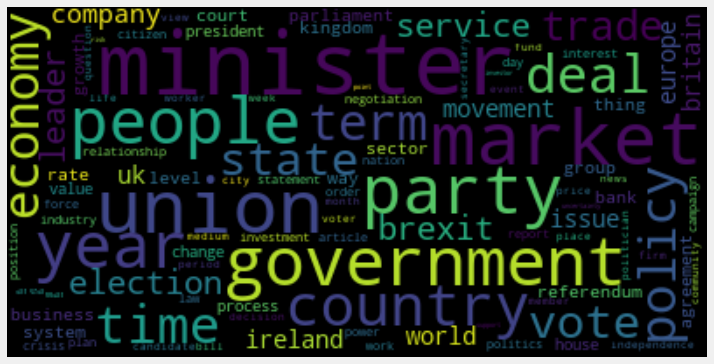

In [ ]:
plot_wordcloud(cnt_ASP)

In [ ]:
len(asp_json)

1508293

## CLUSTERING

In [ ]:
import ast
asp_json = []
i = 0
for asp in dataset["aspetti"]:
    for item in asp:
        asp_json.append(item)

In [ ]:
asp_json = open_json("cluster4lemmatized.json")

In [ ]:
asp_json[0]

'jan'

In [ ]:
def get_unique_product_ids(reviews_data):
    product_ids = []
    product_ids = [r['product_id'] for r in reviews_data]
    return list(set(product_ids))

def get_aspects(reviews_data):
    aspects = []
    for review in reviews_data:
        aspects.append(review["aspetto"])
    # aspects = [r['aspect_pairs'][0] for r in reviews_data]
    return aspects

def get_aspect_freq_map(aspects):
    aspect_freq_map = defaultdict(int)
    for asp in aspects:
        aspect_freq_map[asp] += 1
    return aspect_freq_map

def get_unique_aspects(aspects):
    unique_aspects = list(set(aspects)) # use this list for clustering
    return unique_aspects


def get_word_vectors(unique_aspects, nlp):
    asp_vectors = []
    for aspect in unique_aspects:
        token = nlp(aspect)
        asp_vectors.append(token.vector)
    return asp_vectors

def get_word_vectors_centroidi(unique_aspects, nlp):
    centroidi = []
    for aspect in unique_aspects:
        if aspect in ["government", "market", "uk", "europe", "vote"]:
            token = nlp(aspect)
            centroidi.append(token.vector)
    return centroidi

def get_word_clusters(unique_aspects, nlp):
    print("Found {} unique aspects for this product".format(len(unique_aspects)))
    centroidi = get_word_vectors_centroidi(unique_aspects, nlp)
    centroidi = np.array(centroidi, np.float64)
    asp_vectors = get_word_vectors(unique_aspects, nlp)
   # n_clusters = min(NUM_CLUSTERS,len(unique_aspects))
    #if len(unique_aspects) <= NUM_CLUSTERS:
     #   print("Too few aspects ({}) found. No clustering required...".format(len(unique_aspects)))
      #  return list(range(len(unique_aspects)))

    print("Running k-means clustering...")
    range_n_clusters = [2, 3, 4, 5, 6, 8, 10]

    for n_clusters in range_n_clusters:
        
        kmeans = cluster.KMeans(n_clusters=n_clusters, init=centroidi, random_state= 4242)
        kmeans.fit_predict(asp_vectors)
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(asp_vectors, labels)
        print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)
        unique_labels = set(labels)
        print("labels: ", unique_labels)
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(asp_vectors, labels)
        print("sample silhouette ",sample_silhouette_values)
            
        print("Finished running k-means clustering with {} labels".format(len(labels)))
    return labels

def get_cluster_names_map(asp_to_cluster_map, aspect_freq_map):
    cluster_id_to_name_map = defaultdict()
    # cluster_to_asp_map = defaultdict()
    n_clusters = len(set(asp_to_cluster_map.values()))
    for i in range(n_clusters):
        this_cluster_asp = [k for k,v in asp_to_cluster_map.items() if v == i]
        filt_freq_map = {k:v for k,v in aspect_freq_map.items() if k in this_cluster_asp}
        filt_freq_map = sorted(filt_freq_map.items(), key = lambda x: x[1], reverse = True)
        cluster_id_to_name_map[i] = filt_freq_map[0][0]

        # cluster_to_asp_map[i] = cluster_nouns

    # print(cluster_to_asp_map)
    return cluster_id_to_name_map

In [ ]:
def add_clusters_to_reviews(reviews_data, nlp):
    product_aspects = get_aspects(reviews_data)
    # print("Total aspects found: {}".format(len(product_aspects)))
    aspect_freq_map = get_aspect_freq_map(product_aspects)
    unique_aspects = aspect_freq_map.keys()
    # print("Runnig clustering on {} unique aspects".format(len(unique_aspects)))

    aspect_labels = get_word_clusters(unique_aspects, nlp)
    asp_to_cluster_map = dict(zip(unique_aspects, aspect_labels))
    cluster_names_map = get_cluster_names_map(asp_to_cluster_map, aspect_freq_map)
    updated_reviews = []
    
    for review in reviews_data:

        cluster_label_id = asp_to_cluster_map[review["aspetto"]]
        cluster_label_name = cluster_names_map[cluster_label_id]
        review["cluster"] = cluster_label_name
        '''
#         cluster_mapping = []
        result = []
        aspect_pairs = review["aspect_pairs"]
        for noun,adj,polarity,rule  in aspect_pairs:
            cluster_label_id = asp_to_cluster_map[noun]
            cluster_label_name = cluster_names_map[cluster_label_id]
#             cluster_mapping.append(cluster_label_name)
            result.append({'noun':noun, 'adj':adj, 'rule':rule, 'polarity':polarity, 'cluster':cluster_label_name})

        #assert len(result) == len(aspect_pairs)
#         review['aspect_pairs'] = result
    # all_label_ids = []
    # for asp in all_aspects:
    #     this_label = asp_to_cluster_id_map[asp]
    #     this_label_name = cluster_names_map[this_label]
    #     all_label_ids.append(this_label)
    #     all_label_names.append(this_label_name)

        updated_reviews.append({'review_id':review['review_id'], 'product_id':review['product_id'], 'aspect_pairs':result})
    '''
    return updated_reviews

def update_reviews_data(reviews_data, nlp):
    updated_reviews = []
   # product_ids = get_unique_product_ids(reviews_data)
   # print("Total number of unique products in this category: {}".format(len(product_ids)))

 #   no_asp_reviews = [r for r in reviews_data if len(r['aspect_pairs']) == 0]
 #   print("Total reviews found with no aspect pairs: {}".format(len(no_asp_reviews)))

#    for prod_id in product_ids:
#         print("\nRunning clustering for product ID - {}".format(prod_id))
 #       this_product_reviews = [r for r in reviews_data if r['product_id'] == prod_id]
        # this_no_asp_reviews = [r for r in this_product_reviews if len(r['aspect_pairs']) == 0]
        # print("Total reviews found: {}. Reviews with no aspect pairs: {}".format(len(this_product_reviews), len(this_no_asp_reviews)))

    aspect_cluster = add_clusters_to_reviews(reviews_data, nlp)
    #updated_reviews.extend(this_produc)

    print("\n----------------***----------------")
    print("Updating final results")
    with open('results_file.json', 'a') as f:
        json.dump(aspect_cluster,f)
    print("Finished writing results to json!!")
    print("----------------***----------------")

In [ ]:

import pandas as pd
import json
import ast
import spacy
from sklearn import cluster
from collections import defaultdict
from time import time
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
NUM_CLUSTERS = 5
print("Running clustering...")
update_reviews_data(asp_json, nlp)

Running clustering...
Found 34475 unique aspects for this product
Running k-means clustering...
For n_clusters = 5 The average silhouette_score is : 0.09526197
labels:  {0, 1, 2, 3, 4}
sample silhouette  [ 0.1021612   0.12805794  0.16756813 ... -0.03585847 -0.02462108
  0.26182216]
Finished running k-means clustering with 34475 labels

----------------***----------------
Updating final results
Finished writing results to json!!
----------------***----------------


In [ ]:
def get_word_clusters(unique_aspects, nlp):
    print("Found {} unique aspects for this product".format(len(unique_aspects)))
    asp_vectors = get_word_vectors(unique_aspects, nlp)
    n_clusters = min(NUM_CLUSTERS,len(unique_aspects))
    #if len(unique_aspects) <= NUM_CLUSTERS:
     #   print("Too few aspects ({}) found. No clustering required...".format(len(unique_aspects)))
      #  return list(range(len(unique_aspects)))

    print("Running k-means clustering...")
    #range_n_clusters = [2, 3, 4, 5, 6, 8, 10]

   # for n_clusters in range_n_clusters:
        
    kmeans = cluster.KMeans(n_clusters=n_clusters)
    kmeans.fit_predict(asp_vectors)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(asp_vectors, labels)
    print("For n_clusters =", n_clusters,
    "The average silhouette_score is :", silhouette_avg)
    unique_labels = set(labels)
    print("labels: ", unique_labels)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(asp_vectors, labels)
    print("sample silhouette ",sample_silhouette_values)
        
    print("Finished running k-means clustering with {} labels".format(len(labels)))
    return labels

In [ ]:
store_json(asp_json, "cluster4lemmatized.json")

In [ ]:
asp_json = open_json("cluster5lemmatized.json")

In [ ]:
df = pd.read_csv("dataDEF.csv")
df

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0               0             0               0                 0   
1               1             1               1                 1   
2               2             2               2                 2   
3               3             3               3                 3   
4               4             4               4                 4   
...           ...           ...             ...               ...   
23048       23048         23048           27003             27003   
23049       23049         23049           27004             27004   
23050       23050         23050           27005             27005   
23051       23051         23051           27006             27006   
23052       23052         23052           27007             27007   

                                                 article  \
0      <newspaper.article.Article object at 0x7fd49d7...   
1      <newspaper.article.Article object at 0x7fd4ab8...   
2      <newspaper.article.Article object at 0x7fd49d7...   
3      <newspaper.article.Article object at 0x7fd49d8...   
4      <newspaper.article.Article object at 0x7fd49d8...   
...                                                  ...   
23048  <newspaper.article.Article object at 0x7f55430...   
23049  <newspaper.article.Article object at 0x7f5542e...   
23050  <newspaper.article.Article object at 0x7f5542e...   
23051  <newspaper.article.Article object at 0x7f5542f...   
23052  <newspaper.article.Article object at 0x7f5542f...   

                                                 authors  count  \
0                                                     []    1.0   
1                                   ['Associated Press']    1.0   
2                                                     []    1.0   
3                                        ['Lucy Towers']    1.0   
4                                                     []    1.0   
...                                                  ...    ...   
23048                                                 []    1.0   
23049                                                 []    1.0   
23050                                   ['Esm Magazine']    1.0   
23051  ['Diane Abbott', 'Labour Will Close Gap In Pol...    1.0   
23052                                                 []    1.0   

                            date      date_f  \
0      2017-01-04 13:57:11+00:00  2017-01-04   
1      2017-01-04 09:36:24+00:00  2017-01-04   
2      2017-01-04 10:47:17+00:00  2017-01-04   
3      2017-01-04 07:36:35+00:00  2017-01-04   
4      2017-01-04 06:53:28+00:00  2017-01-04   
...                          ...         ...   
23048  2016-12-12 07:48:09+00:00  2016-12-12   
23049  2016-12-12 12:45:00+00:00  2016-12-12   
23050  2016-12-12 14:30:25+00:00  2016-12-12   
23051  2016-12-12 10:18:01+00:00  2016-12-12   
23052  2016-12-12 12:23:38+00:00  2016-12-12   

                                                keywords  \
0      ['referendum', 'putin', 'vote', 'meddling', 'r...   
1      ['prime', 'eu', 'theresa', 'mays', 'departing'...   
2      ['eu', 'resigns', 'expected', 'talks', 'ambass...   
3      ['eu', 'market', 'exports', 'mean', 'meat', 'u...   
4      ['hit', 'weakness', 'manufacturing', 'shrugs',...   
...                                                  ...   
23048  ['report', 'health', 'period', 'animal', '000'...   
23049  ['farage', 'stupid', 'nobel', 'version', 'pale...   
23050  ['brexit', 'beighton', 'company', 'boosts', 'u...   
23051  ['brexit', 'polls', 'party', 'voted', 'freedom...   
23052  ['report', 'future', 'brexit', 'seeks', 'clari...   

                                                    text  \
0      Source: Obama Interfered in the Brexit Vote, N...   
1      Departing UK envoy to EU attacks Theresa May's...   
2      Britain's ambassador to the European Union has...   
3      Current situation – exports\n\nPork exports ha...   
4      Manufacturing output has been expanding for th.

In [ ]:
df_def = pd.read_csv("dataDEF4.csv")

In [ ]:
dataset = df_def.drop(columns=["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.1.1", "Unnamed: 0.1.1.1"])
dataset

article  \
0      <newspaper.article.Article object at 0x7fd49d7...   
1      <newspaper.article.Article object at 0x7fd4ab8...   
2      <newspaper.article.Article object at 0x7fd49d7...   
3      <newspaper.article.Article object at 0x7fd49d8...   
4      <newspaper.article.Article object at 0x7fd49d8...   
...                                                  ...   
23048  <newspaper.article.Article object at 0x7f55430...   
23049  <newspaper.article.Article object at 0x7f5542e...   
23050  <newspaper.article.Article object at 0x7f5542e...   
23051  <newspaper.article.Article object at 0x7f5542f...   
23052  <newspaper.article.Article object at 0x7f5542f...   

                                                 authors  count  \
0                                                     []    1.0   
1                                   ['Associated Press']    1.0   
2                                                     []    1.0   
3                                        ['Lucy Towers']    1.0   
4                                                     []    1.0   
...                                                  ...    ...   
23048                                                 []    1.0   
23049                                                 []    1.0   
23050                                   ['Esm Magazine']    1.0   
23051  ['Diane Abbott', 'Labour Will Close Gap In Pol...    1.0   
23052                                                 []    1.0   

                            date      date_f  \
0      2017-01-04 13:57:11+00:00  2017-01-04   
1      2017-01-04 09:36:24+00:00  2017-01-04   
2      2017-01-04 10:47:17+00:00  2017-01-04   
3      2017-01-04 07:36:35+00:00  2017-01-04   
4      2017-01-04 06:53:28+00:00  2017-01-04   
...                          ...         ...   
23048  2016-12-12 07:48:09+00:00  2016-12-12   
23049  2016-12-12 12:45:00+00:00  2016-12-12   
23050  2016-12-12 14:30:25+00:00  2016-12-12   
23051  2016-12-12 10:18:01+00:00  2016-12-12   
23052  2016-12-12 12:23:38+00:00  2016-12-12   

                                                keywords  \
0      ['referendum', 'putin', 'vote', 'meddling', 'r...   
1      ['prime', 'eu', 'theresa', 'mays', 'departing'...   
2      ['eu', 'resigns', 'expected', 'talks', 'ambass...   
3      ['eu', 'market', 'exports', 'mean', 'meat', 'u...   
4      ['hit', 'weakness', 'manufacturing', 'shrugs',...   
...                                                  ...   
23048  ['report', 'health', 'period', 'animal', '000'...   
23049  ['farage', 'stupid', 'nobel', 'version', 'pale...   
23050  ['brexit', 'beighton', 'company', 'boosts', 'u...   
23051  ['brexit', 'polls', 'party', 'voted', 'freedom...   
23052  ['report', 'future', 'brexit', 'seeks', 'clari...   

                                                    text  \
0      Source: Obama Interfered in the Brexit Vote, N...   
1      Departing UK envoy to EU attacks Theresa May's...   
2      Britain's ambassador to the European Union has...   
3      Current situation – exports\n\nPork exports ha...   
4      Manufacturing output has been expanding for th...   
...                                                  ...   
23048  Keyword\n\nCompany\n\nEPIC/TIDM\n\nSEDOL/ISIN\...   
23049  Labour politician Andy Burnham is becoming “a ...   
23050  Published on Dec 12 2016 2:30 PM in Retail tag...   
23051  Shadow home secretary Diane Abbott says Labour...   
23052  EU nationals already living in the UK at the p...   

                                                   title  \
0         Obama Interfered in the Brexit Vote, Not Putin   
1      Departing UK envoy to EU attacks Theresa May's...   
2      Britain's ambassador to EU resigns ahead of Br...   
3      What Brexit Might Mean for the UK Pig Industry...   
4      Manufacturing shrugs off Brexit to hit 30-mont...   
...                                                  ...   
23048                Eco Animal Health: Half-year Report   
23049  Ken Clarke: Andy 

In [ ]:
def get_labels_cluster(data):
    labels = []
    for item in data:
        for asp in item:
            labels.append(asp["cluster"])
    unique = set(labels)
    return unique

In [ ]:
def get_labels_cluster_json(data):
    labels = []
    for asp in data:
        labels.append(asp["cluster"])
    unique = set(labels)
    return unique

In [ ]:
dataset

article  \
0      <newspaper.article.Article object at 0x7fd49d7...   
1      <newspaper.article.Article object at 0x7fd4ab8...   
2      <newspaper.article.Article object at 0x7fd49d7...   
3      <newspaper.article.Article object at 0x7fd49d8...   
4      <newspaper.article.Article object at 0x7fd49d8...   
...                                                  ...   
23048  <newspaper.article.Article object at 0x7f55430...   
23049  <newspaper.article.Article object at 0x7f5542e...   
23050  <newspaper.article.Article object at 0x7f5542e...   
23051  <newspaper.article.Article object at 0x7f5542f...   
23052  <newspaper.article.Article object at 0x7f5542f...   

                                                 authors  count  \
0                                                     []    1.0   
1                                   ['Associated Press']    1.0   
2                                                     []    1.0   
3                                        ['Lucy Towers']    1.0   
4                                                     []    1.0   
...                                                  ...    ...   
23048                                                 []    1.0   
23049                                                 []    1.0   
23050                                   ['Esm Magazine']    1.0   
23051  ['Diane Abbott', 'Labour Will Close Gap In Pol...    1.0   
23052                                                 []    1.0   

                           date      date_f  \
0     2017-01-04 13:57:11+00:00  2017-01-04   
1     2017-01-04 09:36:24+00:00  2017-01-04   
2     2017-01-04 10:47:17+00:00  2017-01-04   
3     2017-01-04 07:36:35+00:00  2017-01-04   
4     2017-01-04 06:53:28+00:00  2017-01-04   
...                         ...         ...   
23048 2016-12-12 07:48:09+00:00  2016-12-12   
23049 2016-12-12 12:45:00+00:00  2016-12-12   
23050 2016-12-12 14:30:25+00:00  2016-12-12   
23051 2016-12-12 10:18:01+00:00  2016-12-12   
23052 2016-12-12 12:23:38+00:00  2016-12-12   

                                                keywords  \
0      ['referendum', 'putin', 'vote', 'meddling', 'r...   
1      ['prime', 'eu', 'theresa', 'mays', 'departing'...   
2      ['eu', 'resigns', 'expected', 'talks', 'ambass...   
3      ['eu', 'market', 'exports', 'mean', 'meat', 'u...   
4      ['hit', 'weakness', 'manufacturing', 'shrugs',...   
...                                                  ...   
23048  ['report', 'health', 'period', 'animal', '000'...   
23049  ['farage', 'stupid', 'nobel', 'version', 'pale...   
23050  ['brexit', 'beighton', 'company', 'boosts', 'u...   
23051  ['brexit', 'polls', 'party', 'voted', 'freedom...   
23052  ['report', 'future', 'brexit', 'seeks', 'clari...   

                                                    text  \
0      Source: Obama Interfered in the Brexit Vote, N...   
1      Departing UK envoy to EU attacks Theresa May's...   
2      Britain's ambassador to the European Union has...   
3      Current situation – exports\n\nPork exports ha...   
4      Manufacturing output has been expanding for th...   
...                                                  ...   
23048  Keyword\n\nCompany\n\nEPIC/TIDM\n\nSEDOL/ISIN\...   
23049  Labour politician Andy Burnham is becoming “a ...   
23050  Published on Dec 12 2016 2:30 PM in Retail tag...   
23051  Shadow home secretary Diane Abbott says Labour...   
23052  EU nationals already living in the UK at the p...   

                                                   title  \
0         Obama Interfered in the Brexit Vote, Not Putin   
1      Departing UK envoy to EU attacks Theresa May's...   
2      Britain's ambassador to EU resigns ahead of Br...   
3      What Brexit Might Mean for the UK Pig Industry...   
4      Manufacturing shrugs off Brexit to hit 30-mont...   
...                                                  ...   
23048                Eco Animal Health: Half-year Report   
23049  Ken Clarke: Andy Burnham is '

In [ ]:
domains_left

article  \
39     <newspaper.article.Article object at 0x7fd49d7...   
42     <newspaper.article.Article object at 0x7fd49d2...   
55     <newspaper.article.Article object at 0x7fd49d2...   
119    <newspaper.article.Article object at 0x7fd49d1...   
124    <newspaper.article.Article object at 0x7fd49d1...   
...                                                  ...   
22835  <newspaper.article.Article object at 0x7f55476...   
22875  <newspaper.article.Article object at 0x7f55471...   
22945  <newspaper.article.Article object at 0x7f55432...   
22981  <newspaper.article.Article object at 0x7f5542f...   
22984  <newspaper.article.Article object at 0x7f55431...   

                                      authors  count  \
39                        ['Patrick Maguire']    1.0   
42                          ['Dominic Rushe']    1.0   
55     ['Jack Blanchard', 'Image', 'Reuters']    1.0   
119                             ['Tim Pears']    1.0   
124                          ['Fiona Harvey']    1.0   
...                                       ...    ...   
22835                       ['Chris Riddell']    1.0   
22875                        ['Rowena Mason']    1.0   
22945                       ['Larry Elliott']    1.0   
22981                       ['Suzanne Moore']    1.0   
22984                          ['John Crace']    1.0   

                           date      date_f  \
39    2017-01-04 04:30:17+00:00  2017-01-04   
42    2017-01-04 03:00:18+00:00  2017-01-04   
55    2017-01-04 02:06:40+00:00  2017-01-04   
119   2017-01-04 00:00:44+00:00  2017-01-04   
124   2017-01-04 23:46:49+00:00  2017-01-04   
...                         ...         ...   
22835 2016-12-11 01:00:27+00:00  2016-12-11   
22875 2016-12-11 15:57:41+00:00  2016-12-11   
22945 2016-12-12 11:01:03+00:00  2016-12-12   
22981 2016-12-12 12:55:42+00:00  2016-12-12   
22984 2016-12-12 21:00:35+00:00  2016-12-12   

                                                keywords  \
39     ['row', 'pin', 'lib', 'blues', 'olney', 'heath...   
42     ['factories', 'ford', 'prices', 'quarter', 'ca...   
55     ['press', 'newspapers', 'powerful', 'national'...   
119    ['eu', 'spectacles', 'need', 'ambassador', 'ni...   
124    ['research', '84', 'subsidies', 'postbrexit', ...   
...                                                  ...   
22835  ['brexit', 'riddell', 'happened', 'demise', 'c...   
22875  ['brexit', 'process', 'warns', 'opportunity', ...   
22945  ['scratch', 'postbrexit', 'negotiations', 'dut...   
22981  ['clothes', 'trousergate', 'dressing', 'leathe...   
22984  ['trashed', 'committee', 'john', 'minister', '...   

                                                    text  \
39     Theresa May abandoned her opposition to a thir...   
42     Ford has warned it is considering closing fact...   
55     Get email updates with the day's biggest stori...   
119    If you’re the kind of Remoaner kept up at nigh...   
124    New subsidies paid to farmers under a post-Bre...   
...                                                  ...   
22835  Chris Riddell on the demise of the campaign to...   
22875  The civil service will not be able to implemen...   
22945  Negotiations about the shape of the UK’s post-...   
22981  Who cares what men wear? Not even men! In 2011...   
22984  “Can we just start with today’s story that the...   

                                                   title  \
39     Lib Dems pin hopes on Richmond as Heathrow row...   
42     Ford considers closing factories and raising p...   
55     Only 4% back press regulation that is funded b...   
119    The next ambassador to the EU will need rose-t...   
124    Post-Brexit farming subsidies must protect nat...   
...                                                  ...   
22835         What ever happened to the Brexit campaign?   
22875  Civil service unable to cope with Brexit, warn...   
22945  WTO chief says post-Brexit trade talks must st...   
22981  What’s the point of trousergate? It’s a w

In [ ]:
cnt_pos = Counter()
for asp in dataset["aspetti"]:
    for item in asp:
        cnt_pos[item["aspetto"]] += 1
cnt_pos.most_common(25)

In [ ]:
import ast
i = 0
for asp in dataset["aspetti"]:
    print(i)
    dataset["aspetti"][i] = ast.literal_eval(asp)
    i = i+1

In [ ]:
dataset["date_f"][0]

'2017-01-04'

In [ ]:
labels = list(get_labels_cluster(dataset["aspetti"]))

In [ ]:
labels = list(get_labels_cluster_json(asp_json))

In [ ]:
labels

['firm', 'people', 'minister', 'deal']

In [ ]:
asp_json = open_json("cluster5lemmatized.json")

In [ ]:
positive = {
    "deal": 0,
    "minister": 0,
    "deal": 0,
    "firm": 0,
    "people": 0
}
negative = {
    "deal": 0,
    "minister": 0,
    "deal": 0,
    "firm": 0,
    "people": 0
}
neutral =  {
    "deal": 0,
    "minister": 0,
    "deal": 0,
    "firm": 0,
    "people": 0
}
for label in labels:
    positive[label] = []
    negative[label] = []
    neutral[label] = []
    elements = 0

    for asp in dataset["aspetti"]:
        for item in asp:
            if item["cluster"] == label:
                elements = elements+1
                if item["sentiment"]["compound"] > 0:
                    positive[label].append(item)
                if  item["sentiment"]["compound"] == 0:
                    neutral[label].append(item)
                if item["sentiment"]["compound"] < 0:
                    negative[label].append(item)
    print("------------------------")
    print("Tot: ", elements)
    print("Label   :", label)
    print("positive ", len(positive[label]))
    print("negative ", len(negative[label]))
    print("neutral ", len(neutral[label]))


------------------------
Tot:  82035
Label   : firm
positive  8247
negative  5499
neutral  68289
------------------------
Tot:  39614
Label   : people
positive  4423
negative  2791
neutral  32400
------------------------
Tot:  1158018
Label   : minister
positive  143515
negative  70688
neutral  943815
------------------------
Tot:  228626
Label   : deal
positive  29296
negative  17944
neutral  181386


In [ ]:
import pickle
with open("positive_clusters4.pkl", "wb") as writer:
    pickle.dump(positive, writer)

In [ ]:
    with open("positive_clusters4.pkl", 'rb') as handle:
       positive = pickle.load(handle)

In [ ]:
import pickle
with open("negative_clusters4.pkl", "wb") as writer:
    pickle.dump(negative, writer)

In [ ]:
with open("negative_clusters4.pkl", 'rb') as handle:
    negative = pickle.load(handle)

In [ ]:
import pickle
with open("neutral_clusters4.pkl", "wb") as writer:
    pickle.dump(neutral, writer)

In [ ]:
with open("neutral_clusters.pkl", 'rb') as handle:
    neutral = pickle.load(handle)

EOFError: Ran out of input

In [ ]:
cnt_pos = Counter()
for asp in neutral["minister"]:
    cnt_pos[asp["desc"]] += 1
cnt_pos.most_common(50)

In [ ]:
cnt_pos = Counter()
for asp in negative["minister"]:
    cnt_pos[asp["regola"]] += 1
cnt_pos.most_common(50)

[(1, 68237), (8, 1898), (4, 102), (3, 46), (7, 16)]

In [ ]:
cnt_pos = Counter()
for asp in positive["minister"]:
    cnt_pos[asp["regola"]] += 1
cnt_pos.most_common(50)

[(1, 140373), (8, 2084), (4, 201), (3, 65), (7, 15), (6, 2)]

In [ ]:
negative["minister"][:10]

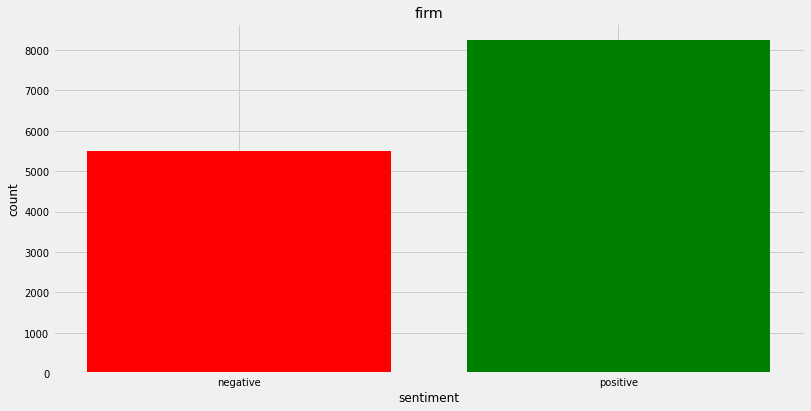

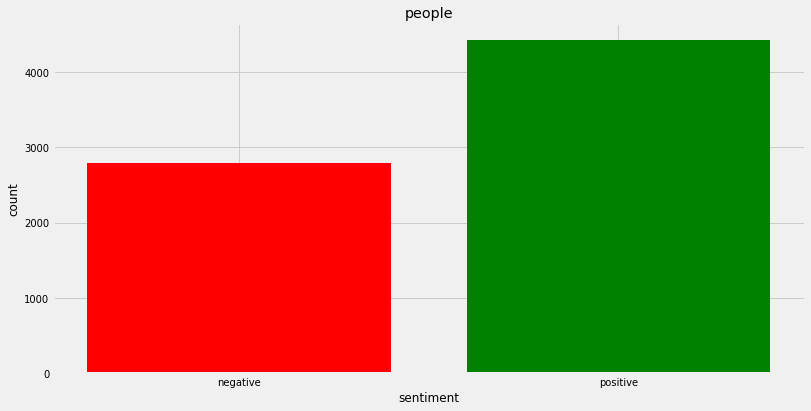

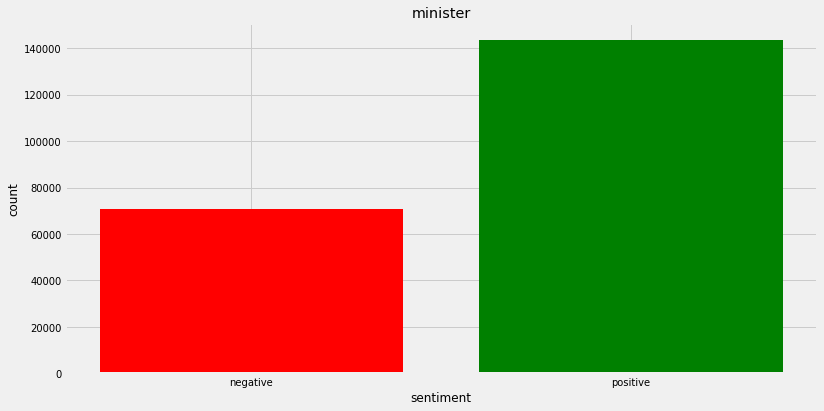

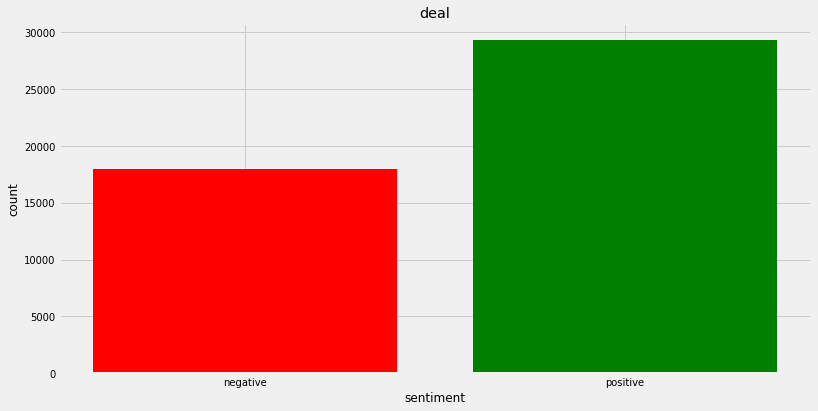

In [ ]:
import matplotlib.pyplot as plt
labels = list(get_labels_cluster(dataset["aspetti"]))
# x-coordinates of left sides of bars 
for label in labels:
        left = [1,2]
        
        # heights of bars
        height = [len(negative[label]), len(positive[label])]
        
        # labels for bars
        tick_label = ['negative', 'positive']
        
        # plotting a bar chart
        plt.bar(left, height, tick_label = tick_label,
                width = 0.8, color = ['red', 'green'])
        
        # naming the x-axis
        plt.xlabel('sentiment')
        # naming the y-axis
        plt.ylabel('count')
        # plot title
        plt.title(label)
        
        plt.savefig("general_aspects_"+label+".jpg")
        # function to show the plot
        plt.show()
        

In [ ]:
dataset['date'] =pd.to_datetime(dataset.date)
dataset['month'] = [s[1]['date'].month for s in dataset.iterrows()]
month_groupby = Counter(dataset['month'])
#df['date_f'] = [d.date() for d in df['date']]
#df_dategroup_notzero = df_dategroup.drop(df_dategroup[df_dategroup["count"] == 0].index)
#df_dategroup_notzero 
month_groupby

Counter({1: 4978, 12: 5278, 2: 4886, 3: 5272, 4: 2459, 11: 180})

In [ ]:
dataset

article  \
0      <newspaper.article.Article object at 0x7fd49d7...   
1      <newspaper.article.Article object at 0x7fd4ab8...   
2      <newspaper.article.Article object at 0x7fd49d7...   
3      <newspaper.article.Article object at 0x7fd49d8...   
4      <newspaper.article.Article object at 0x7fd49d8...   
...                                                  ...   
23048  <newspaper.article.Article object at 0x7f55430...   
23049  <newspaper.article.Article object at 0x7f5542e...   
23050  <newspaper.article.Article object at 0x7f5542e...   
23051  <newspaper.article.Article object at 0x7f5542f...   
23052  <newspaper.article.Article object at 0x7f5542f...   

                                                 authors  count  \
0                                                     []    1.0   
1                                   ['Associated Press']    1.0   
2                                                     []    1.0   
3                                        ['Lucy Towers']    1.0   
4                                                     []    1.0   
...                                                  ...    ...   
23048                                                 []    1.0   
23049                                                 []    1.0   
23050                                   ['Esm Magazine']    1.0   
23051  ['Diane Abbott', 'Labour Will Close Gap In Pol...    1.0   
23052                                                 []    1.0   

                           date      date_f  \
0     2017-01-04 13:57:11+00:00  2017-01-04   
1     2017-01-04 09:36:24+00:00  2017-01-04   
2     2017-01-04 10:47:17+00:00  2017-01-04   
3     2017-01-04 07:36:35+00:00  2017-01-04   
4     2017-01-04 06:53:28+00:00  2017-01-04   
...                         ...         ...   
23048 2016-12-12 07:48:09+00:00  2016-12-12   
23049 2016-12-12 12:45:00+00:00  2016-12-12   
23050 2016-12-12 14:30:25+00:00  2016-12-12   
23051 2016-12-12 10:18:01+00:00  2016-12-12   
23052 2016-12-12 12:23:38+00:00  2016-12-12   

                                                keywords  \
0      ['referendum', 'putin', 'vote', 'meddling', 'r...   
1      ['prime', 'eu', 'theresa', 'mays', 'departing'...   
2      ['eu', 'resigns', 'expected', 'talks', 'ambass...   
3      ['eu', 'market', 'exports', 'mean', 'meat', 'u...   
4      ['hit', 'weakness', 'manufacturing', 'shrugs',...   
...                                                  ...   
23048  ['report', 'health', 'period', 'animal', '000'...   
23049  ['farage', 'stupid', 'nobel', 'version', 'pale...   
23050  ['brexit', 'beighton', 'company', 'boosts', 'u...   
23051  ['brexit', 'polls', 'party', 'voted', 'freedom...   
23052  ['report', 'future', 'brexit', 'seeks', 'clari...   

                                                    text  \
0      Source: Obama Interfered in the Brexit Vote, N...   
1      Departing UK envoy to EU attacks Theresa May's...   
2      Britain's ambassador to the European Union has...   
3      Current situation – exports\n\nPork exports ha...   
4      Manufacturing output has been expanding for th...   
...                                                  ...   
23048  Keyword\n\nCompany\n\nEPIC/TIDM\n\nSEDOL/ISIN\...   
23049  Labour politician Andy Burnham is becoming “a ...   
23050  Published on Dec 12 2016 2:30 PM in Retail tag...   
23051  Shadow home secretary Diane Abbott says Labour...   
23052  EU nationals already living in the UK at the p...   

                                                   title  \
0         Obama Interfered in the Brexit Vote, Not Putin   
1      Departing UK envoy to EU attacks Theresa May's...   
2      Britain's ambassador to EU resigns ahead of Br...   
3      What Brexit Might Mean for the UK Pig Industry...   
4      Manufacturing shrugs off Brexit to hit 30-mont...   
...                                                  ...   
23048                Eco Animal Health: Half-year Report   
23049  Ken Clarke: Andy Burnham is '

In [ ]:
permese = dataset.loc[dataset["month"] == 11]
permese

In [ ]:
for month in [11,12,1,2,3,4]:
  all_i = dataset.loc[dataset['month'] == month]
  scores = all_i['afinn'].values.tolist()
  df = count_scores(scores)
  count_neg_tot.append(df['count'][0])
  count_neutral_tot.append(df['count'][1])
  count_pos_tot.append(df['count'][2])

In [ ]:

positive = {
    "deal": 0,
    "minister": 0,
    "meeting": 0,
    "deal": 0,
    "firm": 0,
    "people": 0
}
negative = {
    "deal": 0,
    "minister": 0,
    "meeting": 0,
    "deal": 0,
    "firm": 0,
    "people": 0
}
neutral =  {
    "deal": 0,
    "minister": 0,
    "meeting": 0,
    "deal": 0,
    "firm": 0,
    "people": 0
}
for label in labels:
    positive[label] = []
    negative[label] = []
    neutral[label] = []
    elements = 0

    for asp in dataset["aspetti"]:
        for item in asp:
            if item["cluster"] == label:
                elements = elements+1
                if item["sentiment"]["compound"] > 0:
                    positive[label].append(item)
                if  item["sentiment"]["compound"] == 0:
                    neutral[label].append(item)
                if item["sentiment"]["compound"] < 0:
                    negative[label].append(item)
    print("------------------------")
    print("Tot: ", elements)
    print("Label   :", label)
    print("positive ", len(positive[label]))
    print("negative ", len(negative[label]))
    print("neutral ", len(neutral[label]))


------------------------
Tot:  221050
Label   : deal
positive  28569
negative  17489
neutral  174992
------------------------
Tot:  1152797
Label   : minister
positive  142740
negative  70299
neutral  939758
------------------------
Tot:  39642
Label   : people
positive  4425
negative  2792
neutral  32425
------------------------
Tot:  79795
Label   : firm
positive  8014
negative  5399
neutral  66382
------------------------
Tot:  15009
Label   : meeting
positive  1733
negative  943
neutral  12333


In [ ]:
def count_scores(month_data, label):
  count_neg = 0
  count_pos = 0
  count_neutral = 0
  for asp in month_data["aspetti"]:
        for item in asp:
            if item["cluster"] == label:
                if item["sentiment"]["compound"] > 0:
                    count_pos = count_pos +1
                if  item["sentiment"]["compound"] == 0:
                    count_neutral = count_neutral +1
                if item["sentiment"]["compound"] < 0:
                    count_neg = count_neg +1
  df = pd.DataFrame([count_neg,count_neutral,count_pos], index=["negative","neutral","positive"], columns=["count"])
  return df

In [ ]:
index = np.arange(len(list(month_groupby.keys())))
index

array([0, 1, 2, 3, 4, 5])

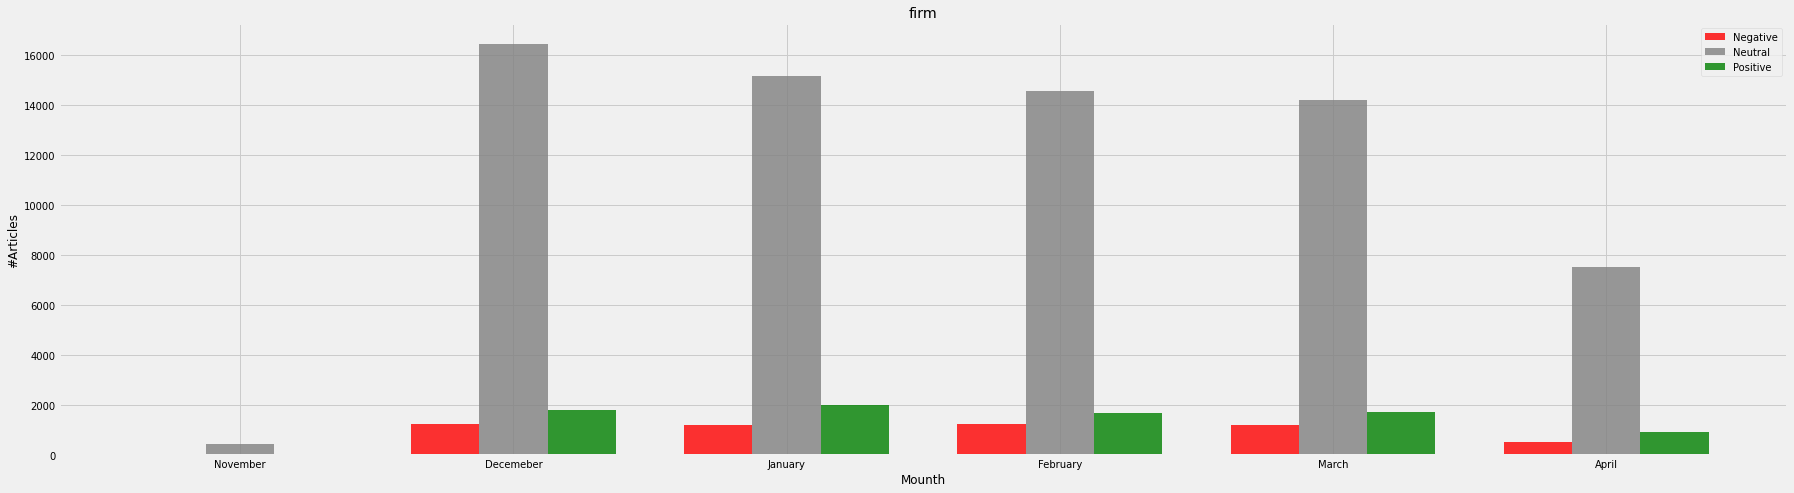

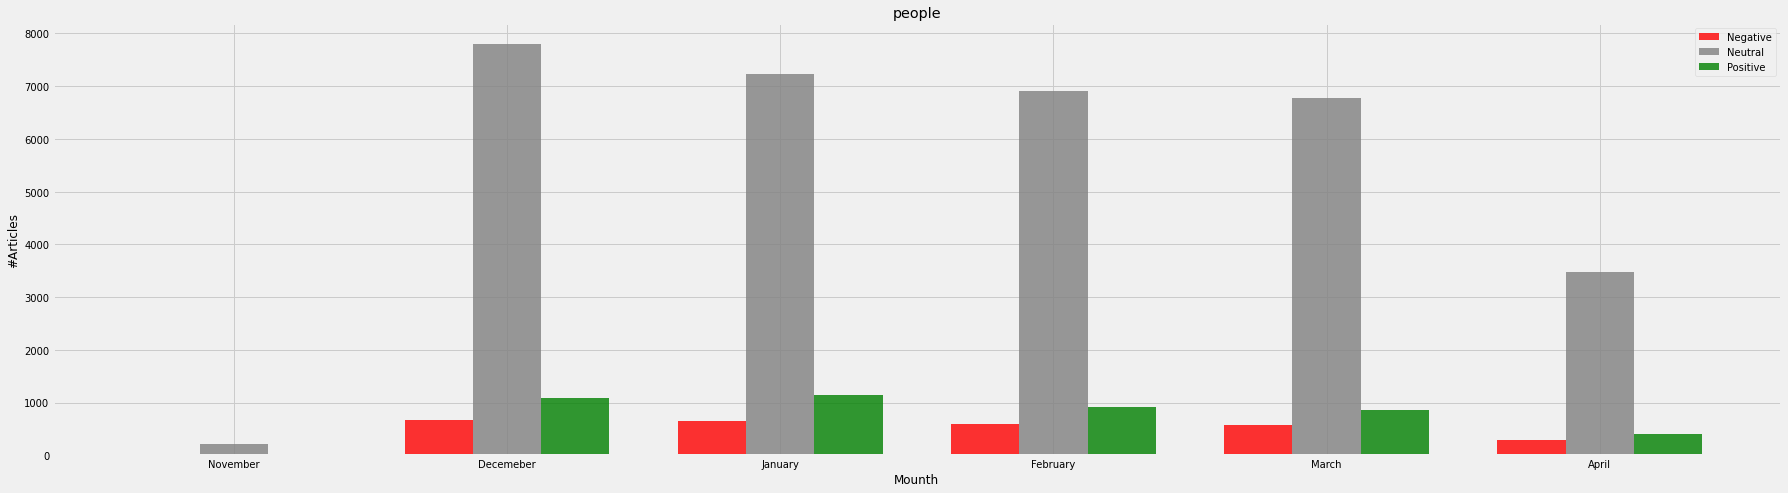

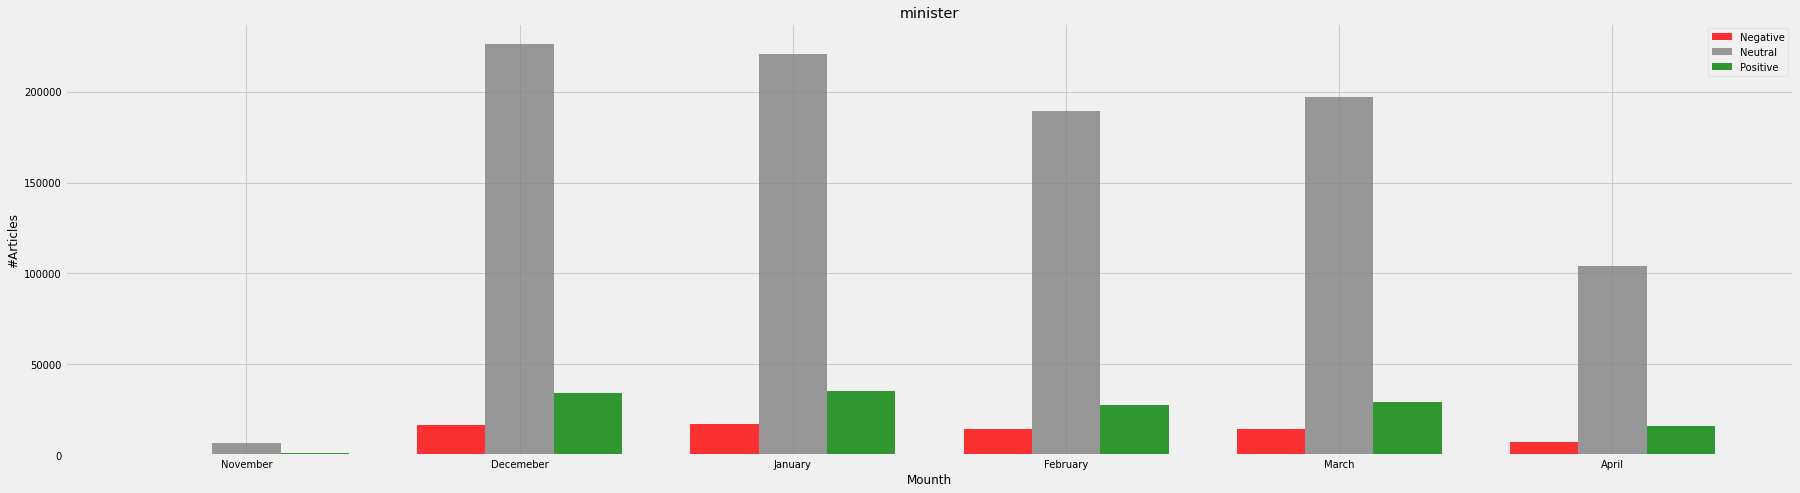

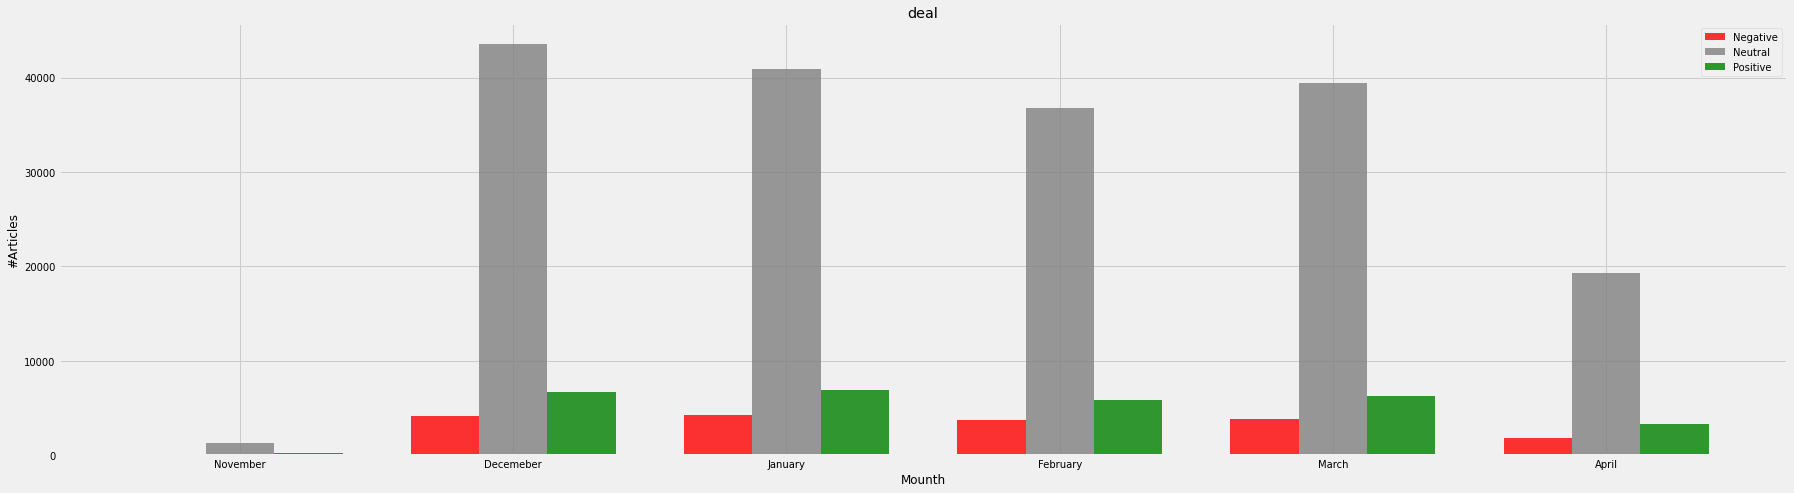

In [ ]:

labels = list(get_labels_cluster(dataset["aspetti"]))
for label in labels:
  count_neg_tot = []
  count_neutral_tot = []
  count_pos_tot = []
  for month in [11,12,1,2,3,4]:
    all_i = dataset.loc[dataset['month'] == month]

    df = count_scores(all_i, label)
    count_neg_tot.append(df['count'][0])
    count_neutral_tot.append(df['count'][1])
    count_pos_tot.append(df['count'][2])
  # data to plot
  n_groups = len(list(month_groupby.keys()))
  
  # create plot
  
  fig = plt.figure()
  ax = fig.add_axes([0,0,2,1])
  index = np.arange(len(list(month_groupby.keys())))
  bar_width = 0.25
  opacity = 0.8
  
  rects1 = plt.bar(index, count_neg_tot, bar_width,
  alpha=opacity,
  color='r',
  label='Negative')
  
  rects2 = plt.bar(index + bar_width, count_neutral_tot, bar_width,
  alpha=opacity,
  color='gray',
  label='Neutral')
  
  rects3 = plt.bar(index + (bar_width*2), count_pos_tot, bar_width,
  alpha=opacity,
  color='green',
  label='Positive')
  
  plt.xlabel('Mounth')
  plt.ylabel('#Articles')
  plt.title(label)
  plt.xticks(index + bar_width, ("November","Decemeber","January","February","March","April"))
  plt.legend()
  
  plt.tight_layout()
  plt.show()

In [ ]:
df

count
negative     66
neutral      31
positive    134

In [ ]:
for index in range(0, len(train_news_link)):
    print(index)
    for asp in asp_json:
        if asp["index"] == index:
            train_news_link["aspetti"][index] = asp_json


## Analisi risultati

### URL

#### Site

In [ ]:
da_tenere_conto = urls_parse_groupby.most_common(10)
da_tenere_conto

[('www.dailymail.co.uk', 983),
 ('www.theguardian.com', 874),
 ('www.heraldscotland.com', 772),
 ('www.thetimes.co.uk', 756),
 ('www.thesun.co.uk', 567),
 ('www.independent.co.uk', 557),
 ('www.express.co.uk', 536),
 ('www.thenational.scot', 329),
 ('www.latestnigeriannews.com', 260),
 ('www.reuters.com', 235)]

In [ ]:
nomi = [da_tenere_conto[i][0] for i in range(10)]
nomi.append("altri")
nomi

num = [da_tenere_conto[i][1] for i in range(10)]
altri_num = urls_parse_groupby.most_common()[10:]
num_atri = [altri_num[i][1] for i in range(len(altri_num))]
altri_num = sum(num_atri)
num.append(altri_num)

In [ ]:
#altro grafico
nomi = [da_tenere_conto[i][0] for i in range(10)]

num = [da_tenere_conto[i][1] for i in range(10)]

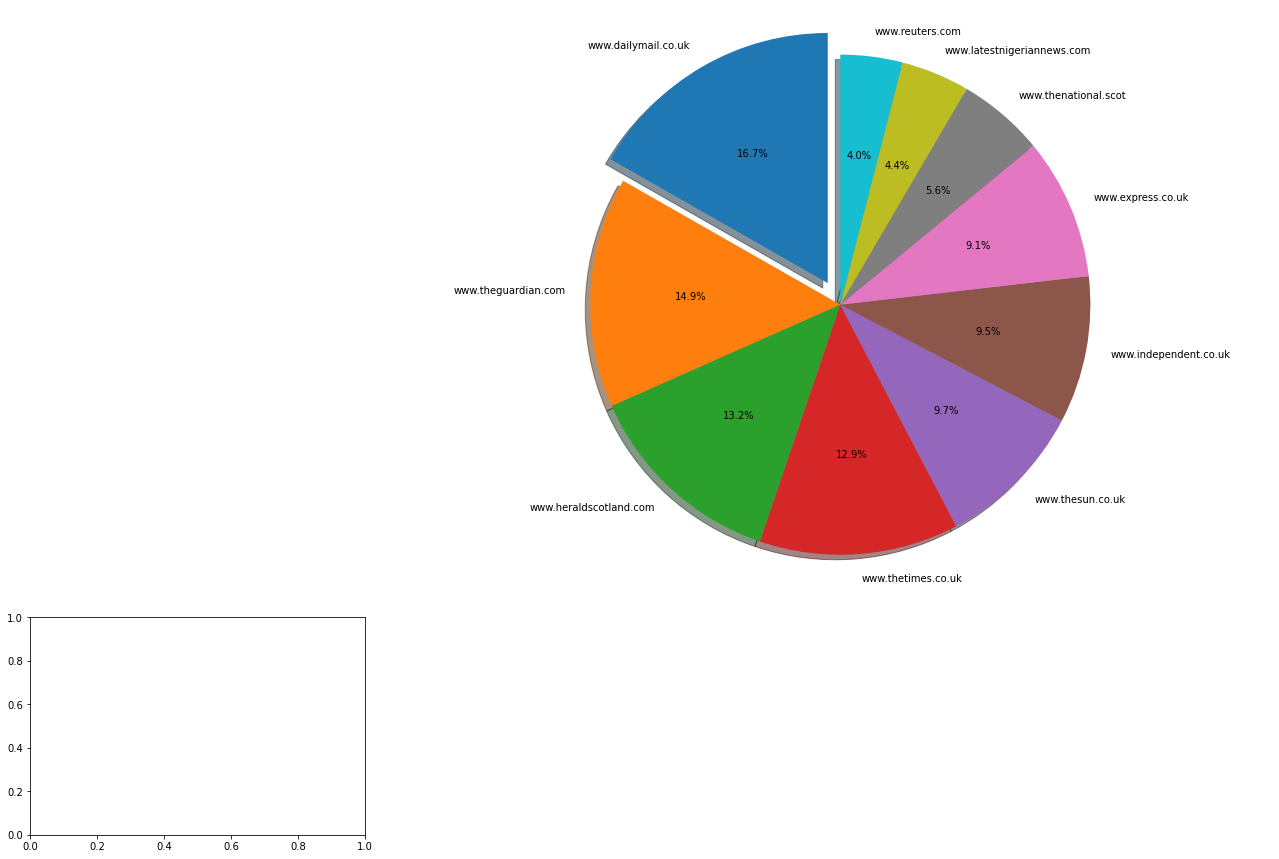

In [ ]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = nomi
sizes = num
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1 = fig1.add_axes([1,1,2,2])
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, frame=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#### Origin

In [ ]:
da_tenere_conto = urls_parse_groupby_origin.most_common(9)
da_tenere_conto

[('US', 2742),
 ('GB', 935),
 (nan, 273),
 ('CA', 105),
 ('DE', 90),
 ('IE', 84),
 ('FR', 57),
 ('NL', 48),
 ('AU', 36)]

In [ ]:
nomi = [da_tenere_conto[i][0] for i in range(9)]
nomi.append("altri")
nomi

num = [da_tenere_conto[i][1] for i in range(9)]
altri_num = urls_parse_groupby_origin.most_common()[9:]
num_atri = [altri_num[i][1] for i in range(len(altri_num))]
altri_num = sum(num_atri)
num.append(altri_num)

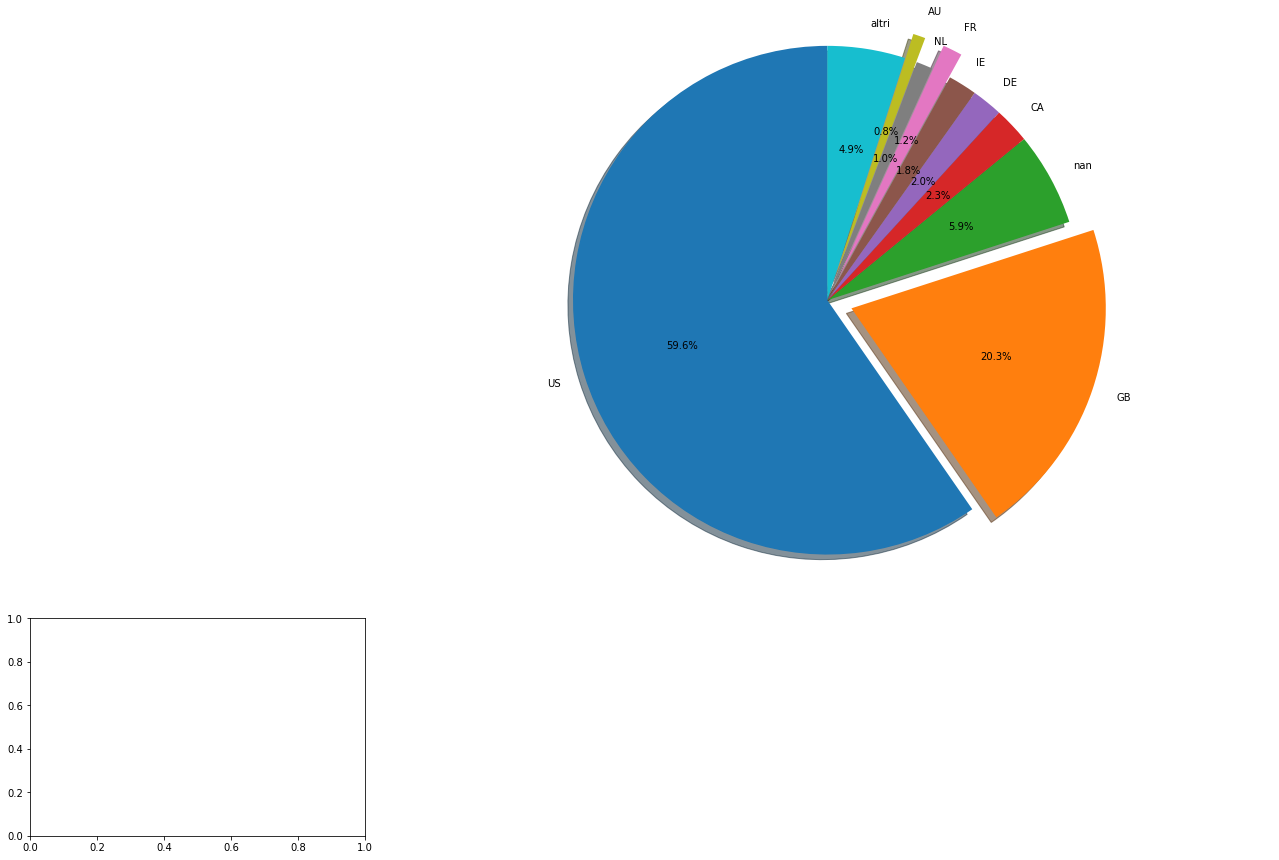

In [ ]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = nomi
sizes = num
explode = (0, 0.1, 0, 0, 0, 0, 0.1, 0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
fig1, ax1 = plt.subplots()
ax1 = fig1.add_axes([1,1,2,2])
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, frame=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### analisi Vader

In [ ]:
new_train = pd.read_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/news_train_less_vader.csv")
new_train = new_train.drop(columns='Unnamed: 0')

In [ ]:
articles_DF = pd.read_csv('/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/articles_DF.csv')
articles_DF = articles_DF.drop(columns='Unnamed: 0')
print(articles_DF)

                                                      txt  ... afinn
0       source: obama interfered in the brexit vote, n...  ...  -4.0
1       for the last few months, we have been told tha...  ...  -3.0
2       in the us, after the success of donald trump i...  ...   0.0
3       hillary clinton, barack obama and certain elem...  ...   5.0
4       as is the case with numerous other allegations...  ...  -2.0
...                                                   ...  ...   ...
842707  it is also essential to avoid major disruption...  ...   0.0
842708  we call on theresa may to take this opportunit...  ...   2.0
842709        we are not bargaining chips, we are people.  ...   0.0
842710  “we are also positive regarding the suggestion...  ...   3.0
842711                                      FINE ARTICOLO  ...   NaN

[842712 rows x 3 columns]


In [ ]:
id = articles_DF[articles_DF['txt'] == "FINE ARTICOLO"].index

In [ ]:
# creo la somma delle sentence dello stesso articolo
tot_score = []
for row in new_train.iterrows():
  #print(row)
  sum = []
  sum = tot_afinn_article(id, row[1])
  tot_score.append(sum)

In [ ]:
new_train['afinn'] = tot_score

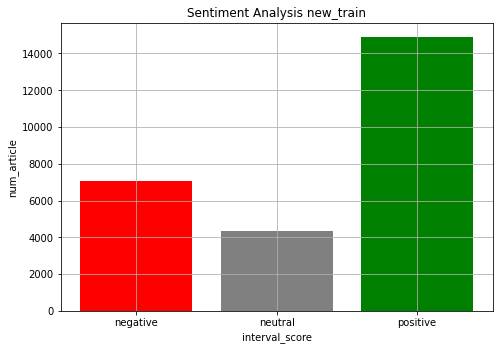

In [ ]:
################################################## AFINN ######################################
scores = new_train['afinn'].values.tolist()
df = count_scores(scores)
colors = ["red","gray","green"]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
intervels = df.index
num = df['count'].values.tolist()
ax.bar(intervels,num, color=colors)
plt.xlabel('interval_score')
plt.ylabel('num_article')
plt.title("Sentiment Analysis Afinn new_train")
plt.grid(True)
plt.show()

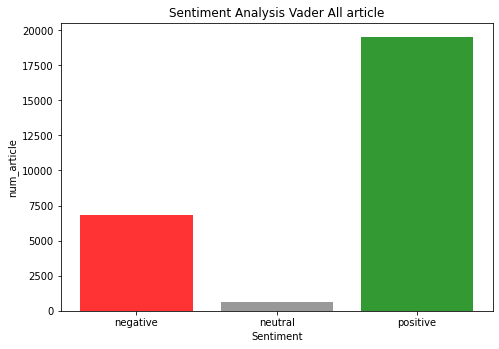

In [ ]:
################################################## VADER ######################################
scores = new_train['compound'].values.tolist()
df = count_scores_vader(scores)
colors = ["red","gray","green"]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
intervels = df.index
num = df['count'].values.tolist()
ax.bar(intervels,num, color=colors,alpha=0.8)
plt.xlabel('Sentiment')
plt.ylabel('num_article')
plt.title("Sentiment Analysis Vader All article")
plt.show()

In [ ]:
df

count
negative   6851
neutral     609
positive  19548

In [ ]:
new_train['date'] =pd.to_datetime(new_train.date)
new_train['month'] = [s[1]['date'].month for s in new_train.iterrows()]
month_groupby = Counter(new_train['month'])
#df['date_f'] = [d.date() for d in df['date']]
#df_dategroup_notzero = df_dategroup.drop(df_dategroup[df_dategroup["count"] == 0].index)
#df_dategroup_notzero
month_groupby

Counter({1: 5916, 2: 5036, 3: 5396, 4: 2520, 11: 180, 12: 7960})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


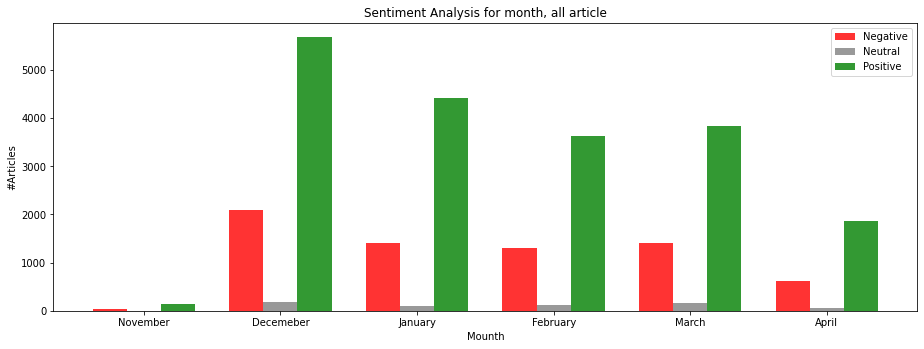

In [ ]:
count_neg_tot = []
count_neutral_tot = []
count_pos_tot = []
for month in [11,12,1,2,3,4]:
  all_i = new_train.loc[new_train['month'] == month]
  scores = all_i['compound'].values.tolist()
  df = count_scores_vader(scores)
  count_neg_tot.append(df['count'][0])
  count_neutral_tot.append(df['count'][1])
  count_pos_tot.append(df['count'][2])
# data to plot
n_groups = len(list(month_groupby.keys()))

# create plot
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
index = np.arange(len(list(month_groupby.keys())))
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, count_neg_tot, bar_width,alpha=opacity,color='r',label='Negative')

rects2 = plt.bar(index + bar_width, count_neutral_tot, bar_width,alpha=opacity,color='gray',label='Neutral')

rects3 = plt.bar(index + (bar_width*2), count_pos_tot, bar_width,alpha=opacity,color='green',label='Positive')

plt.xlabel('Mounth')
plt.ylabel('#Articles')
plt.title('Sentiment Analysis for month, all article')
plt.xticks(index + bar_width, ("November","Decemeber","January","February","March","April"))
plt.legend()

plt.tight_layout()
plt.show()

#### All articles not english

In [ ]:
urls_parse_groupby_DF = pd.read_csv('/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/urls_parse_groupby_DF.csv')
urls_parse_groupby_DF = urls_parse_groupby_DF.drop(columns='Unnamed: 0')
news_paper_not_english = []
news_paper_not_english = [row[1]['url'] for row in urls_parse_groupby_DF.iterrows() if row[1]['origin'] != "GB"]
news_paper_not_english

In [ ]:
ulrs_parse_nt = new_train['url'].apply(lambda x: urlparse(x).netloc)
new_train['url_domain'] = ulrs_parse_nt
new_train.head()

In [ ]:
train_not_english = new_train[new_train['url_domain'].isin(news_paper_not_english)]
train_not_english

In [ ]:
id = articles_DF[articles_DF['txt'] == "FINE ARTICOLO"].index

In [ ]:
# creo la somma delle sentence dello stesso articolo
tot_score = []
for row in train_not_english.iterrows():
  #print(row)
  sum = []
  sum = tot_afinn_article(id, row[1])
  tot_score.append(sum)

In [ ]:
print(len(tot_score))
print(len(train_not_english))

15009
15009


In [ ]:
train_not_english['afinn'] = tot_score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
################################################## AFINN ######################################
scores = train_not_english['afinn'].values.tolist()
df = count_scores(scores)
colors = ["red","gray","green"]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
intervels = df.index
num = df['count'].values.tolist()
ax.bar(intervels,num, color=colors)
plt.xlabel('Sentiment analysis')
plt.ylabel('num_article')
plt.title("Sentiment Analysis train_not_english")
plt.grid(True)
plt.show()

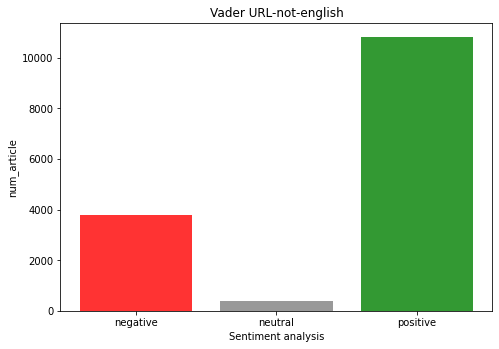

In [ ]:
################################################## VADER ######################################
scores = train_not_english['compound'].values.tolist()
df = count_scores_vader(scores)
colors = ["red","gray","green"]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
intervels = df.index
num = df['count'].values.tolist()
ax.bar(intervels,num, color=colors,alpha=0.8)
plt.xlabel('Sentiment analysis')
plt.ylabel('num_article')
plt.title("Vader URL-not-english")
plt.grid(False)
plt.show()

In [ ]:
train_not_english['date'] =pd.to_datetime(train_not_english.date)
train_not_english['month'] = [s[1]['date'].month for s in train_not_english.iterrows()]
month_groupby = Counter(train_not_english['month'])
#df['date_f'] = [d.date() for d in df['date']]
#df_dategroup_notzero = df_dategroup.drop(df_dategroup[df_dategroup["count"] == 0].index)
#df_dategroup_notzero
month_groupby

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Counter({1: 3279, 2: 2722, 3: 3046, 4: 1420, 11: 60, 12: 4482})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


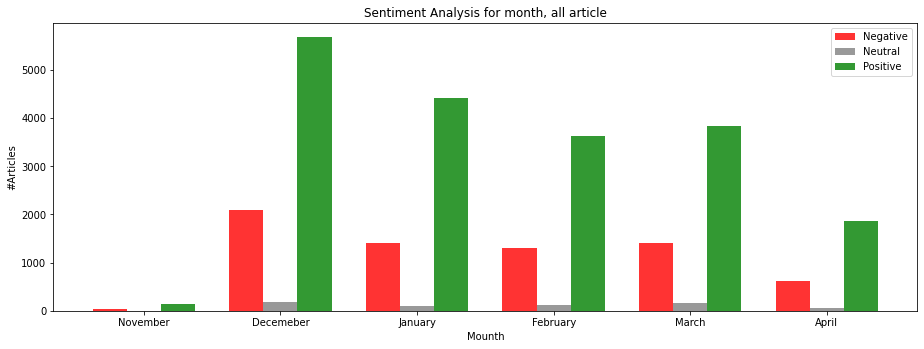

In [ ]:
count_neg_tot = []
count_neutral_tot = []
count_pos_tot = []
for month in [11,12,1,2,3,4]:
  all_i = new_train.loc[new_train['month'] == month]
  scores = all_i['compound'].values.tolist()
  df = count_scores_vader(scores)
  count_neg_tot.append(df['count'][0])
  count_neutral_tot.append(df['count'][1])
  count_pos_tot.append(df['count'][2])
# data to plot
n_groups = len(list(month_groupby.keys()))

# create plot
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
index = np.arange(len(list(month_groupby.keys())))
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, count_neg_tot, bar_width,alpha=opacity,color='r',label='Negative')

rects2 = plt.bar(index + bar_width, count_neutral_tot, bar_width,alpha=opacity,color='gray',label='Neutral')

rects3 = plt.bar(index + (bar_width*2), count_pos_tot, bar_width,alpha=opacity,color='green',label='Positive')

plt.xlabel('Mounth')
plt.ylabel('#Articles')
plt.title('Sentiment Analysis for month, all article')
plt.xticks(index + bar_width, ("November","Decemeber","January","February","March","April"))
plt.legend()

plt.tight_layout()
plt.show()

### Minister


In [ ]:
cnt_pos = Counter()
for asp in dataset["aspetti"]:
    for item in asp:
        if item["cluster"] == "minister":
          cnt_pos[item["aspetto"]] += 1
cnt_pos.most_common(300)

In [ ]:
pos = 0
neg = 0
neut = 0
for asp in dataset["aspetti"]:
    for item in asp:
        if item["aspetto"] == "economy":
            if item["sentiment"]["compound"] > 0:
                    pos = pos +1
            if  item["sentiment"]["compound"] == 0:
                    neut = neut +1
            if item["sentiment"]["compound"] < 0:
                    neg = neg +1
print(pos)
print(neut)
print(neg)

1162
7111
447


In [ ]:
pos = 0
neg = 0
neut = 0
for asp in dataset["aspetti"]:
    for item in asp:
        if item["aspetto"] == "immigration":
            if item["sentiment"]["compound"] > 0:
                    pos = pos +1
            if  item["sentiment"]["compound"] == 0:
                    neut = neut +1
            if item["sentiment"]["compound"] < 0:
                    neg = neg +1
print(pos)
print(neut)
print(neg)

175
1010
268


In [ ]:
pos = 0
neg = 0
neut = 0
for asp in dataset["aspetti"]:
    for item in asp:
        if item["aspetto"] == "country":
            if item["sentiment"]["compound"] > 0:
                    pos = pos +1
            if  item["sentiment"]["compound"] == 0:
                    neut = neut +1
            if item["sentiment"]["compound"] < 0:
                    neg = neg +1
print(pos)
print(neut)
print(neg)

1806
8923
695


In [ ]:
pos = 0
neg = 0
neut = 0
for asp in dataset["aspetti"]:
    for item in asp:
        if item["aspetto"] == "party":
            if item["sentiment"]["compound"] > 0:
                    pos = pos +1
            if  item["sentiment"]["compound"] == 0:
                    neut = neut +1
            if item["sentiment"]["compound"] < 0:
                    neg = neg +1
print(pos)
print(neut)
print(neg)

491
11879
632


In [ ]:
pos = 0
neg = 0
neut = 0
for asp in dataset["aspetti"]:
    for item in asp:
        if item["aspetto"] == "government":
            if item["sentiment"]["compound"] > 0:
                    pos = pos +1
            if  item["sentiment"]["compound"] == 0:
                    neut = neut +1
            if item["sentiment"]["compound"] < 0:
                    neg = neg +1
print(pos)
print(neut)
print(neg)

1051
12042
561


In [ ]:
pos = 0
neg = 0
neut = 0
for asp in dataset["aspetti"]:
    for item in asp:
        if item["aspetto"] == "minister":
            if item["sentiment"]["compound"] > 0:
                    pos = pos +1
            if  item["sentiment"]["compound"] == 0:
                    neut = neut +1
            if item["sentiment"]["compound"] < 0:
                    neg = neg +1
print(pos)
print(neut)
print(neg)

405
22271
225


In [ ]:
pos = 0
neg = 0
neut = 0
for asp in dataset["aspetti"]:
    for item in asp:
        if item["aspetto"] == "market":
            if item["sentiment"]["compound"] > 0:
                    pos = pos +1
            if  item["sentiment"]["compound"] == 0:
                    neut = neut +1
            if item["sentiment"]["compound"] < 0:
                    neg = neg +1
print(pos)
print(neut)
print(neg)

1405
14952
326


In [ ]:
pos = 0
neg = 0
neut = 0
for asp in dataset["aspetti"]:
    for item in asp:
        if item["aspetto"] == "vote":
            if item["sentiment"]["compound"] > 0:
                    pos = pos +1
            if  item["sentiment"]["compound"] == 0:
                    neut = neut +1
            if item["sentiment"]["compound"] < 0:
                    neg = neg +1
print(pos)
print(neut)
print(neg)

882
6389
517


In [ ]:
pos = 0
neg = 0
neut = 0
for asp in dataset["aspetti"]:
    for item in asp:
        if item["aspetto"] == "trade":
            if item["sentiment"]["compound"] > 0:
                    pos = pos +1
            if  item["sentiment"]["compound"] == 0:
                    neut = neut +1
            if item["sentiment"]["compound"] < 0:
                    neg = neg +1
print(pos)
print(neut)
print(neg)

4013
3249
151


In [ ]:
pos = 0
neg = 0
neut = 0
for asp in dataset["aspetti"]:
    for item in asp:
        if item["aspetto"] == "election":
            if item["sentiment"]["compound"] > 0:
                    pos = pos +1
            if  item["sentiment"]["compound"] == 0:
                    neut = neut +1
            if item["sentiment"]["compound"] < 0:
                    neg = neg +1
print(pos)
print(neut)
print(neg)

282
6966
151


### People

In [ ]:
cnt_pos = Counter()
for asp in dataset["aspetti"]:
    for item in asp:
        if item["aspetto"] == "corbyn":
          cnt_pos[item["aspetto"]] += 1
cnt_pos.most_common(100)

[('corbyn', 312)]

In [ ]:
cnt_pos = Counter()
for asp in dataset["aspetti"]:
    for item in asp:
        if item["cluster"] == "people":
          cnt_pos[item["aspetto"]] += 1
cnt_pos.most_common(100)

[('people', 11879),
 ('politics', 3201),
 ('data', 2169),
 ('brussels', 1067),
 ('men', 899),
 ('earnings', 593),
 ('others', 460),
 ('police', 443),
 ('us', 411),
 ('netherlands', 333),
 ('economics', 329),
 ('brexiteers', 294),
 ('headquarters', 283),
 ('remainers', 229),
 ('expat', 202),
 ('meps', 190),
 ('€', 170),
 ('odds', 135),
 ('states', 132),
 ('personnel', 116),
 ('policymakers', 115),
 ('protestors', 111),
 ('fish', 105),
 ('eurosceptics', 104),
 ('ups', 103),
 ('jones', 102),
 ('brexiters', 101),
 ('smes', 98),
 ('reuters', 97),
 ('proceeds', 95),
 ('analytics', 89),
 ('clothes', 85),
 ('businessmen', 84),
 ('dems', 84),
 ('multinationals', 82),
 ('msps', 76),
 ('lens', 74),
 ('financials', 72),
 ('thanks', 72),
 ('services', 69),
 ('europeans', 67),
 ('yuan', 66),
 ('millennials', 65),
 ('negotiations', 64),
 ('globalists', 63),
 ('remoaners', 62),
 ('rogers', 61),
 ('barclays', 61),
 ('corporates', 60),
 ('markets', 58),
 ('rights', 58),
 ('makers', 55),
 ('brexits', 55)

In [ ]:
pos = 0
neg = 0
neut = 0
for asp in dataset["aspetti"]:
    for item in asp:
        if item["aspetto"] in ["immigrant", "migrant", "immigration"]:
            if item["sentiment"]["compound"] > 0:
                    pos = pos +1
            if  item["sentiment"]["compound"] == 0:
                    neut = neut +1
            if item["sentiment"]["compound"] < 0:
                    neg = neg +1
print(pos)
print(neut)
print(neg)

268
1959
395


### deal

In [ ]:
cnt_pos = Counter()
for asp in dataset["aspetti"]:
    for item in asp:
        if item["cluster"] == "deal":
          cnt_pos[item["aspetto"]] += 1
cnt_pos.most_common(300)

### firm


In [ ]:
cnt_pos = Counter()
for asp in dataset["aspetti"]:
    for item in asp:
        if item["cluster"] == "firm":
          cnt_pos[item["aspetto"]] += 1
cnt_pos.most_common(300)

[('minister', 22901),
 ('union', 16703),
 ('market', 16683),
 ('government', 13654),
 ('party', 13002),
 ('year', 11995),
 ('country', 11424),
 ('time', 9149),
 ('economy', 8720),
 ('policy', 8501),
 ('term', 8214),
 ('state', 8051),
 ('vote', 7788),
 ('trade', 7413),
 ('election', 7399),
 ('brexit', 7283),
 ('leader', 7216),
 ('service', 7103),
 ('company', 6867),
 ('europe', 6077),
 ('world', 5844),
 ('movement', 5793),
 ('issue', 5777),
 ('britain', 5556),
 ('parliament', 5462),
 ('court', 5342),
 ('growth', 5247),
 ('group', 5230),
 ('business', 5074),
 ('system', 5018),
 ('bank', 4950),
 ('way', 4878),
 ('sector', 4802),
 ('kingdom', 4648),
 ('rate', 4488),
 ('agreement', 4293),
 ('thing', 4224),
 ('president', 4189),
 ('value', 4144),
 ('process', 4012),
 ('house', 3939),
 ('relationship', 3921),
 ('nation', 3871),
 ('order', 3602),
 ('interest', 3561),
 ('crisis', 3530),
 ('power', 3505),
 ('force', 3423),
 ('area', 3401),
 ('negotiation', 3387),
 ('industry', 3333),
 ('day', 33

In [ ]:
cnt_pos = Counter()
for asp in dataset["aspetti"]:
    for item in asp:
        if item["aspetto"] == "labour":
            cnt_pos[item["desc"]] += 1
cnt_pos.most_common(50)

In [ ]:
cnt_pos = Counter()
for asp in asp_json:
        if asp["aspetto"] == "uk":
            cnt_pos[asp["desc"]] += 1
cnt_pos.most_common(50)

In [ ]:
positive_tot = []
negative_tot = []

for asp in dataset["aspetti"]:
    for item in asp:
            elements = elements+1
            if item["sentiment"]["compound"] > 0:
                positive_tot.append(item)
            if item["sentiment"]["compound"] < 0:
                negative_tot.append(item)
print("------------------------")
print("Tot: ", elements)
print("positive_tot ", len(positive_tot))
print("negative ", len(negative_tot))



------------------------
Tot:  1557098
positive_tot  185481
negative  96922


In [ ]:
import pickle
with open("positive_tot.pkl", "wb") as writer:
    pickle.dump(positive_tot, writer)

with open("positive_tot.pkl", "wb") as writer:
    pickle.dump(negative_tot, writer)

### Politics

In [ ]:


politics = ["minister", "government", "party", "policy", "leader", "parliament", "president", "crisis", "politicians", "politics", "msps", "democracy"]
pos_polis = 0
neg_polis = 0
neut_polis = 0
elements = 0

for item in dataset["aspetti"]:
    for asp in item:
        if asp["aspetto"] in politics:
            elements = elements+1
            if asp["sentiment"]["compound"] > 0:
                pos_polis = pos_polis +1
            if  asp["sentiment"]["compound"] == 0:
                neut_polis = neut_polis +1
            if asp["sentiment"]["compound"] < 0:
                neg_polis = neg_polis +1
print("------------------------")
print("Tot: ", elements)
print("Label   :", "politics")
print("positive ", pos_polis)
print("neg_polisative ", neg_polis)
print("neutral ", neut_polis)

------------------------
Tot:  83599
Label   : politics
positive  3875
neg_polisative  2644
neutral  77080


In [ ]:
politics = ["minister", "government", "party", "policy", "leader", "parliament", "president", "crisis", "politicians", "politics", "msps", "democracy"]
cnt_positivo = Counter()
for asp in positive_tot:
    if asp["aspetto"] in politics:
        cnt_positivo[asp["desc"]] += 1
cnt_positivo.most_common(10)

[('clear', 261),
 ('great', 173),
 ('strong', 171),
 ('important', 135),
 ('good', 128),
 ('successive', 97),
 ('united', 91),
 ('popular', 81),
 ('effective', 69),
 ('best', 61)]

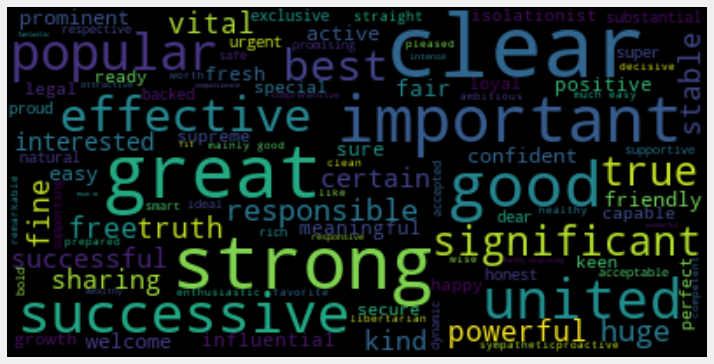

In [ ]:
plot_wordcloud(cnt_positivo)

In [ ]:
politics = ["minister", "government", "party", "policy", "leader", "parliament", "president", "crisis", "politicians", "politics", "msps", "democracy"]
cnt_negativo = Counter()
for asp in negative_tot:
    if asp["aspetto"] in politics:
        cnt_negativo[asp["desc"]] += 1
cnt_negativo.most_common(10)

[('anti', 477),
 ('bad', 109),
 ('low', 64),
 ('difficult', 58),
 ('hard', 56),
 ('rebel', 50),
 ('controversial', 43),
 ('weak', 43),
 ('critical', 38),
 ('dangerous', 32)]

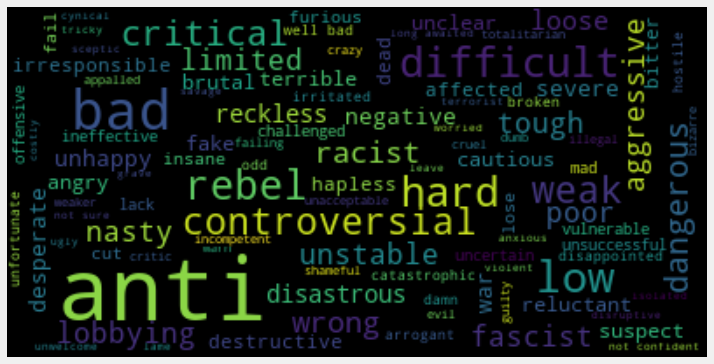

In [ ]:
plot_wordcloud(cnt_negativo)

In [ ]:
labour = ["corbyn", "labour"]
pos_labour = 0
neg_labour = 0
neut_labour = 0
elements = 0

for item in dataset["aspetti"]:
    for asp in item:
        if asp["aspetto"] in labour:
            elements = elements+1
            if asp["sentiment"]["compound"] > 0:
                pos_labour = pos_labour +1
            if  asp["sentiment"]["compound"] == 0:
                neut_labour = neut_labour +1
            if asp["sentiment"]["compound"] < 0:
                neg_labour = neg_labour +1
print("------------------------")
print("Tot: ", elements)
print("Label   :", "labour")
print("positive ", pos_labour)
print("negative ", neg_labour)
print("neut_labourral ", neut_labour)

------------------------
Tot:  1795
Label   : labour
positive  182
negative  157
neut_labourral  1456


In [ ]:
corbyn = ["corbyn", "labour"]
cnt_positivo = Counter()
for asp in positive_tot:
    if asp["aspetto"] in corbyn:
        cnt_positivo[asp["desc"]] += 1
cnt_positivo.most_common(10)

[('clear', 28),
 ('strong', 15),
 ('reliant', 10),
 ('good', 9),
 ('loyal', 5),
 ('huge', 4),
 ('confident', 4),
 ('positive', 3),
 ('easy', 3),
 ('best', 3)]

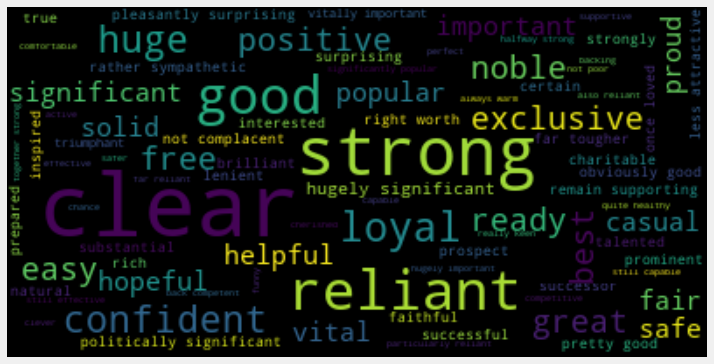

In [ ]:
plot_wordcloud(cnt_positivo)

In [ ]:
labour = ["corbyn", "labour"]
cnt_negativo = Counter()
for asp in negative_tot:
    if asp["aspetto"] in labour:
        cnt_negativo[asp["desc"]] += 1
cnt_negativo.most_common(10)

[('bad', 11),
 ('rebel', 10),
 ('critical', 5),
 ('hostile', 4),
 ('difficult', 4),
 ('weak', 4),
 ('anti', 4),
 ('hapless', 4),
 ('mock', 4),
 ('disastrous', 4)]

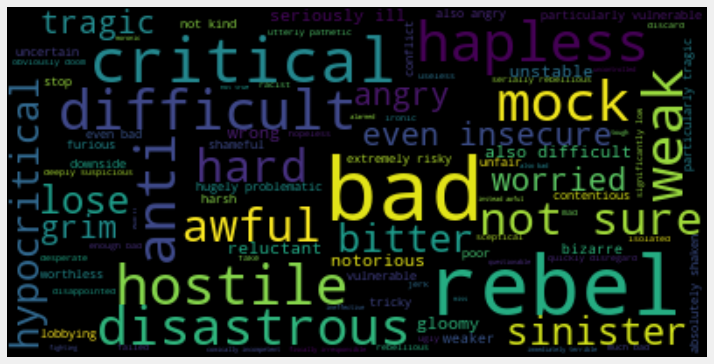

In [ ]:
plot_wordcloud(cnt_negativo)

In [ ]:
theresa = ["conservative", "theresa",  "may"]
pos_ther = 0
neg_ther = 0
neut_ther = 0
elements = 0

for item in dataset["aspetti"]:
    for asp in item:
        if asp["aspetto"] in theresa:
            elements = elements+1
            if asp["sentiment"]["compound"] > 0:
                pos_ther = pos_ther +1
            if  asp["sentiment"]["compound"] == 0:
                neut_ther = neut_ther +1
            if asp["sentiment"]["compound"] < 0:
                neg_ther = neg_ther +1
print("------------------------")
print("Tot: ", elements)
print("Label   :", "theresa")
print("pos_theritive ", pos_ther)
print("negative ", neg_ther)
print("neut_therral ", neut_ther)

------------------------
Tot:  1501
Label   : theresa
pos_theritive  160
negative  167
neut_therral  1174


In [ ]:
theresa = ["conservative", "theresa",  "may"]
cnt_positivo = Counter()
for asp in positive_tot:
    if asp["aspetto"] in theresa:
        cnt_positivo[asp["desc"]] += 1


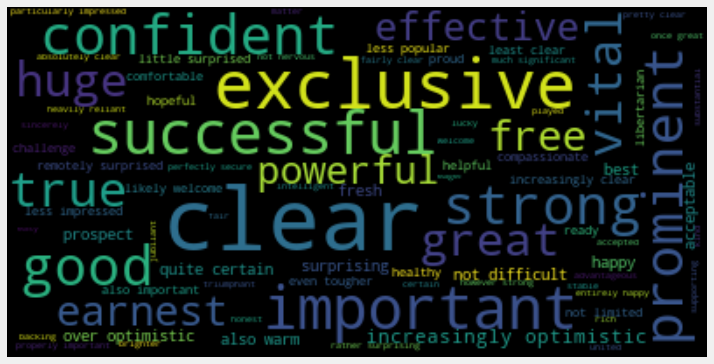

In [ ]:
plot_wordcloud(cnt_positivo)

In [ ]:
theresa = ["conservative", "theresa",  "may"]
cnt_negativo = Counter()
for asp in negative_tot:
    if asp["aspetto"] in theresa:
        cnt_negativo[asp["desc"]] += 1


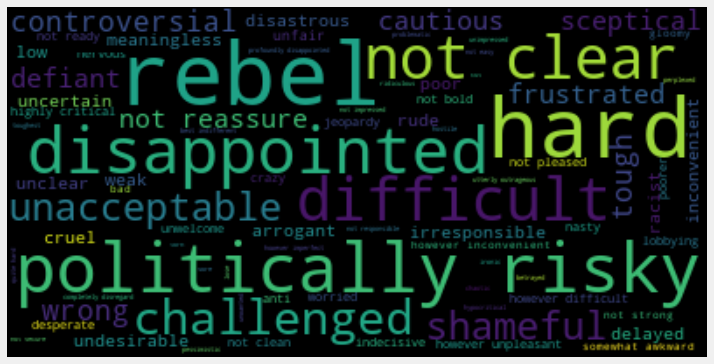

In [ ]:
plot_wordcloud(cnt_negativo)

#### party Labour- Conservative Theresa Corbyn

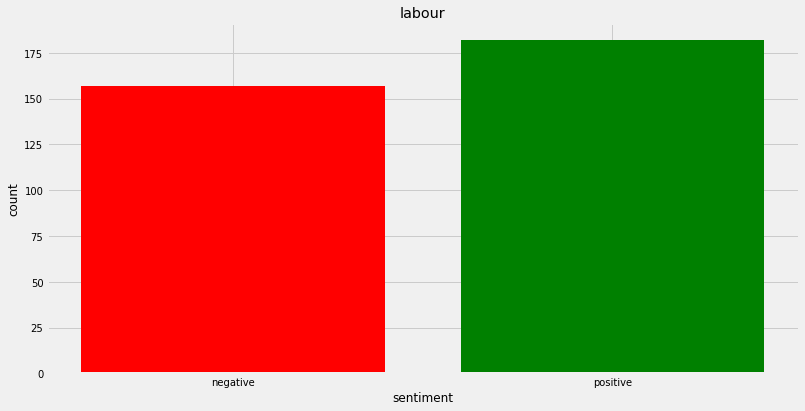

In [ ]:
import matplotlib.pyplot as plt

# x-coordinates of left sides of bars 

left = [1,2]

# heights of bars
height = [neg, pos]

# labels for bars
tick_label = ['negative', 'positive']

# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

# naming the x-axis
plt.xlabel('sentiment')
# naming the y-axis
plt.ylabel('count')
# plot title
plt.title("labour")

plt.savefig("labour.jpg")
# function to show the plot
plt.show()


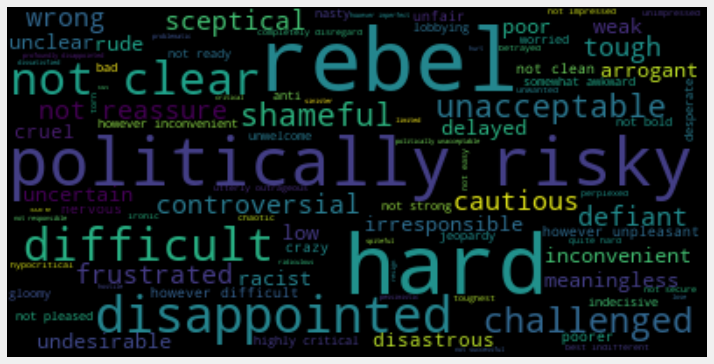

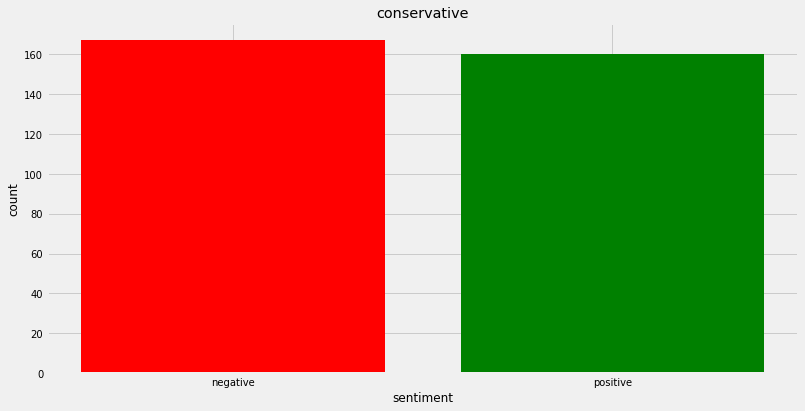

In [ ]:
import matplotlib.pyplot as plt

# x-coordinates of left sides of bars 

left = [1,2]

# heights of bars
height = [neg, pos]

# labels for bars
tick_label = ['negative', 'positive']

# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

# naming the x-axis
plt.xlabel('sentiment')
# naming the y-axis
plt.ylabel('count')
# plot title
plt.title("conservative")

plt.savefig("conservative.jpg")
# function to show the plot
plt.show()


### Europe

In [ ]:
europe = ["brussels", "europe", "union", "farage", "europeans", "eurosceptics", "germany", "italy", "euro", "eu"]
pos = 0
neg = 0
neut = 0
elements = 0

for item in dataset["aspetti"]:
    for asp in item:
        if asp["aspetto"] in europe:
            elements = elements+1
            if asp["sentiment"]["compound"] > 0:
                pos = pos +1
            if  asp["sentiment"]["compound"] == 0:
                neut = neut +1
            if asp["sentiment"]["compound"] < 0:
                neg = neg +1
print("------------------------")
print("Tot: ", elements)
print("Label   :", "europe")
print("positive ", pos)
print("negative ", neg)
print("neutral ", neut)

------------------------
Tot:  26885
Label   : europe
positive  1960
negative  820
neutral  24105


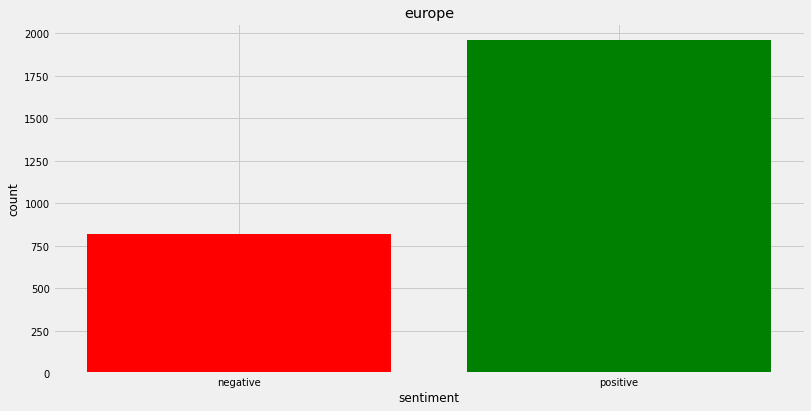

In [ ]:
import matplotlib.pyplot as plt

# x-coordinates of left sides of bars 

left = [1,2]

# heights of bars
height = [neg, pos]

# labels for bars
tick_label = ['negative', 'positive']

# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

# naming the x-axis
plt.xlabel('sentiment')
# naming the y-axis
plt.ylabel('count')
# plot title
plt.title("europe")

plt.savefig("europe.jpg")
# function to show the plot
plt.show()


In [ ]:
europe = ["brussels", "europe", "union", "europeans", "eurosceptics", "germany", "italy", "euro", "eu"]
cnt_positivo = Counter()
for asp in positive_tot:
    if asp["aspetto"] in europe:
        cnt_positivo[asp["desc"]] += 1
cnt_positivo.most_common(10)

[('united', 326),
 ('strong', 198),
 ('good', 112),
 ('clear', 73),
 ('free', 73),
 ('great', 72),
 ('important', 61),
 ('precious', 50),
 ('best', 39),
 ('secure', 38)]

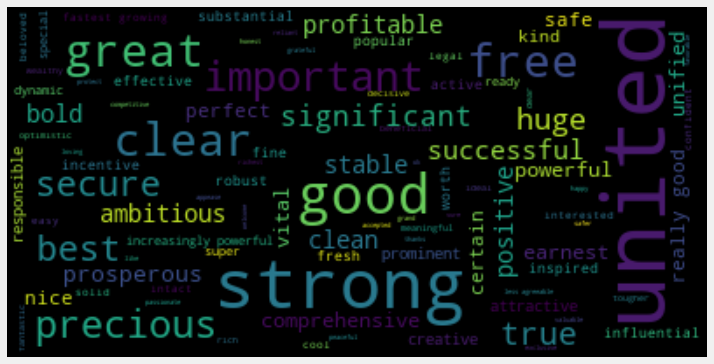

In [ ]:
plot_wordcloud(cnt_positivo)

In [ ]:
europe = ["brussels", "europe", "union", "farage", "europeans", "eurosceptics", "germany", "italy", "euro", "eu"]
cnt_negativo = Counter()
for asp in negative_tot:
    if asp["aspetto"] in europe:
        cnt_negativo[asp["desc"]] += 1
cnt_negativo.most_common(10)

[('anti', 71),
 ('low', 49),
 ('bad', 39),
 ('hard', 32),
 ('weaker', 25),
 ('weak', 19),
 ('terrorist', 15),
 ('war', 14),
 ('critical', 13),
 ('difficult', 12)]

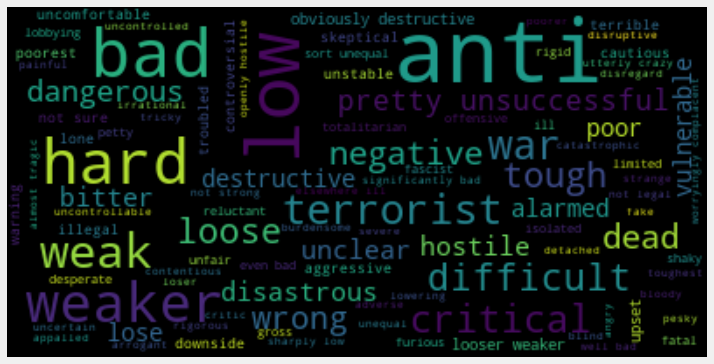

In [ ]:
plot_wordcloud(cnt_negativo)

### Brexit

In [ ]:

pos = 0
neg = 0
neut = 0
elements = 0

for item in dataset["aspetti"]:
    for asp in item:
        if asp["aspetto"] == "brexit":
            elements = elements+1
            if asp["sentiment"]["compound"] > 0:
                pos = pos +1
            if  asp["sentiment"]["compound"] == 0:
                neut = neut +1
            if asp["sentiment"]["compound"] < 0:
                neg = neg +1
print("------------------------")
print("Tot: ", elements)
print("Label   :", "brexit")
print("positive ", pos)
print("negative ", neg)
print("neutral ", neut)

------------------------
Tot:  7283
Label   : brexit
positive  720
negative  2853
neutral  3710


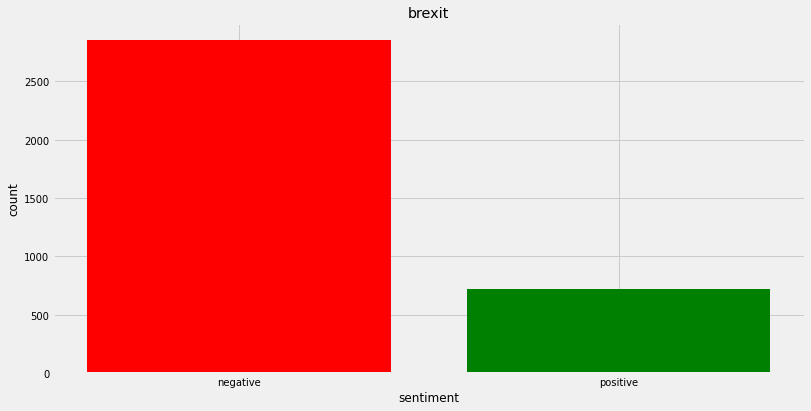

In [ ]:
import matplotlib.pyplot as plt

# x-coordinates of left sides of bars 

left = [1,2]

# heights of bars
height = [neg, pos]

# labels for bars
tick_label = ['negative', 'positive']

# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

# naming the x-axis
plt.xlabel('sentiment')
# naming the y-axis
plt.ylabel('count')
# plot title
plt.title("brexit")

plt.savefig("brexit.jpg")
# function to show the plot
plt.show()


In [ ]:

cnt_negativo = Counter()
for asp in negative_tot:
    if asp["aspetto"] == "brexit":
        cnt_negativo[asp["desc"]] += 1
cnt_negativo.most_common(10)

[('hard', 2289),
 ('disastrous', 38),
 ('affected', 25),
 ('bad', 24),
 ('wrong', 23),
 ('fake', 19),
 ('uncertain', 14),
 ('cut', 12),
 ('destructive', 12),
 ('brexit affected', 10)]

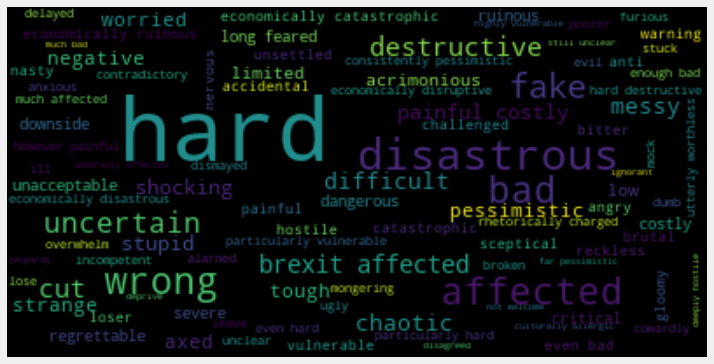

In [ ]:
plot_wordcloud(cnt_negativo)

In [ ]:

cnt_positivo = Counter()
for asp in positive_tot:
    if asp["aspetto"] == "brexit":
        cnt_positivo[asp["desc"]] += 1
cnt_positivo.most_common(10)

[('clean', 72),
 ('clear', 57),
 ('best', 39),
 ('successful', 31),
 ('good', 21),
 ('happy', 19),
 ('unified', 19),
 ('strong', 18),
 ('true', 17),
 ('grey', 16)]

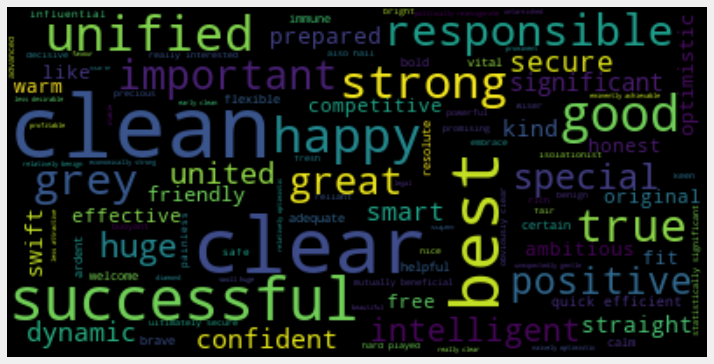

In [ ]:
plot_wordcloud(cnt_positivo)

In [ ]:
def count_scores_aspetti(month_data, label):
  count_neg = 0
  count_pos = 0
  count_neutral = 0
  for asp in month_data["aspetti"]:
        for item in asp:
            if item["aspetto"] == label:
                if item["sentiment"]["compound"] > 0:
                    count_pos = count_pos +1
                if  item["sentiment"]["compound"] == 0:
                    count_neutral = count_neutral +1
                if item["sentiment"]["compound"] < 0:
                    count_neg = count_neg +1
  df = pd.DataFrame([count_neg,count_neutral,count_pos], index=["negative","neutral","positive"], columns=["count"])
  return df

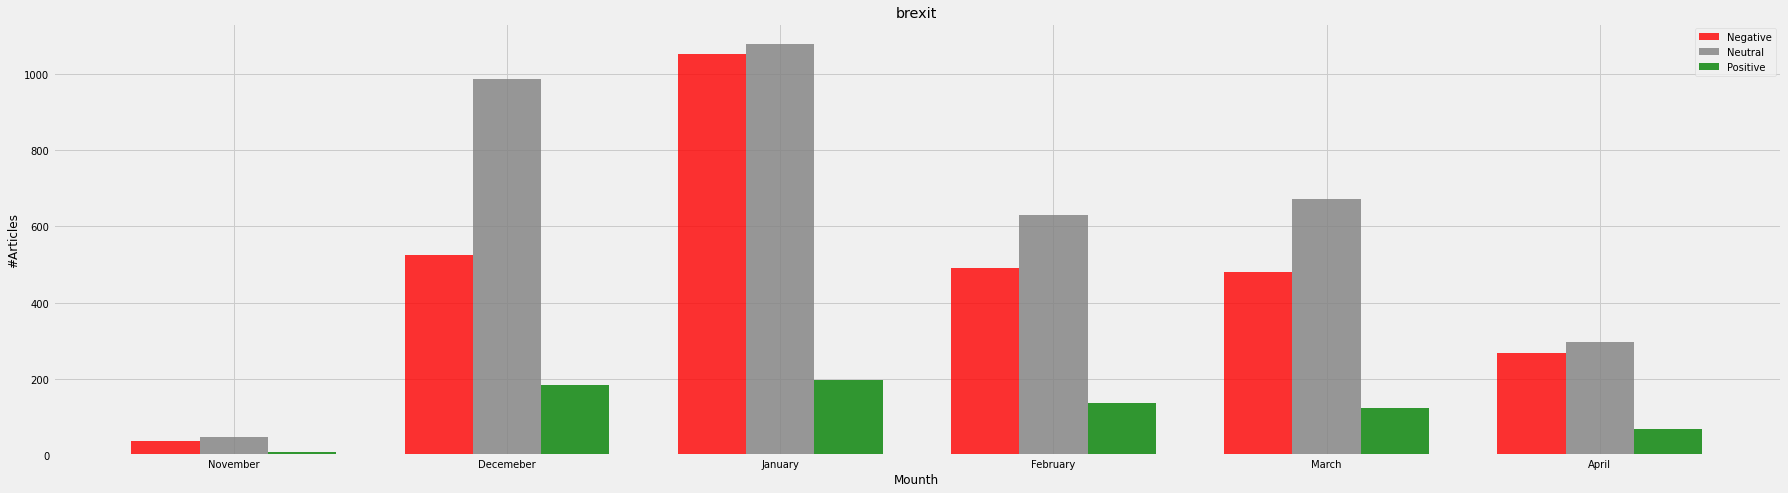

In [ ]:
count_neg_tot = []
count_neutral_tot = []
count_pos_tot = []
for month in [11,12,1,2,3,4]:
  all_i = dataset.loc[dataset['month'] == month]

  df = count_scores_aspetti(all_i, "brexit")
  count_neg_tot.append(df['count'][0])
  count_neutral_tot.append(df['count'][1])
  count_pos_tot.append(df['count'][2])
# data to plot
n_groups = len(list(month_groupby.keys()))

# create plot

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
index = np.arange(len(list(month_groupby.keys())))
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, count_neg_tot, bar_width,
alpha=opacity,
color='r',
label='Negative')

rects2 = plt.bar(index + bar_width, count_neutral_tot, bar_width,
alpha=opacity,
color='gray',
label='Neutral')

rects3 = plt.bar(index + (bar_width*2), count_pos_tot, bar_width,
alpha=opacity,
color='green',
label='Positive')

plt.xlabel('Mounth')
plt.ylabel('#Articles')
plt.title("brexit")
plt.xticks(index + bar_width, ("November","Decemeber","January","February","March","April"))
plt.legend()


plt.tight_layout()
plt.savefig("brexit_month.jpg")
plt.show()


### Immigration

In [ ]:
immigration = ["migration", "immigrant", "migrant", "muslim", "immigration"]
pos = 0
neg = 0
neut = 0
elements = 0

for item in dataset["aspetti"]:
    for asp in item:
        if asp["aspetto"] in immigration:
            elements = elements+1
            if asp["sentiment"]["compound"] > 0:
                pos = pos +1
            if  asp["sentiment"]["compound"] == 0:
                neut = neut +1
            if asp["sentiment"]["compound"] < 0:
                neg = neg +1
print("------------------------")
print("Tot: ", elements)
print("Label   :", "immigration")
print("positive ", pos)
print("negative ", neg)
print("neutral ", neut)

------------------------
Tot:  3996
Label   : immigration
positive  361
negative  500
neutral  3135


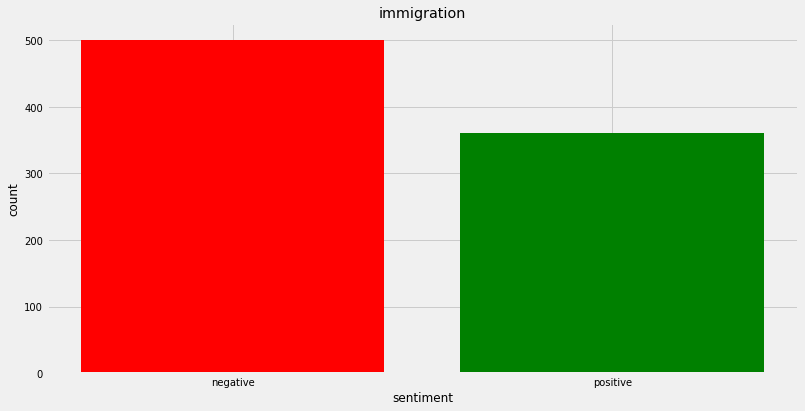

In [ ]:
import matplotlib.pyplot as plt

# x-coordinates of left sides of bars 

left = [1,2]

# heights of bars
height = [neg, pos]

# labels for bars
tick_label = ['negative', 'positive']

# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

# naming the x-axis
plt.xlabel('sentiment')
# naming the y-axis
plt.ylabel('count')
# plot title
plt.title("immigration")

plt.savefig("immigration.jpg")
# function to show the plot
plt.show()


In [ ]:
immigration = ["migration", "immigrant", "migrant", "muslim", "immigration"]
cnt_positivo = Counter()
for asp in positive_tot:
    if asp["aspetto"] in immigration:
        cnt_positivo[asp["desc"]] += 1
cnt_positivo.most_common(10)

[('free', 38),
 ('good', 26),
 ('clear', 19),
 ('legal', 18),
 ('great', 14),
 ('significant', 14),
 ('huge', 13),
 ('strong', 12),
 ('important', 12),
 ('fair', 11)]

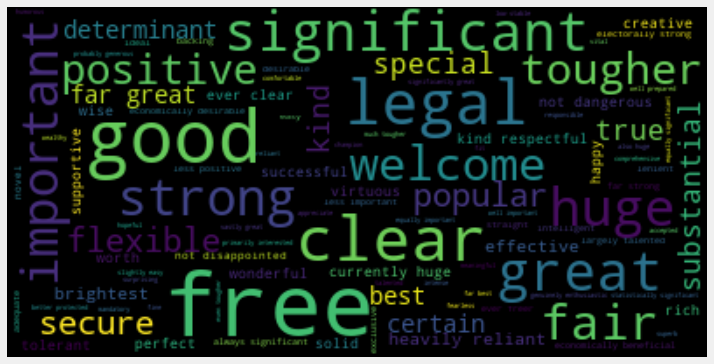

In [ ]:
plot_wordcloud(cnt_positivo)

In [ ]:
immigration = ["migration", "immigrant", "migrant", "muslim", "immigration"]
cnt_negativo = Counter()
for asp in negative_tot:
    if asp["aspetto"] in immigration:
        cnt_negativo[asp["desc"]] += 1
cnt_negativo.most_common(10)

[('illegal', 144),
 ('uncontrolled', 63),
 ('low', 40),
 ('tough', 24),
 ('hard', 16),
 ('anti', 15),
 ('bad', 10),
 ('poor', 9),
 ('cut', 7),
 ('negative', 6)]

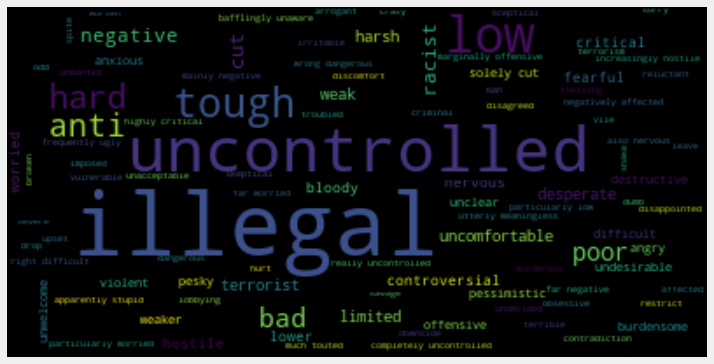

In [ ]:
plot_wordcloud(cnt_negativo)

### Deal

In [ ]:
deal = ["deal", "firm", "meeting", "offer", "future", "negotiation", "decision", "bill"]
pos = 0
neg = 0
neut = 0
elements = 0

for item in dataset["aspetti"]:
    for asp in item:
        if asp["aspetto"] in deal:
            elements = elements+1
            if asp["sentiment"]["compound"] > 0:
                pos = pos +1
            if  asp["sentiment"]["compound"] == 0:
                neut = neut +1
            if asp["sentiment"]["compound"] < 0:
                neg = neg +1
print("------------------------")
print("Tot: ", elements)
print("Label   :", "deal")
print("positive ", pos)
print("negative ", neg)
print("neutral ", neut)

------------------------
Tot:  25734
Label   : deal
positive  4235
negative  1969
neutral  19530


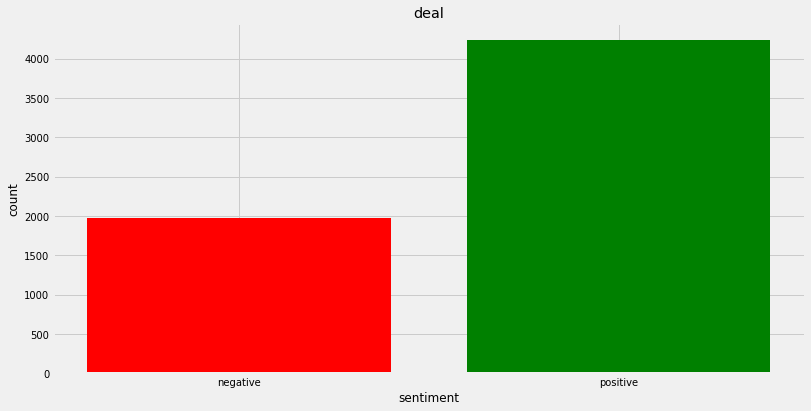

In [ ]:
import matplotlib.pyplot as plt

# x-coordinates of left sides of bars 

left = [1,2]

# heights of bars
height = [neg, pos]

# labels for bars
tick_label = ['negative', 'positive']

# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

# naming the x-axis
plt.xlabel('sentiment')
# naming the y-axis
plt.ylabel('count')
# plot title
plt.title("deal")

plt.savefig("deal.jpg")
# function to show the plot
plt.show()


In [ ]:
deal = ["deal", "firm", "meeting", "offer", "future", "negotiation", "decision", "bill"]
cnt_positivo = Counter()
for asp in positive_tot:
    if asp["aspetto"] in deal:
        cnt_positivo[asp["desc"]] += 1
cnt_positivo.most_common(10)

[('great', 563),
 ('good', 416),
 ('best', 281),
 ('special', 183),
 ('secure', 150),
 ('clear', 139),
 ('important', 130),
 ('meaningful', 117),
 ('bright', 92),
 ('comprehensive', 65)]

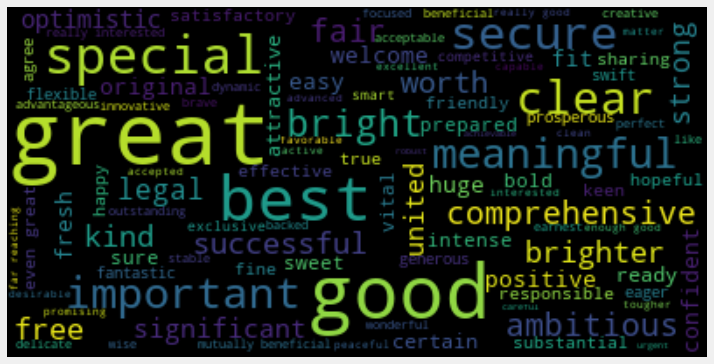

In [ ]:
plot_wordcloud(cnt_positivo)

In [ ]:
deal = ["deal", "firm", "meeting", "offer", "future", "negotiation", "decision", "bill"]
cnt_negativo = Counter()
for asp in negative_tot:
    if asp["aspetto"] in deal:
        cnt_negativo[asp["desc"]] += 1
cnt_negativo.most_common(10)

[('bad', 338),
 ('well bad', 181),
 ('difficult', 121),
 ('uncertain', 112),
 ('tough', 93),
 ('hard', 47),
 ('punitive', 45),
 ('wrong', 40),
 ('crude', 36),
 ('controversial', 27)]

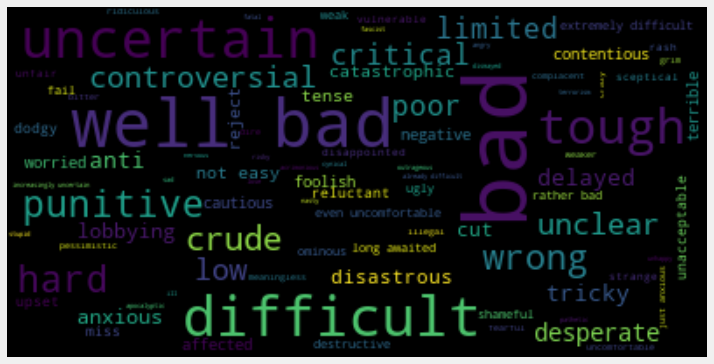

In [ ]:
plot_wordcloud(cnt_negativo)

### Referendum

In [ ]:
referendum = ["referendum", "vote", "election" "poll", "exit"]
pos = 0
neg = 0
neut = 0
elements = 0

for item in dataset["aspetti"]:
    for asp in item:
        if asp["aspetto"] in referendum:
            elements = elements+1
            if asp["sentiment"]["compound"] > 0:
                pos = pos +1
            if  asp["sentiment"]["compound"] == 0:
                neut = neut +1
            if asp["sentiment"]["compound"] < 0:
                neg = neg +1
print("------------------------")
print("Tot: ", elements)
print("Label   :", "referendum")
print("positive ", pos)
print("negative ", neg)
print("neutral ", neut)

------------------------
Tot:  30276
Label   : referendum
positive  2460
negative  3921
neutral  23895


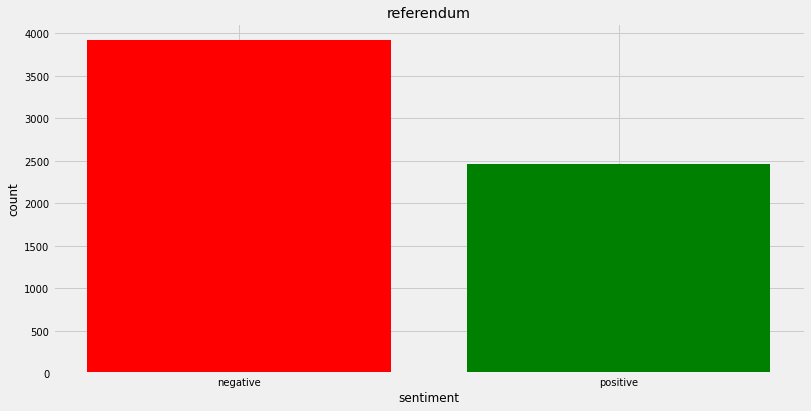

In [ ]:
import matplotlib.pyplot as plt

# x-coordinates of left sides of bars 

left = [1,2]

# heights of bars
height = [neg, pos]

# labels for bars
tick_label = ['negative', 'positive']

# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

# naming the x-axis
plt.xlabel('sentiment')
# naming the y-axis
plt.ylabel('count')
# plot title
plt.title("referendum")
plt.savefig("referendum.jpg")
# function to show the plot
plt.show()


In [ ]:
referendum = ["referendum", "vote", "election", "brexit", "poll", "exit"]
cnt_positivo = Counter()
for asp in positive_tot:
    if asp["aspetto"] in referendum:
        cnt_positivo[asp["desc"]] += 1
cnt_positivo.most_common(10)

[('popular', 186),
 ('clear', 183),
 ('fresh', 80),
 ('clean', 80),
 ('important', 78),
 ('strong', 73),
 ('united', 73),
 ('meaningful', 71),
 ('great', 61),
 ('free', 61)]

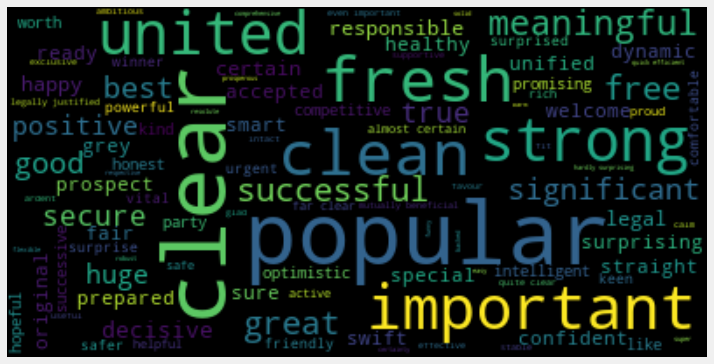

In [ ]:
plot_wordcloud(cnt_positivo)

In [ ]:
referendum = ["referendum", "vote", "election", "brexit", "poll", "exit"]
cnt_negativo = Counter()
for asp in negative_tot:
    if asp["aspetto"] in referendum:
        cnt_negativo[asp["desc"]] += 1
cnt_negativo.most_common(10)

[('hard', 2346),
 ('wrong', 86),
 ('anti', 54),
 ('bad', 49),
 ('low', 48),
 ('disastrous', 46),
 ('difficult', 46),
 ('lose', 42),
 ('affected', 37),
 ('controversial', 26)]

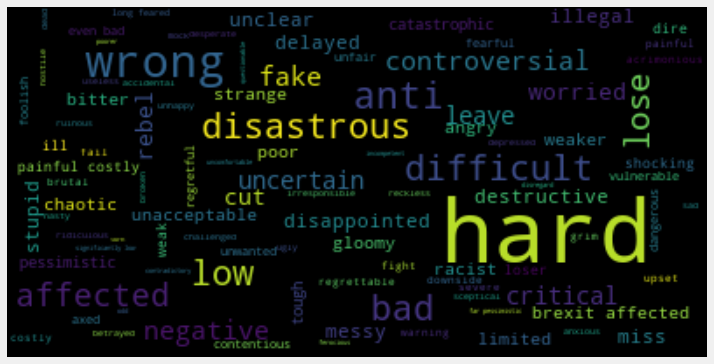

In [ ]:
plot_wordcloud(cnt_negativo)

### USA

In [ ]:
us = ["us", "u.s", "trump", "dollar", "donald"]
pos = 0
neg = 0
neut = 0
elements = 0

for item in dataset["aspetti"]:
    for asp in item:
        if asp["aspetto"] in us:
            elements = elements+1
            if asp["sentiment"]["compound"] > 0:
                pos = pos +1
            if  asp["sentiment"]["compound"] == 0:
                neut = neut +1
            if asp["sentiment"]["compound"] < 0:
                neg = neg +1
print("------------------------")
print("Tot: ", elements)
print("Label   :", "us")
print("positive ", pos)
print("negative ", neg)
print("neutral ", neut)

------------------------
Tot:  3894
Label   : us
positive  519
negative  394
neutral  2981


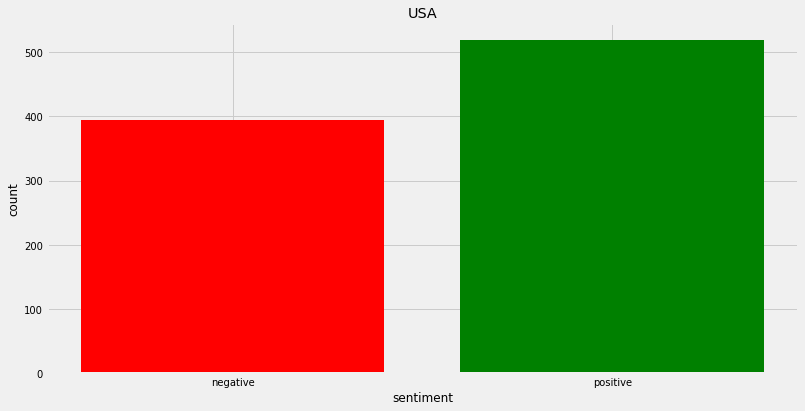

In [ ]:
import matplotlib.pyplot as plt

# x-coordinates of left sides of bars 

left = [1,2]

# heights of bars
height = [neg, pos]

# labels for bars
tick_label = ['negative', 'positive']

# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

# naming the x-axis
plt.xlabel('sentiment')
# naming the y-axis
plt.ylabel('count')
# plot title
plt.title("USA")

plt.savefig("USA.jpg")
# function to show the plot
plt.show()



In [ ]:
us = ["us", "u.s", "trump", "dollar", "donald"]
cnt_positivo = Counter()
for asp in positive_tot:
    if asp["aspetto"] in us:
        cnt_positivo[asp["desc"]] += 1
cnt_positivo.most_common(10)

[('strong', 124),
 ('good', 28),
 ('positive', 20),
 ('united', 19),
 ('clear', 17),
 ('great', 16),
 ('certain', 15),
 ('true', 12),
 ('important', 10),
 ('best', 9)]

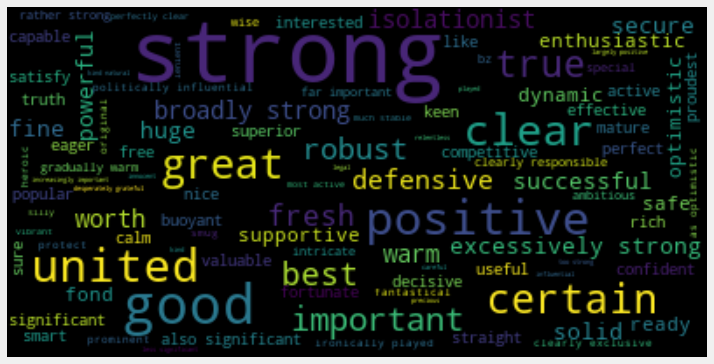

In [ ]:
plot_wordcloud(cnt_positivo)

In [ ]:
us = ["us", "u.s", "trump", "dollar", "donald"]
cnt_negativo = Counter()
for asp in negative_tot:
    if asp["aspetto"] in us:
        cnt_negativo[asp["desc"]] += 1
cnt_negativo.most_common(10)

[('low', 124),
 ('weaker', 19),
 ('weak', 16),
 ('bad', 12),
 ('wrong', 11),
 ('hard', 6),
 ('obsolete', 6),
 ('dangerous', 5),
 ('anti', 5),
 ('angry', 5)]

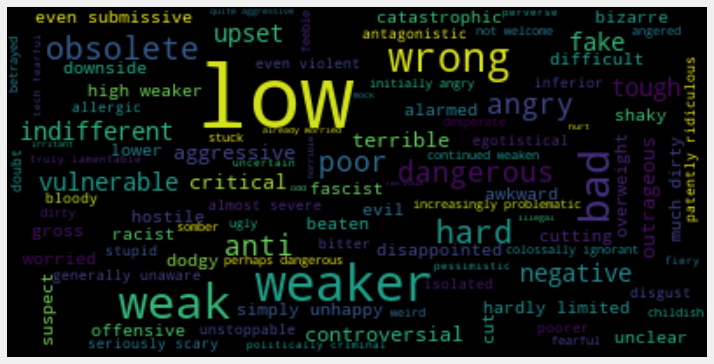

In [ ]:
plot_wordcloud(cnt_negativo)

### UK

In [ ]:
uk = ["uk", "country", "britain", "kingdom", "london", "scotland", "england"]
pos = 0
neg = 0
neut = 0
elements = 0

for item in dataset["aspetti"]:
    for asp in item:
        if asp["aspetto"] in uk:
            elements = elements+1
            if asp["sentiment"]["compound"] > 0:
                pos = pos +1
            if  asp["sentiment"]["compound"] == 0:
                neut = neut +1
            if asp["sentiment"]["compound"] < 0:
                neg = neg +1
print("------------------------")
print("Tot: ", elements)
print("Label   :", "uk")
print("positive ", pos)
print("negative ", neg)
print("neutral ", neut)

------------------------
Tot:  32495
Label   : uk
positive  8647
negative  1681
neutral  22167


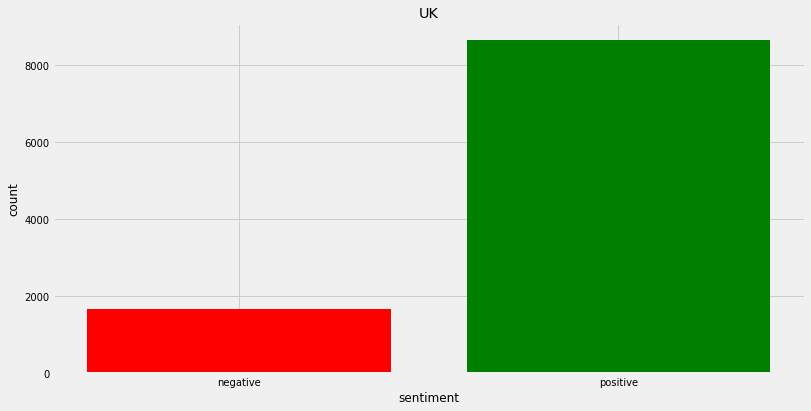

In [ ]:
import matplotlib.pyplot as plt

# x-coordinates of left sides of bars 

left = [1,2]

# heights of bars
height = [neg, pos]

# labels for bars
tick_label = ['negative', 'positive']

# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

# naming the x-axis
plt.xlabel('sentiment')
# naming the y-axis
plt.ylabel('count')
# plot title
plt.title("UK")

plt.savefig("UK.jpg")
# function to show the plot
plt.show()



In [ ]:
uk = ["uk", "country", "britain", "kingdom", "london", "scotland", "england"]
cnt_positivo = Counter()
for asp in positive_tot:
    if asp["aspetto"] in uk:
        cnt_positivo[asp["desc"]] += 1
cnt_positivo.most_common(10)

[('united', 4076),
 ('great', 733),
 ('good', 293),
 ('best', 278),
 ('strong', 246),
 ('important', 201),
 ('clear', 191),
 ('free', 97),
 ('significant', 84),
 ('rich', 72)]

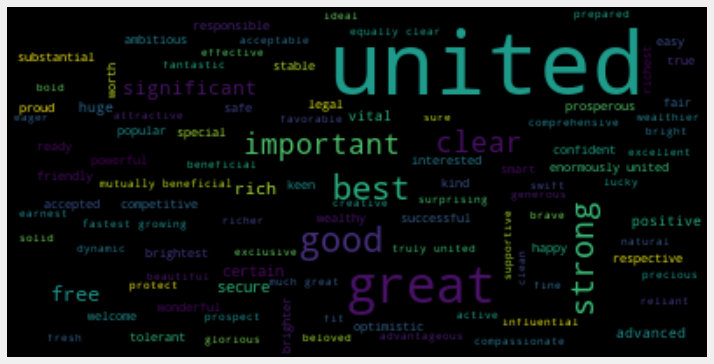

In [ ]:
plot_wordcloud(cnt_positivo)

In [ ]:
uk = ["uk", "country", "britain", "kingdom", "london", "scotland", "england"]
cnt_negativo = Counter()
for asp in negative_tot:
    if asp["aspetto"] in uk:
        cnt_negativo[asp["desc"]] += 1
cnt_negativo.most_common(10)

[('bad', 143),
 ('poor', 75),
 ('low', 70),
 ('well bad', 61),
 ('hard', 59),
 ('poorer', 46),
 ('anti', 44),
 ('poorest', 37),
 ('difficult', 36),
 ('limited', 33)]

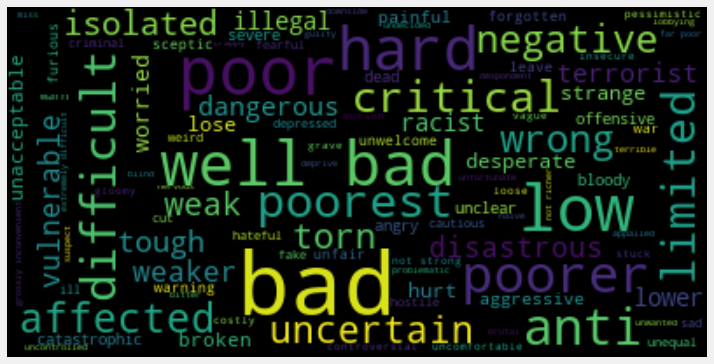

In [ ]:
plot_wordcloud(cnt_negativo)

### Economy

In [ ]:
trade = ["trade", "economy", "market", "bank", "industry", "price", "pound", "tax", "money", "economist"]
pos = 0
neg = 0
neut = 0
elements = 0

for item in dataset["aspetti"]:
    for asp in item:
        if asp["aspetto"] in trade:
            elements = elements+1
            if asp["sentiment"]["compound"] > 0:
                pos = pos +1
            if  asp["sentiment"]["compound"] == 0:
                neut = neut +1
            if asp["sentiment"]["compound"] < 0:
                neg = neg +1
print("------------------------")
print("Tot: ", elements)
print("Label   :", "trade")
print("positive ", pos)
print("negative ", neg)
print("neutral ", neut)

------------------------
Tot:  48805
Label   : trade
positive  7951
negative  2448
neutral  38406


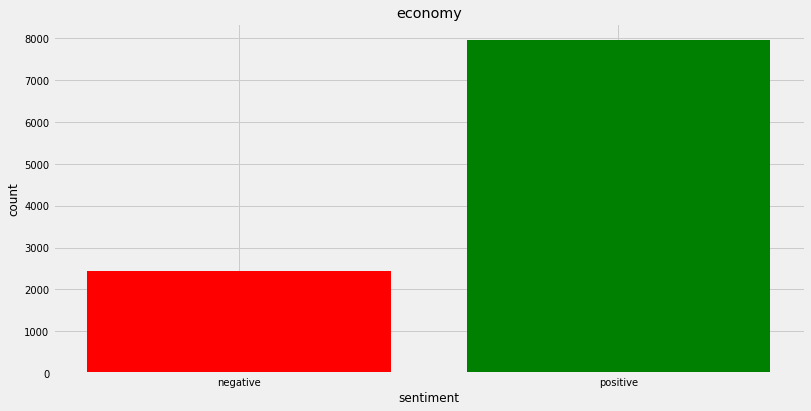

In [ ]:
import matplotlib.pyplot as plt

# x-coordinates of left sides of bars 

left = [1,2]

# heights of bars
height = [neg, pos]

# labels for bars
tick_label = ['negative', 'positive']

# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green'])

# naming the x-axis
plt.xlabel('sentiment')
# naming the y-axis
plt.ylabel('count')
# plot title
plt.title("economy")
plt.savefig("economy.jpg")
# function to show the plot
plt.show()


In [ ]:
trade = ["trade", "economy", "market", "bank", "industry", "price", "pound", "tax", "money", "economist"]
cnt_positivo = Counter()
for asp in positive_tot:
    if asp["aspetto"] in trade:
        cnt_positivo[asp["desc"]] += 1
cnt_positivo.most_common(10)

[('free', 3967),
 ('good', 335),
 ('strong', 284),
 ('positive', 189),
 ('important', 166),
 ('great', 122),
 ('advanced', 109),
 ('huge', 103),
 ('significant', 102),
 ('worth', 86)]

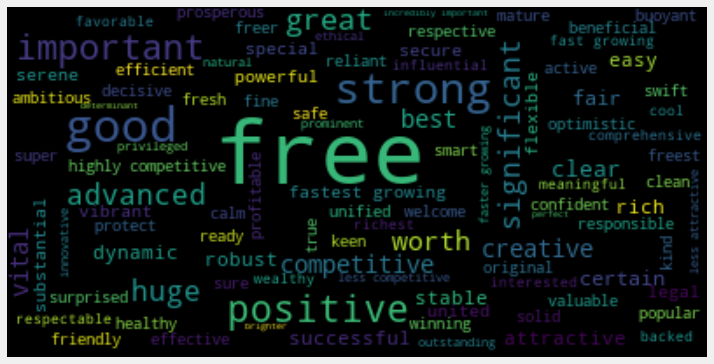

In [ ]:
plot_wordcloud(cnt_positivo)

In [ ]:
trade = ["trade", "economy", "market", "bank", "industry", "price", "pound", "tax", "money", "economist"]
cnt_negativo = Counter()
for asp in negative_tot:
    if asp["aspetto"] in trade:
        cnt_negativo[asp["desc"]] += 1
cnt_negativo.most_common(10)

[('low', 587),
 ('weaker', 196),
 ('weak', 189),
 ('weaken', 115),
 ('bad', 93),
 ('negative', 75),
 ('crude', 54),
 ('hard', 49),
 ('difficult', 42),
 ('cut', 41)]

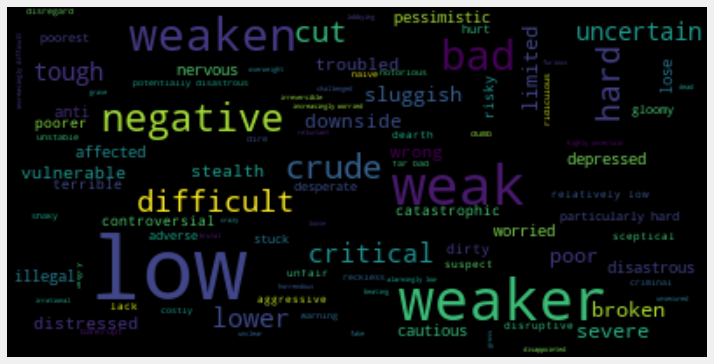

In [ ]:
plot_wordcloud(cnt_negativo)

###  SENTIMENT FOR TOPIC 

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/dataDEF4.csv")
train = train.drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','Unnamed: 0.1.1.1'])

In [ ]:
aspetti = train['aspetti'].values.tolist()
aspetti_list = [eval(str_k) for str_k in aspetti]

In [ ]:
print(len(train))
print(len(aspetti_list))

23053
23053


In [ ]:
train['aspetti'] = aspetti_list

In [ ]:
urls_parse_groupby_DF = pd.read_csv('/content/drive/MyDrive/Progetto_Data_Analytics/Dataset/urls_parse_groupby_DF.csv')
urls_parse_groupby_DF = urls_parse_groupby_DF.drop(columns='Unnamed: 0')
urls_parse_groupby_DF

In [ ]:
news_with_orientation = urls_parse_groupby_DF[urls_parse_groupby_DF['orientation'] != ""]
news_with_orientation.dropna(subset=['orientation'], inplace=True)
news_with_orientation.reset_index(drop=True, inplace=True)#rimette gli index con un ordine corretto
news_with_orientation

In [ ]:
urls_group = news_with_orientation['url'].values.tolist()

### Immigration

In [ ]:
immigration = ["migration", "immigrant", "migrant", "muslim", "immigration"]
compount_avg = []
elements = 0
for url in urls_group:
  articles = train[train['domain'] == url]
  compount_single = []
  for item in articles["aspetti"]:
    for asp in item:
      if asp["aspetto"] in immigration:
        elements = elements+1
        compount_single.append(asp["sentiment"]["compound"])
  compount_avg.append(statistics.mean(compount_single))


In [ ]:
d = {'url':urls_group,'compound':compount_avg}
df = pd.DataFrame(d)
df.head()

url  compound
0     www.dailymail.co.uk -0.015408
1     www.theguardian.com -0.014037
2  www.heraldscotland.com  0.017209
3      www.thetimes.co.uk -0.037747
4        www.thesun.co.uk  0.001553

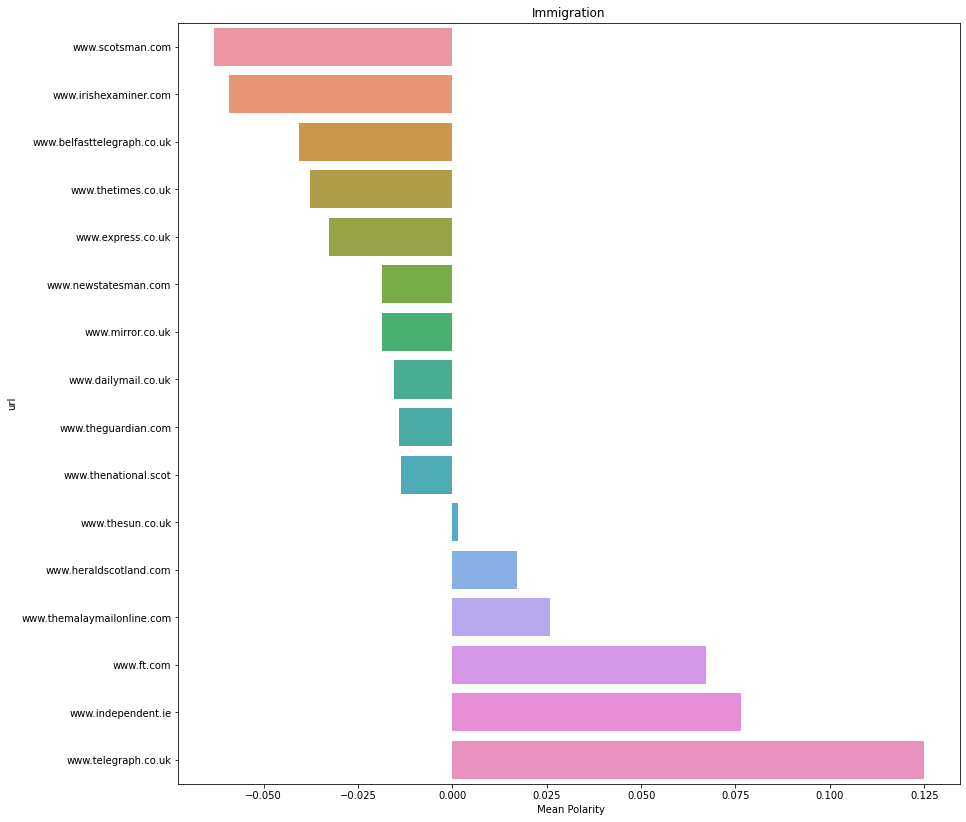

In [ ]:
# Checking out the distribution of the news polarity based on the source of news
#df_polarity = pd.read_csv('data/mean_polarity.csv')
df = df.sort_values(['compound']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(14, 14))
ax = sns.barplot(x='compound', y='url', data=df)
ax.set_title("Immigration")
ax.set_xlabel(' Mean Polarity')
plt.savefig("Immigration_topic_byURL.jpg")
#ax.axvline(0.07)
#ax.axvline(-0.07)

### politics

In [ ]:
politics = ["minister", "government", "party", "policy", "leader", "parliament", "president", "crisis", "politicians", "politics", "msps", "democracy"]
compount_avg = []
elements = 0
for url in urls_group:
  articles = train[train['domain'] == url]
  compount_single = []
  for item in articles["aspetti"]:
    for asp in item:
      if asp["aspetto"] in politics:
        elements = elements+1
        compount_single.append(asp["sentiment"]["compound"])
  compount_avg.append(statistics.mean(compount_single))


In [ ]:
d = {'url':urls_group,'compound':compount_avg}
df = pd.DataFrame(d)
df.head()

url  compound
0     www.dailymail.co.uk  0.002285
1     www.theguardian.com  0.006643
2  www.heraldscotland.com  0.006077
3      www.thetimes.co.uk  0.002886
4        www.thesun.co.uk  0.005243

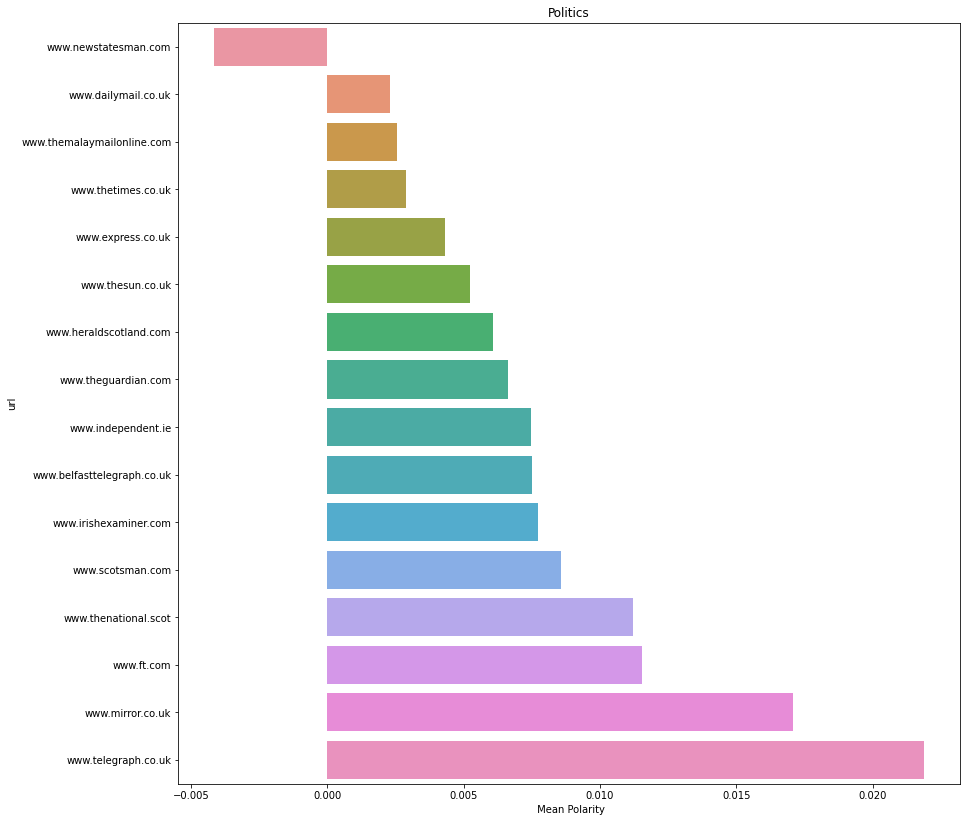

In [ ]:
# Checking out the distribution of the news polarity based on the source of news
df = df.sort_values(['compound']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(14, 14))
ax = sns.barplot(x='compound', y='url', data=df)
ax.set_xlabel(' Mean Polarity')
ax.set_title("Politics")
plt.savefig("politics_topic_byURL.jpg")

### Labour

In [ ]:
labour = ["corbyn", "labour"]
compount_avg = []
elements = 0
for url in urls_group:
  articles = train[train['domain'] == url]
  compount_single = []
  for item in articles["aspetti"]:
    for asp in item:
      if asp["aspetto"] in labour:
        elements = elements+1
        compount_single.append(asp["sentiment"]["compound"])
  if compount_single == []:
    compount_avg.append(0.0)
  else:
    compount_avg.append(statistics.mean(compount_single))


In [ ]:
d = {'url':urls_group,'compound':compount_avg}
df = pd.DataFrame(d)
df.head()

url  compound
0     www.dailymail.co.uk -0.022058
1     www.theguardian.com  0.020788
2  www.heraldscotland.com  0.021452
3      www.thetimes.co.uk  0.010325
4        www.thesun.co.uk  0.020881

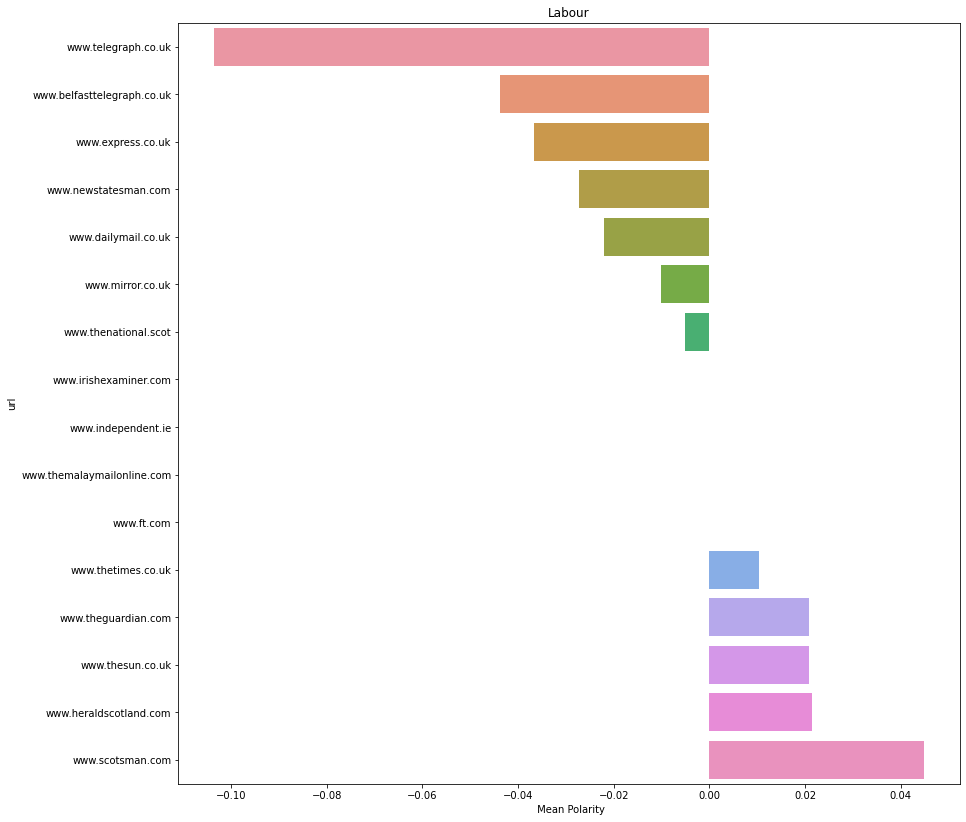

In [ ]:
# Checking out the distribution of the news polarity based on the source of news
df = df.sort_values(['compound']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(14, 14))
ax = sns.barplot(x='compound', y='url', data=df)
ax.set_xlabel(' Mean Polarity')
ax.set_title("Labour")
plt.savefig("labour_topic_byURL.jpg")

### Theresa

In [ ]:
theresa = ["conservative", "theresa",  "may"]
compount_avg = []
elements = 0
for url in urls_group:
  articles = train[train['domain'] == url]
  compount_single = []
  for item in articles["aspetti"]:
    for asp in item:
      if asp["aspetto"] in theresa:
        elements = elements+1
        compount_single.append(asp["sentiment"]["compound"])
  compount_avg.append(statistics.mean(compount_single))


In [ ]:
d = {'url':urls_group,'compound':compount_avg}
df = pd.DataFrame(d)
df.head()

url  compound
0     www.dailymail.co.uk -0.018132
1     www.theguardian.com -0.001696
2  www.heraldscotland.com -0.010579
3      www.thetimes.co.uk  0.004228
4        www.thesun.co.uk  0.019653

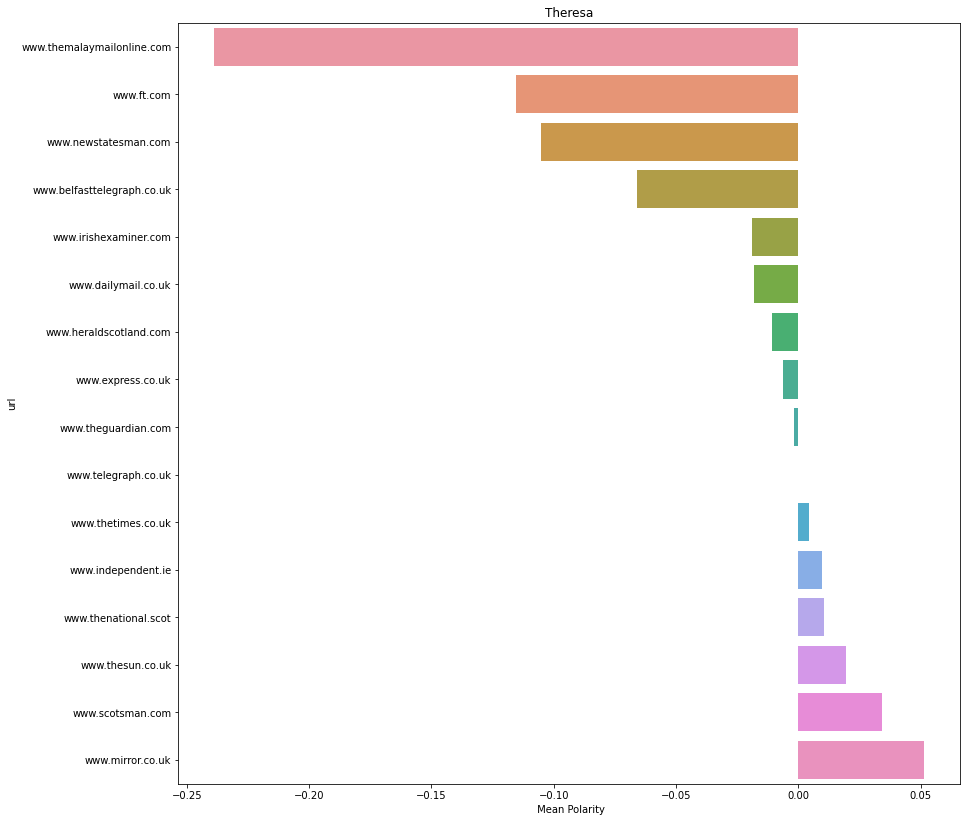

In [ ]:
# Checking out the distribution of the news polarity based on the source of news
df = df.sort_values(['compound']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(14, 14))
ax = sns.barplot(x='compound', y='url', data=df)
ax.set_xlabel(' Mean Polarity')
ax.set_title("Theresa")
plt.savefig("theresa_topic_byURL.jpg")

### Europe

In [ ]:
europe = ["brussels", "europe", "union", "farage", "europeans", "eurosceptics", "germany", "italy", "euro", "eu"]
compount_avg = []
elements = 0
for url in urls_group:
  articles = train[train['domain'] == url]
  compount_single = []
  for item in articles["aspetti"]:
    for asp in item:
      if asp["aspetto"] in europe:
        elements = elements+1
        compount_single.append(asp["sentiment"]["compound"])
  compount_avg.append(statistics.mean(compount_single))


In [ ]:
d = {'url':urls_group,'compound':compount_avg}
df = pd.DataFrame(d)
df.head()

url  compound
0     www.dailymail.co.uk  0.017700
1     www.theguardian.com  0.021035
2  www.heraldscotland.com  0.029954
3      www.thetimes.co.uk  0.010089
4        www.thesun.co.uk  0.019985

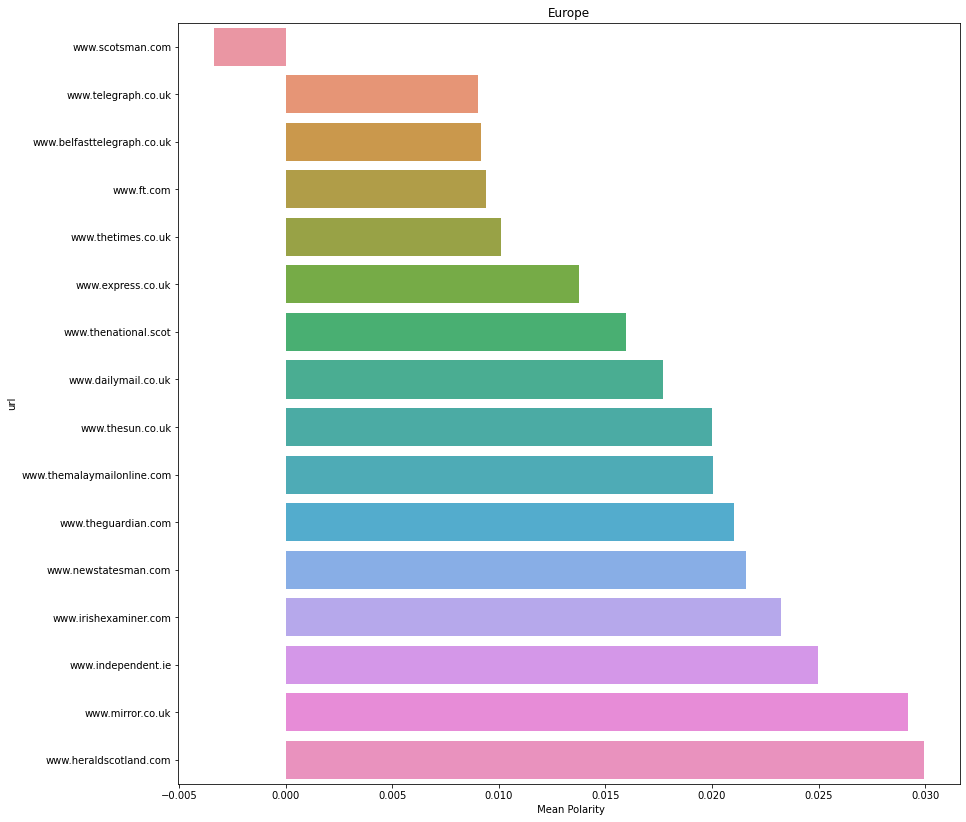

In [ ]:
# Checking out the distribution of the news polarity based on the source of news
df = df.sort_values(['compound']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(14, 14))
ax = sns.barplot(x='compound', y='url', data=df)
ax.set_xlabel(' Mean Polarity')
ax.set_title("Europe")
plt.savefig("europe_topic_byURL.jpg")
#ax.axvline(0.07)
#ax.axvline(-0.07)

### deal

In [ ]:
deal = ["deal", "firm", "meeting", "offer", "future", "negotiation", "decision", "bill"]
compount_avg = []
elements = 0
for url in urls_group:
  articles = train[train['domain'] == url]
  compount_single = []
  for item in articles["aspetti"]:
    for asp in item:
      if asp["aspetto"] in deal:
        elements = elements+1
        compount_single.append(asp["sentiment"]["compound"])
  compount_avg.append(statistics.mean(compount_single))


In [ ]:
d = {'url':urls_group,'compound':compount_avg}
df = pd.DataFrame(d)
df.head()

url  compound
0     www.dailymail.co.uk  0.050292
1     www.theguardian.com  0.042889
2  www.heraldscotland.com  0.062522
3      www.thetimes.co.uk  0.032557
4        www.thesun.co.uk  0.051700

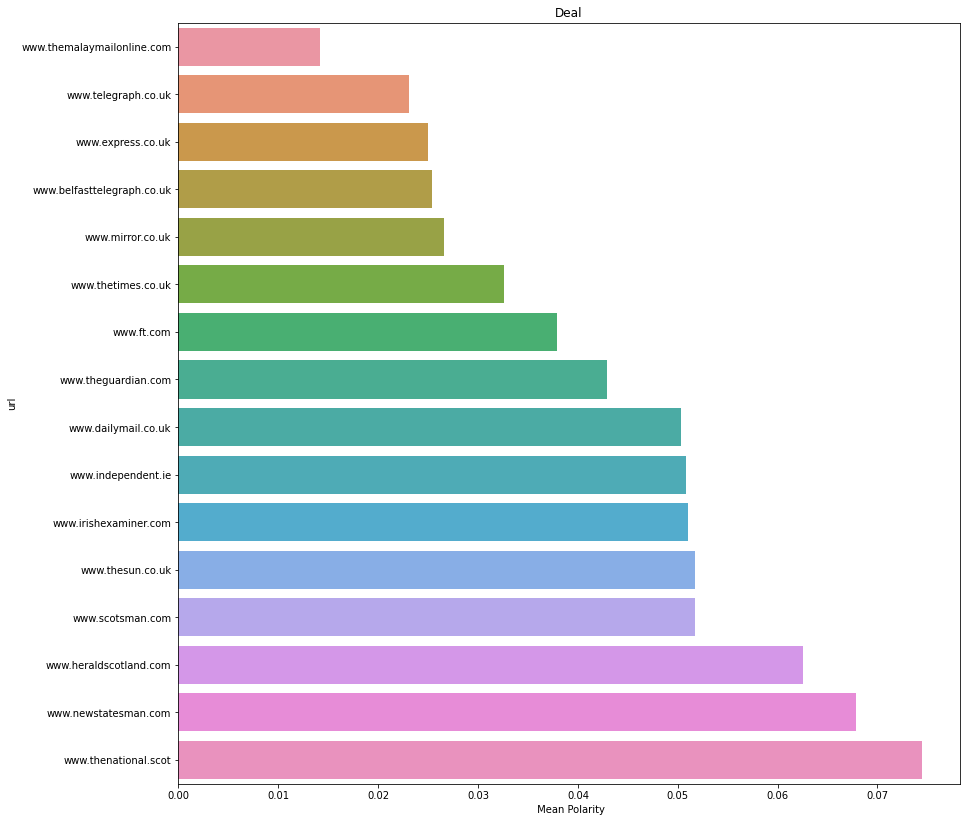

In [ ]:
# Checking out the distribution of the news polarity based on the source of news
df = df.sort_values(['compound']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(14, 14))
ax = sns.barplot(x='compound', y='url', data=df)
ax.set_xlabel(' Mean Polarity')
ax.set_title("Deal")
plt.savefig("Deal_topic_byURL.jpg")
#ax.axvline(0.07)
#ax.axvline(-0.07)

### referendum

In [ ]:
referendum = ["referendum", "vote", "election", "brexit", "poll", "exit"]
compount_avg = []
elements = 0
for url in urls_group:
  articles = train[train['domain'] == url]
  compount_single = []
  for item in articles["aspetti"]:
    for asp in item:
      if asp["aspetto"] in referendum:
        elements = elements+1
        compount_single.append(asp["sentiment"]["compound"])
  compount_avg.append(statistics.mean(compount_single))


In [ ]:
d = {'url':urls_group,'compound':compount_avg}
df = pd.DataFrame(d)
df.head()

url  compound
0     www.dailymail.co.uk  0.003558
1     www.theguardian.com  0.002389
2  www.heraldscotland.com -0.006101
3      www.thetimes.co.uk -0.003269
4        www.thesun.co.uk  0.006444

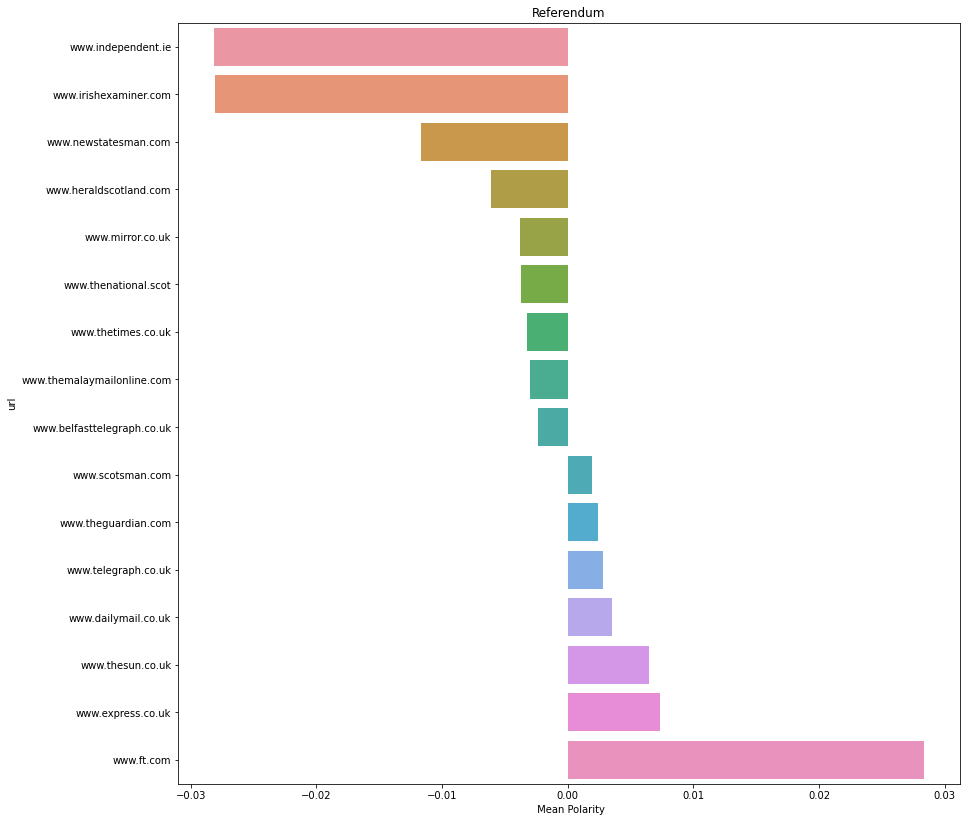

In [ ]:
# Checking out the distribution of the news polarity based on the source of news
df = df.sort_values(['compound']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(14, 14))
ax = sns.barplot(x='compound', y='url', data=df)
ax.set_xlabel(' Mean Polarity')
ax.set_title("Referendum")
plt.savefig("referendum_topic_byURL.jpg")
#ax.axvline(0.07)
#ax.axvline(-0.07)

### us

In [ ]:
us = ["us", "u.s", "trump", "dollar", "donald"]
compount_avg = []
elements = 0
for url in urls_group:
  articles = train[train['domain'] == url]
  compount_single = []
  for item in articles["aspetti"]:
    for asp in item:
      if asp["aspetto"] in us:
        elements = elements+1
        compount_single.append(asp["sentiment"]["compound"])
  compount_avg.append(statistics.mean(compount_single))


In [ ]:
d = {'url':urls_group,'compound':compount_avg}
df = pd.DataFrame(d)
df.head()

url  compound
0     www.dailymail.co.uk  0.034565
1     www.theguardian.com  0.046829
2  www.heraldscotland.com  0.026366
3      www.thetimes.co.uk  0.134433
4        www.thesun.co.uk  0.023428

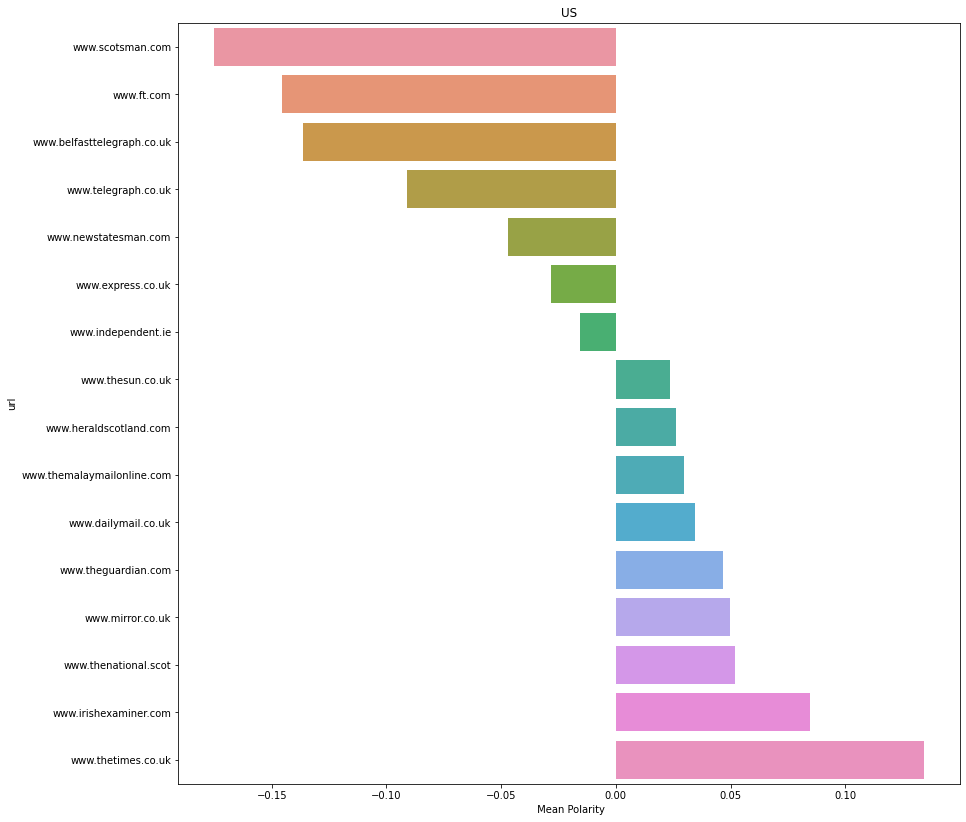

In [ ]:
# Checking out the distribution of the news polarity based on the source of news
df = df.sort_values(['compound']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(14, 14))
ax = sns.barplot(x='compound', y='url', data=df)
ax.set_xlabel(' Mean Polarity')
ax.set_title("US")
plt.savefig("us_topic_byURL.jpg")
#ax.axvline(0.07)
#ax.axvline(-0.07)

### uk 

In [ ]:
uk = ["uk", "country", "britain", "kingdom", "london", "scotland", "england"]
compount_avg = []
elements = 0
for url in urls_group:
  articles = train[train['domain'] == url]
  compount_single = []
  for item in articles["aspetti"]:
    for asp in item:
      if asp["aspetto"] in uk:
        elements = elements+1
        compount_single.append(asp["sentiment"]["compound"])
  compount_avg.append(statistics.mean(compount_single))


In [ ]:
d = {'url':urls_group,'compound':compount_avg}
df = pd.DataFrame(d)
df.head()

url  compound
0     www.dailymail.co.uk  0.076779
1     www.theguardian.com  0.065508
2  www.heraldscotland.com  0.087651
3      www.thetimes.co.uk  0.063994
4        www.thesun.co.uk  0.064464

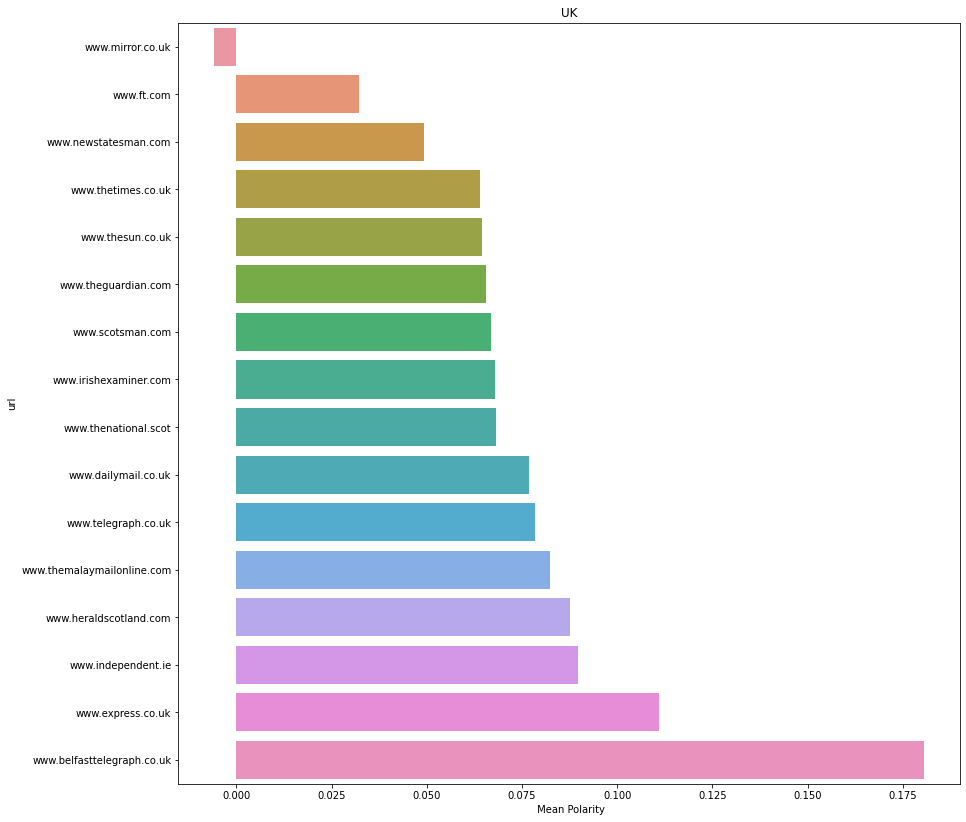

In [ ]:
# Checking out the distribution of the news polarity based on the source of news
df = df.sort_values(['compound']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(14, 14))
ax = sns.barplot(x='compound', y='url', data=df)
ax.set_xlabel(' Mean Polarity')
ax.set_title("UK")
plt.savefig("uk_topic_byURL.jpg")
#ax.axvline(0.07)
#ax.axvline(-0.07)

### trade

In [ ]:
import statistics
trade = ["trade", "economy", "market", "bank", "industry", "price", "pound", "tax", "money", "economist"]
compount_avg = []
elements = 0
for url in urls_group:
  articles = train[train['domain'] == url]
  compount_single = []
  for item in articles["aspetti"]:
    for asp in item:
      if asp["aspetto"] in trade:
        elements = elements+1
        compount_single.append(asp["sentiment"]["compound"])
  compount_avg.append(statistics.mean(compount_single))


In [ ]:
d = {'url':urls_group,'compound':compount_avg}
df = pd.DataFrame(d)
df.head()

url  compound
0     www.dailymail.co.uk  0.029600
1     www.theguardian.com  0.053911
2  www.heraldscotland.com  0.044447
3      www.thetimes.co.uk  0.026848
4        www.thesun.co.uk  0.068334

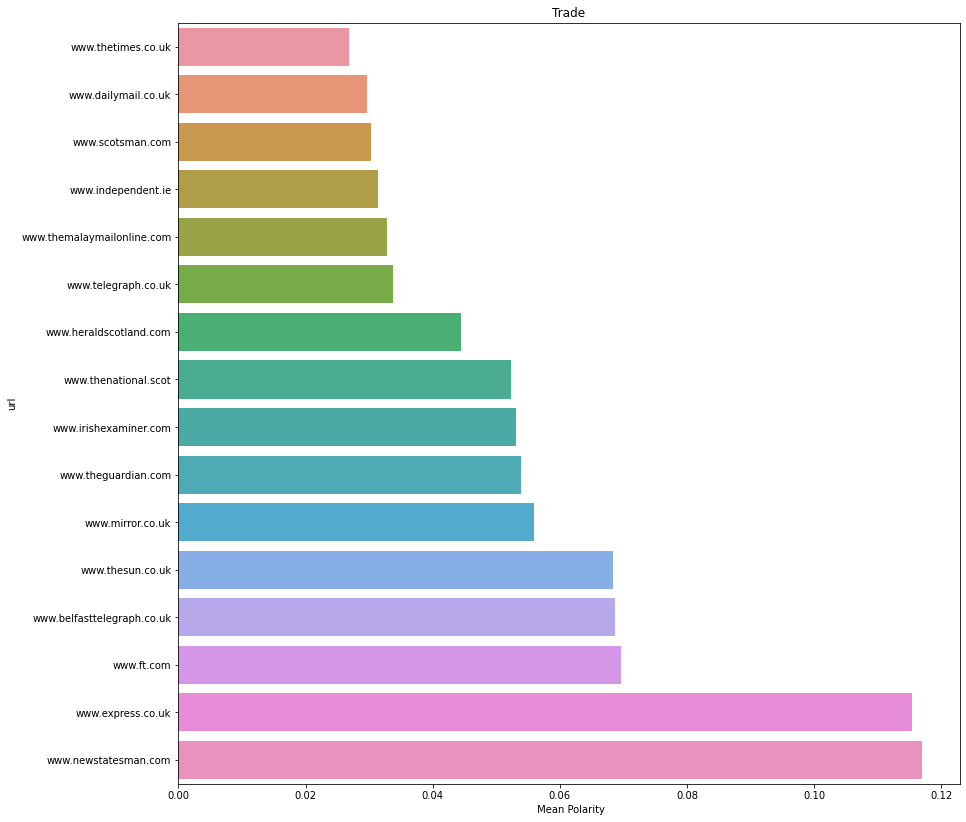

In [ ]:
# Checking out the distribution of the news polarity based on the source of news
#df_polarity = pd.read_csv('data/mean_polarity.csv')
import matplotlib.pyplot as plt
import seaborn as sns
df = df.sort_values(['compound']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(14, 14))
ax = sns.barplot(x='compound', y='url', data=df)
ax.set_xlabel(' Mean Polarity')
ax.set_title("Trade")
plt.savefig("trade_topic_byURL.jpg")
#ax.axvline(0.07)
#ax.axvline(-0.07)

### Brexit

In [ ]:
compount_avg = []
elements = 0
for url in urls_group:
  articles = train[train['domain'] == url]
  compount_single = []
  for item in articles["aspetti"]:
    for asp in item:
      if asp["aspetto"] == "brexit":
        elements = elements+1
        compount_single.append(asp["sentiment"]["compound"])
  compount_avg.append(statistics.mean(compount_single))


In [ ]:
d = {'url':urls_group,'compound':compount_avg}
df = pd.DataFrame(d)
df.head()

url  compound
0     www.dailymail.co.uk  0.004721
1     www.theguardian.com -0.028717
2  www.heraldscotland.com -0.043866
3      www.thetimes.co.uk -0.028662
4        www.thesun.co.uk -0.008904

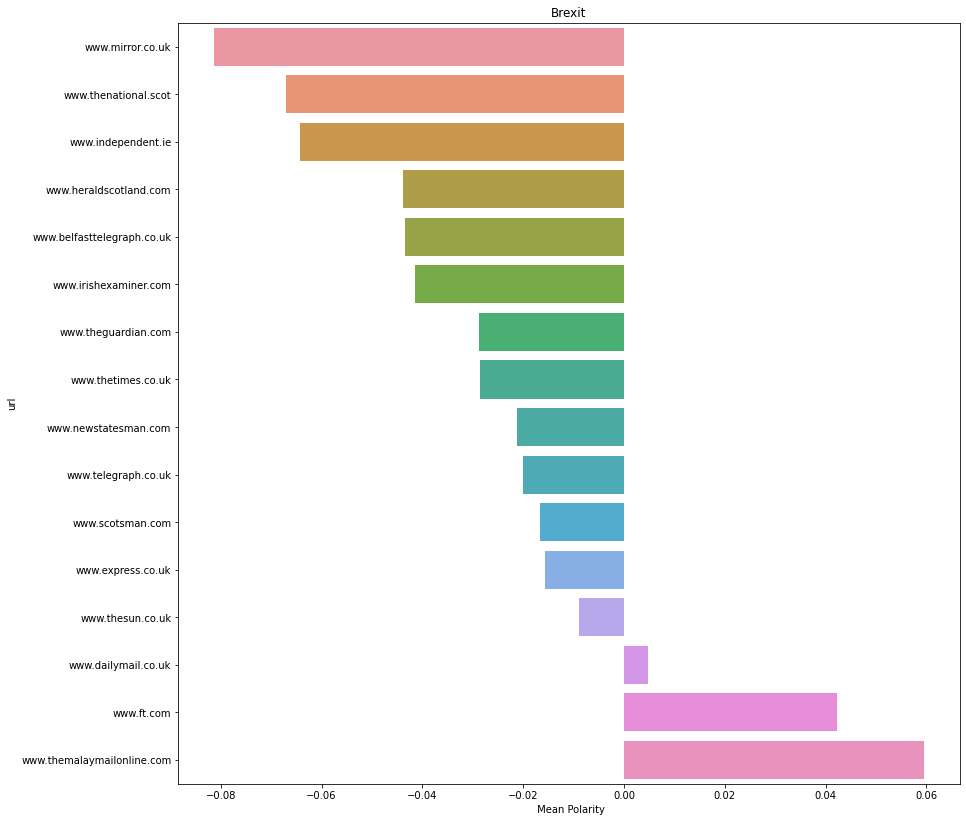

In [ ]:
# Checking out the distribution of the news polarity based on the source of news
df = df.sort_values(['compound']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(14, 14))
ax = sns.barplot(x='compound', y='url', data=df)
ax.set_xlabel(' Mean Polarity')
ax.set_title("Brexit")
plt.savefig("Brexit_topic_byURL.jpg")
#ax.axvline(0.07)
#ax.axvline(-0.07)